In [11]:
import scipy.io as scio
import os
import mne
import numpy as np
import time
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import scipy.stats as stats
from statannotations.Annotator import Annotator
%matplotlib inline
# sns.set(style="whitegrid")

In [12]:
import warnings
warnings.filterwarnings("ignore")

### Subject IDs

In [13]:
# 1 means chronic pain, 0 means control
sub_ids = {
    '5186': 1,
    '5295': 1,
    '5648': 0,
    '5675': 0,
    '5873': 0,
    '6100': 0,
    '6106': 0,
    '6310': 1,
}

In [14]:
# Separate groups
sub_ids_LP = {k:v for k,v in sub_ids.items() if v == 1}
sub_ids_LC = {k:v for k,v in sub_ids.items() if v == 0}
print(f"Chronics: {len([k for k,v in sub_ids.items() if v == 1])}")
print(f"Controls: {len([k for k,v in sub_ids.items() if v == 0])}")
print(f"Total: {len(sub_ids)}")


Chronics: 3
Controls: 5
Total: 8


### Settings for conditions/bands/methods

In [15]:
# Settings

# Include intermediate stimulus?
include_LS = False

# Data properties
sfreq = 400  # Hz

# Use canonical bands or narrower bands
narrow_bands = True 

# Choose which connectivity estimates to run. "amplitude", "phase", or "both"
# method_choice = "phase"
method_choice = "both"

# Load previously saved group data
load_group_data_flag = False

# Save group data?
save_group_data_flag = True
   
# Evoked only or include resting too?
# include_resting = False
include_resting = True

# Orthogonalize AEC?
orthogonalize_AEC = True

#####################################################
# Test mode
# plot_only_mode = True
plot_only_mode = False
if plot_only_mode:
    # narrow_bands = False
    # include_resting = False
    load_group_data_flag = True
    save_group_data_flag = False

### Define ROIs, frequency bands, conditions, and methods for FC

In [16]:
####################################################################
# REGIONS OF INTEREST
# Get stc only from selected labels
# Get stc only from selected labels
roi_names = [# Left
             'rostralanteriorcingulate-lh', # Left Rostral ACC
             'caudalanteriorcingulate-lh', # Left Caudal ACC
             'postcentral-lh', # Left S1,
             'insula-lh', 'superiorfrontal-lh', # Left Insula, Left DL-PFC,
             'medialorbitofrontal-lh', # Left Medial-OFC
             # CONTROLS
             # lateral occipital
             'lateraloccipital-lh', # Left Visual Cortex
             'superiortemporal-lh', # Left Auditory Cortex
             # Right
             'rostralanteriorcingulate-rh', # Right Rostral ACC
             'caudalanteriorcingulate-rh', # Right Caudal ACC
             'postcentral-rh', # , Right S1
             'insula-rh', 'superiorfrontal-rh', # Right Insula, Right DL-PFC
             'medialorbitofrontal-rh', # Right Medial-OFC
             # CONTROLS
             'lateraloccipital-rh', # Right Visual Cortex
             'superiortemporal-rh', # Right Auditory Cortex
]

# Write out ROI names as acronyms
roi_acronyms = ["rACC-lh", "dACC-lh", "S1-lh", 
                "insula-lh", "dlPFC-lh", "mOFC-lh", 
                # CONTROLS
                "lOCC-lh", "aud-lh",
                "rACC-rh", "dACC-rh", "S1-rh", 
                "insula-rh", "dlPFC-rh", "mOFC-rh",
                # CONTROLS
                "lOCC-rh", "aud-rh", 
               ]    

####################################################################
# BANDS OF INTEREST
if not narrow_bands:
    Freq_Bands = {
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        # "alpha": [8.0, 13.0],
        # "beta": [13.0, 30.0],
        # "low-gamma": [30.0, 58.5],
        # # "notch": [58.5, 61.5],
        # "high-gamma": [61.5, 100.0],
    }
else:
    Freq_Bands = { # Narrower bands and overlaps
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        "alpha": [8.0, 13.0],
        "beta": [13.0, 30.0],
        "low-gamma": [30.0, 58.5],
        # # "notch": [58.5, 61.5],
        "high-gamma": [61.5, 100.0],
    }
band_names = [band for band in Freq_Bands]

####################################################################
# CONNECTIVITY METHODS
if method_choice == "phase":
    con_methods = ["wpli2_debiased",
                ]
elif method_choice == "amplitude":
    con_methods = [
        # "aec_pairwise",
        "aec_symmetric",
        ]
elif method_choice == "both":
    con_methods = [
    "wpli2_debiased",
    # "aec_pairwise",
    "aec_symmetric", # keep only symmetric for now
    ]
    
####################################################################
# CONDITIONS
conditions = (
    [
        "Hand 32 mN",
        "Hand 128 mN",
        "Hand 256 mN",
        "Back 32 mN",
        "Back 128 mN",
        "Back 256 mN",
        "Eyes Open",
        "Eyes Closed",
    ]
    if include_LS
    else [
        # "Hand 32 mN",
        # 'Hand LS',
        "Hand 256 mN",
        # "Back 32 mN",
        # 'Back LS',
        # "Back 256 mN",
        "Eyes Open",
        # "Eyes Closed",
    ]
)

# Choose to exclude resting state data
conditions = conditions if include_resting else [
    c for c in conditions if "Eyes" not in c
]

####################################################################
# CONDITION DICTIONARY
condition_dict = {
        "Hand 32 mN": 0,
        'Hand LS': 1,
        "Hand 256 mN": 2,
        "Back 32 mN": 3,
        'Back LS': 4,
        "Back 256 mN": 5,
        "Eyes Open": 6,
        "Eyes Closed": 7,
}

In [17]:
def delete_multiple_elements(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)## define functions for extracting relevant epochs
            
def stats_plot(df, save_path, site, feature):
    '''
    df = dataframe (mean, peak, auc)
    save_path = directory to save stats PNG and TXT files
    site = 'hand' or 'back'
    feature = 'mean','peak','auc'    
    '''    

    pairs=[((f,conditions[0]),(f,conditions[1])) for f in freq_bands_of_interest]
    
    for roi_idx, roi in enumerate(roi_names):        
        df_ch_tmp=df.query(f"channel=='{roi}'")
       

        #stats plot
        scale=2
        plt.figure(figsize=(19.2*scale,10.8*scale));
        sns.set_style('white')
        sns.set_context('paper', font_scale=6)
        ax_tmp = sns.boxplot(data=df_ch_tmp,x='band', y='value', hue='condition',
                palette='pastel', order=freq_bands_of_interest,
                hue_order=conditions, showfliers=False,
                linewidth=0.5)

        ax_tmp.set_title(f"{roi_names[roi_idx]}",pad=130)

        #stats output
        x='band'
        y='value'
        hue='condition'
        order=freq_bands_of_interest
        hue_order = conditions

        test = 'Mann-Whitney'
        print(f"******************************************************{roi} {test}******************************************************")
        annot = Annotator(ax_tmp, pairs, data=df_ch_tmp, x=x, y=y, hue=hue, order=order,hue_order=hue_order)
        annot.configure(test=test, text_format='star', loc='outside',comparisons_correction=None)
        annot.apply_test()
        annot.annotate()

        # save plot and tfr data
        save_fname = f"{roi}_{feature}_stim-based_{site}_set_{subject_set}"
        # print(df)

        plt.xlabel("Frequency Band")
        plt.ylabel("Scaled Power (x100)")
        plt.gca().legend().set_title('')

        # if site=='hand': 
        #     conditions=['Chronic Pain Hand 256 mN','Healthy Control Hand 256 mN']
        # elif site=='back': 
        #     conditions=['Chronic Pain Back 256 mN','Healthy Control Back 256 mN']

        handles,_ = ax_tmp.get_legend_handles_labels()
        ax_tmp.legend(handles, conditions, loc="best")
        plt.savefig(os.path.join(save_path,save_fname+".jpg"))
        plt.figure()

        # tfr data as csv
        df_ch_tmp.to_csv(os.path.join(save_path,save_fname+".csv"))
        display.clear_output(wait=True)  
     
       #save number of trials in df  
        total_epochs=df_ch_tmp['epoch'].count()
        total_trials=int(total_epochs/(len(freq_bands_of_interest)))
        with open(save_path+ f"Total Number of Trials set {subject_set}.txt", "w") as txt_file:
            txt_file.write(f"{total_trials}")
        display.clear_output(wait=True) 

In [18]:
# SETTINGS:

# 1. Choose all subjects, only CP, or only HC
group = "Chronic Pain"
# group = "Healthy Controls"
if group == "Chronic Pain":
    chosen_list = [el for el in sub_ids if el.startswith('0')]
else:
    chosen_list = [el for el in sub_ids if el.startswith('C')]

# 3. Set directory length requirement for starting analysis
min_path_len = 0

#4. Manually name the set of subjects being used 
subject_set= '1'

# Paths
processed_info_path = "../../../../George Kenefati/EEG/Data/Processed Data"
parent_data_path = "../../../../George Kenefati/EEG/Data/Source Time Courses/"
    
# Globals
Fs = 250 # Hz

tmin,tmax=-0.2,0.8
bmax=0.0

In [19]:
df_mean_all_hand=[]
df_peak_all_hand=[]
df_mean_all_back=[]
df_peak_all_back=[]

#loop through to analyze each subject 
for sub_folder in os.listdir(parent_data_path):
    sub_num=' ' # reset
    # ignores hidden files
    if sub_folder.startswith('.') or sub_folder not in chosen_list:
        continue
    else:
        sub_num=sub_folder

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ LOAD SUBJECT DATA @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ #
    data_path = os.path.join(parent_data_path,sub_num)

    #go through all the below code and then go to next subject  
    exam_hand_flag='lh' # right-handed exam for most subjects
    if sub_num=="055": # the only left-sided subject. regions must be contralateral.
        roi_names = [# Right
        'rostralanteriorcingulate-rh', # Right Rostral ACC
        'caudalanteriorcingulate-rh', # Right Caudal ACC
        'postcentral-rh', # , Right S1
        'insula-rh', 'superiorfrontal-rh', # Right Insula, Right DL-PFC
        'medialorbitofrontal-rh'] # Right Medial-PFC
        exam_hand_flag='rh' # 055 is the only left-sided exam
    else:
        roi_names = [# Left
         'rostralanteriorcingulate-lh', # Left Rostral ACC
         'caudalanteriorcingulate-lh', # Left Caudal ACC
         'postcentral-lh', # Left S1,
         'insula-lh', 'superiorfrontal-lh', # Left Insula, Left DL-PFC,
         'medialorbitofrontal-lh'] # Left Medial-PFC

    n_channels = len(roi_names)

    print(f"{sub_num}\nReading Source Space data...\n")

    stc_names_lst=[]
    stc_objects_lst=[]
    for stc_file in os.listdir(data_path): #loop should look for file in subject folder 
        if stc_file.endswith('.stc') and exam_hand_flag in stc_file: 
            print(stc_file)
            stc_tmp=mne.read_source_estimate(os.path.join(data_path,stc_file))
            stc_names_lst.append(os.path.join(data_path,stc_file))
            stc_objects_lst.append(stc_tmp)

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Import processed info @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ #
    # Process only subjects with 64 channel data, for homogeneity
    print(f"Reading stim_labels, epo_times, pain_ratings, drop_log for Subject {sub_num}...")

    stim_labels = scio.loadmat(os.path.join(processed_info_path,sub_num+'_stim_labels.mat'))
    stim_labels = stim_labels['stim_labels'].tolist()[0]

    print(f"\n*len(stim_labels) = {len(stim_labels)}*")

    # Load in sample times for stimuli
    epo_times = scio.loadmat(os.path.join(processed_info_path,sub_num+'_epo_times.mat'))
    epo_times_raw = epo_times['epo_times'] # leave as array
    epo_times = [el[0] for el in epo_times_raw]

    print(f"*len(epo_times) = {len(epo_times)}*\n")

    # Load in pain rating for each stimuli
    pain_ratings = scio.loadmat(os.path.join(processed_info_path,sub_num+'_pain_ratings.mat'))
    pain_ratings = pain_ratings['pain_ratings'].tolist()[0]

    print(f"*len(pain_ratings) = {len(pain_ratings)}*\n")

    # Load in drop log for bad trials
    drop_log = scio.loadmat(os.path.join(processed_info_path,sub_num+'_drop_log.mat'))
    drop_log = drop_log['drop_log'] # leave as array

    print(f"*len(drop_log) = {drop_log.shape[0]}*\n")

    display.clear_output(wait=True)

#     # Dict mapping key press labels to conditions
#     if 4 not in stim_labels or 7 not in stim_labels: 
#          event_ids_dict = {
#                   'Hand HS': 3, # hand YES pain
#                   'Hand LS': 5, # hand NO pain
#                   'Back HS': 6, # hand YES pain
#                   'Back LS': 8, # hand NO pain
#                 }
#     else: 
#         event_ids_dict = {
#                   'Hand HS': 3, # hand YES pain
#                   'Hand 0S': 4, # hand MED pain
#                   'Hand LS': 5, # hand NO pain
#                   'Back HS': 6, # back YES pain
#                   'Back 0S': 7, # back MED pain
#                   'Back LS': 8, # back NO pain
#                 }
    
    site='hand'
    # Limit events to selection
    event_ids_dict = {
              'Hand HS': 3, # hand YES pain
              # 'Hand 0S': 4, # hand MED pain
              'Hand LS': 5,} # hand NO pain
    conditions=['Hand HS','Hand LS']
     # select all back trials for deletion
    undesired_trial_ids = [4,6,7,8] # Hand LS + All back
    other_trials = [i for i,el in enumerate(stim_labels) if el in undesired_trial_ids]

    delete_multiple_elements(pain_ratings, other_trials)
    delete_multiple_elements(stim_labels, other_trials)
    delete_multiple_elements(epo_times, other_trials)        

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ EXTRACT DATA FROM STC FOR EPO @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ #

    #Extract data from STC
    stc_data_chs_array = np.zeros((len(roi_names),len(epo_times),Fs))
    stc_data_trials_tmp=np.zeros((len(epo_times),Fs))
    for j,stc in enumerate(stc_objects_lst): # for each roi
        extracted_data_tmp=stc.data
        for i in range(len(epo_times)): # for each trial
            #all vertices
            all_vertices_tmp=extracted_data_tmp[:,int(epo_times[i]+tmin*Fs):int(epo_times[i]+tmax*Fs)]
            #averaged vertices
            vertices_averaged_tmp=np.mean(all_vertices_tmp,axis=0)
            #store trials x time data in numpy array
            stc_data_trials_tmp[i,:] = vertices_averaged_tmp
        stc_data_chs_array[j,...] = stc_data_trials_tmp
    #data in Array format 
    stc_data_chs_corrected_array=np.transpose(stc_data_chs_array,(1,0,2))

#     # determine which indices are baseline vs stimulus
#     # baseline
#     len_baseline_samples = int((bmax-tmin)*Fs)
#     print(len_baseline_samples)
#     # stimulus
#     len_stimulus_samples = int((tmax-bmax)*Fs)
#     print(len_stimulus_samples)

#     # z-score data by for loop
#     data_epo=combined_stc_data_trials
#     print(data_epo.shape)
#     data_epo_zcore=np.copy(data_epo)
#     for i in range(data_epo.shape[0]): # for each epoch
#         for j in range(data_epo.shape[1]): # for each channel
#             # compute mean and std of baseline
#             base_mean = np.mean(data_epo[i,j,:len_baseline_samples])
#             base_std = np.std(data_epo[i,j,:len_baseline_samples])

#             # compute z-scored data from baseline stats
#             data_epo_zcore[i,j,:] = (data_epo[i,j,:]-base_mean)/base_std

#     # compare data before and after z-score
#     print(data_epo[0,0,len_baseline_samples:len_baseline_samples+10],'\n')
#     print(data_epo_zcore[0,0,len_baseline_samples:len_baseline_samples+10])

#     zepochs = mne.EpochsArray(data=data_epo_zcore,
#                               info=info,
#                               tmin=tmin,
#                               events=events,
#                               event_id=event_ids_dict,
#                               baseline=(None,bmax),
#                               )
#     print(zepochs)
#     epochs=zepochs 
#     del zepochs

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ CREATE EPOCHS OBJECT @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ #

    #Replace Epochs object with Z-scored data
    info = mne.create_info(roi_names, sfreq=Fs,ch_types='eeg')
    # create events array for Epochs object
    events=np.array([[epo_times[i],0,stim_labels[i]] for i in range(len(epo_times))])

    data_epo=stc_data_chs_corrected_array
    epochs = mne.EpochsArray(data=data_epo,
                              info=info,
                              tmin=tmin,
                              events=events,
                              event_id=event_ids_dict,
                              baseline=(None,bmax),
                              )
    print(epochs)

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ SET UP ERDS @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ #

    freqs = np.arange(1, 100)  # frequencies from 2-35Hz
    # vmin, vmax = -1, 1.5  # set min and max ERDS values in plot

    baseline = (tmin, bmax)  # baseline interval (in s)
    # cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

    # kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
                  # buffer_size=None, out_type='mask')  # for cluster test

    #Perform time-frequency decomposition over all epochs
    tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                         return_itc=False, average=False, decim=2)
    tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

#     for event in event_ids_dict:
#         # select desired epochs for visualization
#         tfr_ev = tfr[event]

#         widths_lst = [10]*n_channels
#         widths_lst.append(1)
#         fig, axes = plt.subplots(1, n_channels+1, figsize=(12, 4),
#                                  gridspec_kw={"width_ratios": widths_lst})
#         for ch, ax in enumerate(axes[:-1]):  # for each channel
#             # positive clusters
#             _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
#             # negative clusters
#             _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

#             # note that we keep clusters with p <= 0.05 from the combined clusters
#             # of two independent tests; in this example, we do not correct for
#             # these two comparisons
#             c = np.stack(c1 + c2, axis=2)  # combined clusters
#             p = np.concatenate((p1, p2))  # combined p-values
#             mask = c[..., p <= 0.05].any(axis=-1)

#             # plot TFR (ERDS map with masking)
#             tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
#                                   colorbar=False, show=False, mask=mask,
#                                   mask_style="mask")

        #     ax.set_title(epochs.ch_names[ch], fontsize=10)
        #     ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        #     if ch != 0:
        #         ax.set_ylabel("")
        #         ax.set_yticklabels("")
        # fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
        # fig.suptitle(f"ERDS ({event})")
        # plt.show()

    display.clear_output(wait=True)

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ SET UP PANDAS DATAFRAMES @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ #

    #Export tfr to pandas df in seconds
    # df = tfr.to_data_frame(time_format=None, long_format=False)
    # df.head()

    #Plot with confidence bands 
    df = tfr.to_data_frame(time_format=None, long_format=True)

    # Map to frequency bands:
    freq_bounds = {'_': 0,
                   'delta': 4,
                   'theta': 8,
                   'alpha': 13,
                   'beta': 35,
                   'low-gamma': 55,
                   'notch': 65,
                   'high-gamma': 100}
    df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                        labels=list(freq_bounds)[1:])

    # Filter to retain only relevant frequency bands:
    freq_bands_of_interest = [
                              # 'delta', 
                              'theta', 
                              'alpha', 
                              'beta', 
                              'low-gamma', 
                              'high-gamma']
    df = df[df.band.isin(freq_bands_of_interest)]
    df['band'] = df['band'].cat.remove_unused_categories()

    # Order channels for plotting:
    df['channel'] = df['channel'].cat.reorder_categories(tuple(roi_names),
                                                         ordered=True)

    # g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
    # g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10)
    # axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
    # g.map(plt.axhline, y=0, **axline_kw)
    # g.map(plt.axvline, x=0, **axline_kw)
    # g.set(xlim=(tmin+0.5,tmax-0.5))
    # # g.set(ylim=(None, 3))
    # g.set_axis_labels("Time (s)", "ERDS (%)")
    # g.set_titles(col_template="{col_name}", row_template="{row_name}")
    # g.add_legend(ncol=2, loc='lower center')
    # g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
    # plt.show();

    display.clear_output(wait=True)

    # Plot the ERDS based on average, peak amplitude, and area-under-the-curve (AUC), one by one.
    df_mean = (df.query(f"time > {bmax} & time < {tmax}")
                 .groupby(['condition', 'epoch','band', 'channel'])[['value']]
                 .mean()
                 .dropna(subset=['value']) # needed to remove taking average over non-numeric values
                 .reset_index())

    df_mean_all_hand.append(df_mean) #when it loops through each subject, will save the mean in the array

    df_peak = (df.query(f"time > {bmax} & time < {tmax}")
                 .groupby(['condition', 'epoch','band', 'channel'])[['value']]
                 .max() # peak amplitude
                 .dropna(subset=['value']) # needed to remove taking average over non-numeric values
                 .reset_index())
    df_peak_all_hand.append(df_peak) #when it loops through each subject, will save the peak

    display.clear_output(wait=True)


    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Repeat for back @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ #
    
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Re-import processed info @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ #
    # Process only subjects with 64 channel data, for homogeneity
    print(f"Reading stim_labels, epo_times, pain_ratings, drop_log for Subject {sub_num}...")

    stim_labels = scio.loadmat(os.path.join(processed_info_path,sub_num+'_stim_labels.mat'))
    stim_labels = stim_labels['stim_labels'].tolist()[0]

    print(f"\n*len(stim_labels) = {len(stim_labels)}*")

    # Load in sample times for stimuli
    epo_times = scio.loadmat(os.path.join(processed_info_path,sub_num+'_epo_times.mat'))
    epo_times_raw = epo_times['epo_times'] # leave as array
    epo_times = [el[0] for el in epo_times_raw]

    print(f"*len(epo_times) = {len(epo_times)}*\n")

    # Load in pain rating for each stimuli
    pain_ratings = scio.loadmat(os.path.join(processed_info_path,sub_num+'_pain_ratings.mat'))
    pain_ratings = pain_ratings['pain_ratings'].tolist()[0]

    print(f"*len(pain_ratings) = {len(pain_ratings)}*\n")

    # Load in drop log for bad trials
    drop_log = scio.loadmat(os.path.join(processed_info_path,sub_num+'_drop_log.mat'))
    drop_log = drop_log['drop_log'] # leave as array

    print(f"*len(drop_log) = {drop_log.shape[0]}*\n")

    display.clear_output(wait=True)
    
    site='back'
    # Limit events to selection
    event_ids_dict = {
              'Back HS': 6, # back YES pain
              # 'Back 0S': 7, # back MED pain
              'Back LS': 8,} # back NO pain 
    conditions=['Back HS','Back LS']
    # select all hand trials for deletion
    undesired_trial_ids = [3,4,5,7] # Hand LS + All back
    other_trials = [i for i,el in enumerate(stim_labels) if el in undesired_trial_ids]

    delete_multiple_elements(pain_ratings, other_trials)
    delete_multiple_elements(stim_labels, other_trials)
    delete_multiple_elements(epo_times, other_trials)        

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ EXTRACT DATA FROM STC FOR EPO @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ #

    #Extract data from STC
    stc_data_chs_array = np.zeros((len(roi_names),len(epo_times),Fs))
    stc_data_trials_tmp=np.zeros((len(epo_times),Fs))
    for j,stc in enumerate(stc_objects_lst): # for each roi
        extracted_data_tmp=stc.data
        for i in range(len(epo_times)): # for each trial
            #all vertices
            all_vertices_tmp=extracted_data_tmp[:,int(epo_times[i]+tmin*Fs):int(epo_times[i]+tmax*Fs)]
            #averaged vertices
            vertices_averaged_tmp=np.mean(all_vertices_tmp,axis=0)
            #store trials x time data in numpy array
            stc_data_trials_tmp[i,:] = vertices_averaged_tmp
        stc_data_chs_array[j,...] = stc_data_trials_tmp
    #data in Array format 
    stc_data_chs_corrected_array=np.transpose(stc_data_chs_array,(1,0,2))

#     # determine which indices are baseline vs stimulus
#     # baseline
#     len_baseline_samples = int((bmax-tmin)*Fs)
#     print(len_baseline_samples)
#     # stimulus
#     len_stimulus_samples = int((tmax-bmax)*Fs)
#     print(len_stimulus_samples)

#     # z-score data by for loop
#     data_epo=combined_stc_data_trials
#     print(data_epo.shape)
#     data_epo_zcore=np.copy(data_epo)
#     for i in range(data_epo.shape[0]): # for each epoch
#         for j in range(data_epo.shape[1]): # for each channel
#             # compute mean and std of baseline
#             base_mean = np.mean(data_epo[i,j,:len_baseline_samples])
#             base_std = np.std(data_epo[i,j,:len_baseline_samples])

#             # compute z-scored data from baseline stats
#             data_epo_zcore[i,j,:] = (data_epo[i,j,:]-base_mean)/base_std

#     # compare data before and after z-score
#     print(data_epo[0,0,len_baseline_samples:len_baseline_samples+10],'\n')
#     print(data_epo_zcore[0,0,len_baseline_samples:len_baseline_samples+10])

#     zepochs = mne.EpochsArray(data=data_epo_zcore,
#                               info=info,
#                               tmin=tmin,
#                               events=events,
#                               event_id=event_ids_dict,
#                               baseline=(None,bmax),
#                               )
#     print(zepochs)
#     epochs=zepochs 
#     del zepochs

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ CREATE EPOCHS OBJECT @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ #

    #Replace Epochs object with Z-scored data
    info = mne.create_info(roi_names, sfreq=Fs,ch_types='eeg')
    # create events array for Epochs object
    events=np.array([[epo_times[i],0,stim_labels[i]] for i in range(len(epo_times))])

    data_epo=stc_data_chs_corrected_array
    epochs = mne.EpochsArray(data=data_epo,
                              info=info,
                              tmin=tmin,
                              events=events,
                              event_id=event_ids_dict,
                              baseline=(None,bmax),
                              )
    print(epochs)

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ SET UP ERDS @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ #

    freqs = np.arange(1, 100)  # frequencies from 2-35Hz
    # vmin, vmax = -1, 1.5  # set min and max ERDS values in plot

    baseline = (tmin, bmax)  # baseline interval (in s)
    # cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

    # kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
                  # buffer_size=None, out_type='mask')  # for cluster test

    #Perform time-frequency decomposition over all epochs
    tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                         return_itc=False, average=False, decim=2)
    tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

#     for event in event_ids_dict:
#         # select desired epochs for visualization
#         tfr_ev = tfr[event]

#         widths_lst = [10]*n_channels
#         widths_lst.append(1)
#         fig, axes = plt.subplots(1, n_channels+1, figsize=(12, 4),
#                                  gridspec_kw={"width_ratios": widths_lst})
#         for ch, ax in enumerate(axes[:-1]):  # for each channel
#             # positive clusters
#             _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
#             # negative clusters
#             _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

#             # note that we keep clusters with p <= 0.05 from the combined clusters
#             # of two independent tests; in this example, we do not correct for
#             # these two comparisons
#             c = np.stack(c1 + c2, axis=2)  # combined clusters
#             p = np.concatenate((p1, p2))  # combined p-values
#             mask = c[..., p <= 0.05].any(axis=-1)

#             # plot TFR (ERDS map with masking)
#             tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
#                                   colorbar=False, show=False, mask=mask,
#                                   mask_style="mask")

        #     ax.set_title(epochs.ch_names[ch], fontsize=10)
        #     ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        #     if ch != 0:
        #         ax.set_ylabel("")
        #         ax.set_yticklabels("")
        # fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
        # fig.suptitle(f"ERDS ({event})")
        # plt.show()

    display.clear_output(wait=True)

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ SET UP PANDAS DATAFRAMES @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ #

    #Export tfr to pandas df in seconds
    # df = tfr.to_data_frame(time_format=None, long_format=False)
    # df.head()

    #Plot with confidence bands 
    df = tfr.to_data_frame(time_format=None, long_format=True)

    # Map to frequency bands:
    freq_bounds = {'_': 0,
                   'delta': 4,
                   'theta': 8,
                   'alpha': 13,
                   'beta': 35,
                   'low-gamma': 55,
                   'notch': 65,
                   'high-gamma': 100}
    df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                        labels=list(freq_bounds)[1:])

    # Filter to retain only relevant frequency bands:
    freq_bands_of_interest = [
                              # 'delta', 
                              'theta', 
                              'alpha', 
                              'beta', 
                              'low-gamma', 
                              'high-gamma']
    df = df[df.band.isin(freq_bands_of_interest)]
    df['band'] = df['band'].cat.remove_unused_categories()

    # Order channels for plotting:
    df['channel'] = df['channel'].cat.reorder_categories(tuple(roi_names),
                                                         ordered=True)

    # g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
    # g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10)
    # axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
    # g.map(plt.axhline, y=0, **axline_kw)
    # g.map(plt.axvline, x=0, **axline_kw)
    # g.set(xlim=(tmin+0.5,tmax-0.5))
    # # g.set(ylim=(None, 3))
    # g.set_axis_labels("Time (s)", "ERDS (%)")
    # g.set_titles(col_template="{col_name}", row_template="{row_name}")
    # g.add_legend(ncol=2, loc='lower center')
    # g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
    # plt.show();

    display.clear_output(wait=True)

    # Plot the ERDS based on average, peak amplitude, and area-under-the-curve (AUC), one by one.
    df_mean = (df.query(f"time > {bmax} & time < {tmax}")
                 .groupby(['condition', 'epoch','band', 'channel'])[['value']]
                 .mean()
                 .dropna(subset=['value']) # needed to remove taking average over non-numeric values
                 .reset_index())

    df_mean_all_back.append(df_mean) #when it loops through each subject, will save the mean in the array

    df_peak = (df.query(f"time > {bmax} & time < {tmax}")
                 .groupby(['condition', 'epoch','band', 'channel'])[['value']]
                 .max() # peak amplitude
                 .dropna(subset=['value']) # needed to remove taking average over non-numeric values
                 .reset_index())
    df_peak_all_back.append(df_peak) #when it loops through each subject, will save the peak

    display.clear_output(wait=True)

FileNotFoundError: [Errno 2] No such file or directory: '../../../../George Kenefati/EEG/Data/Source Time Courses/'

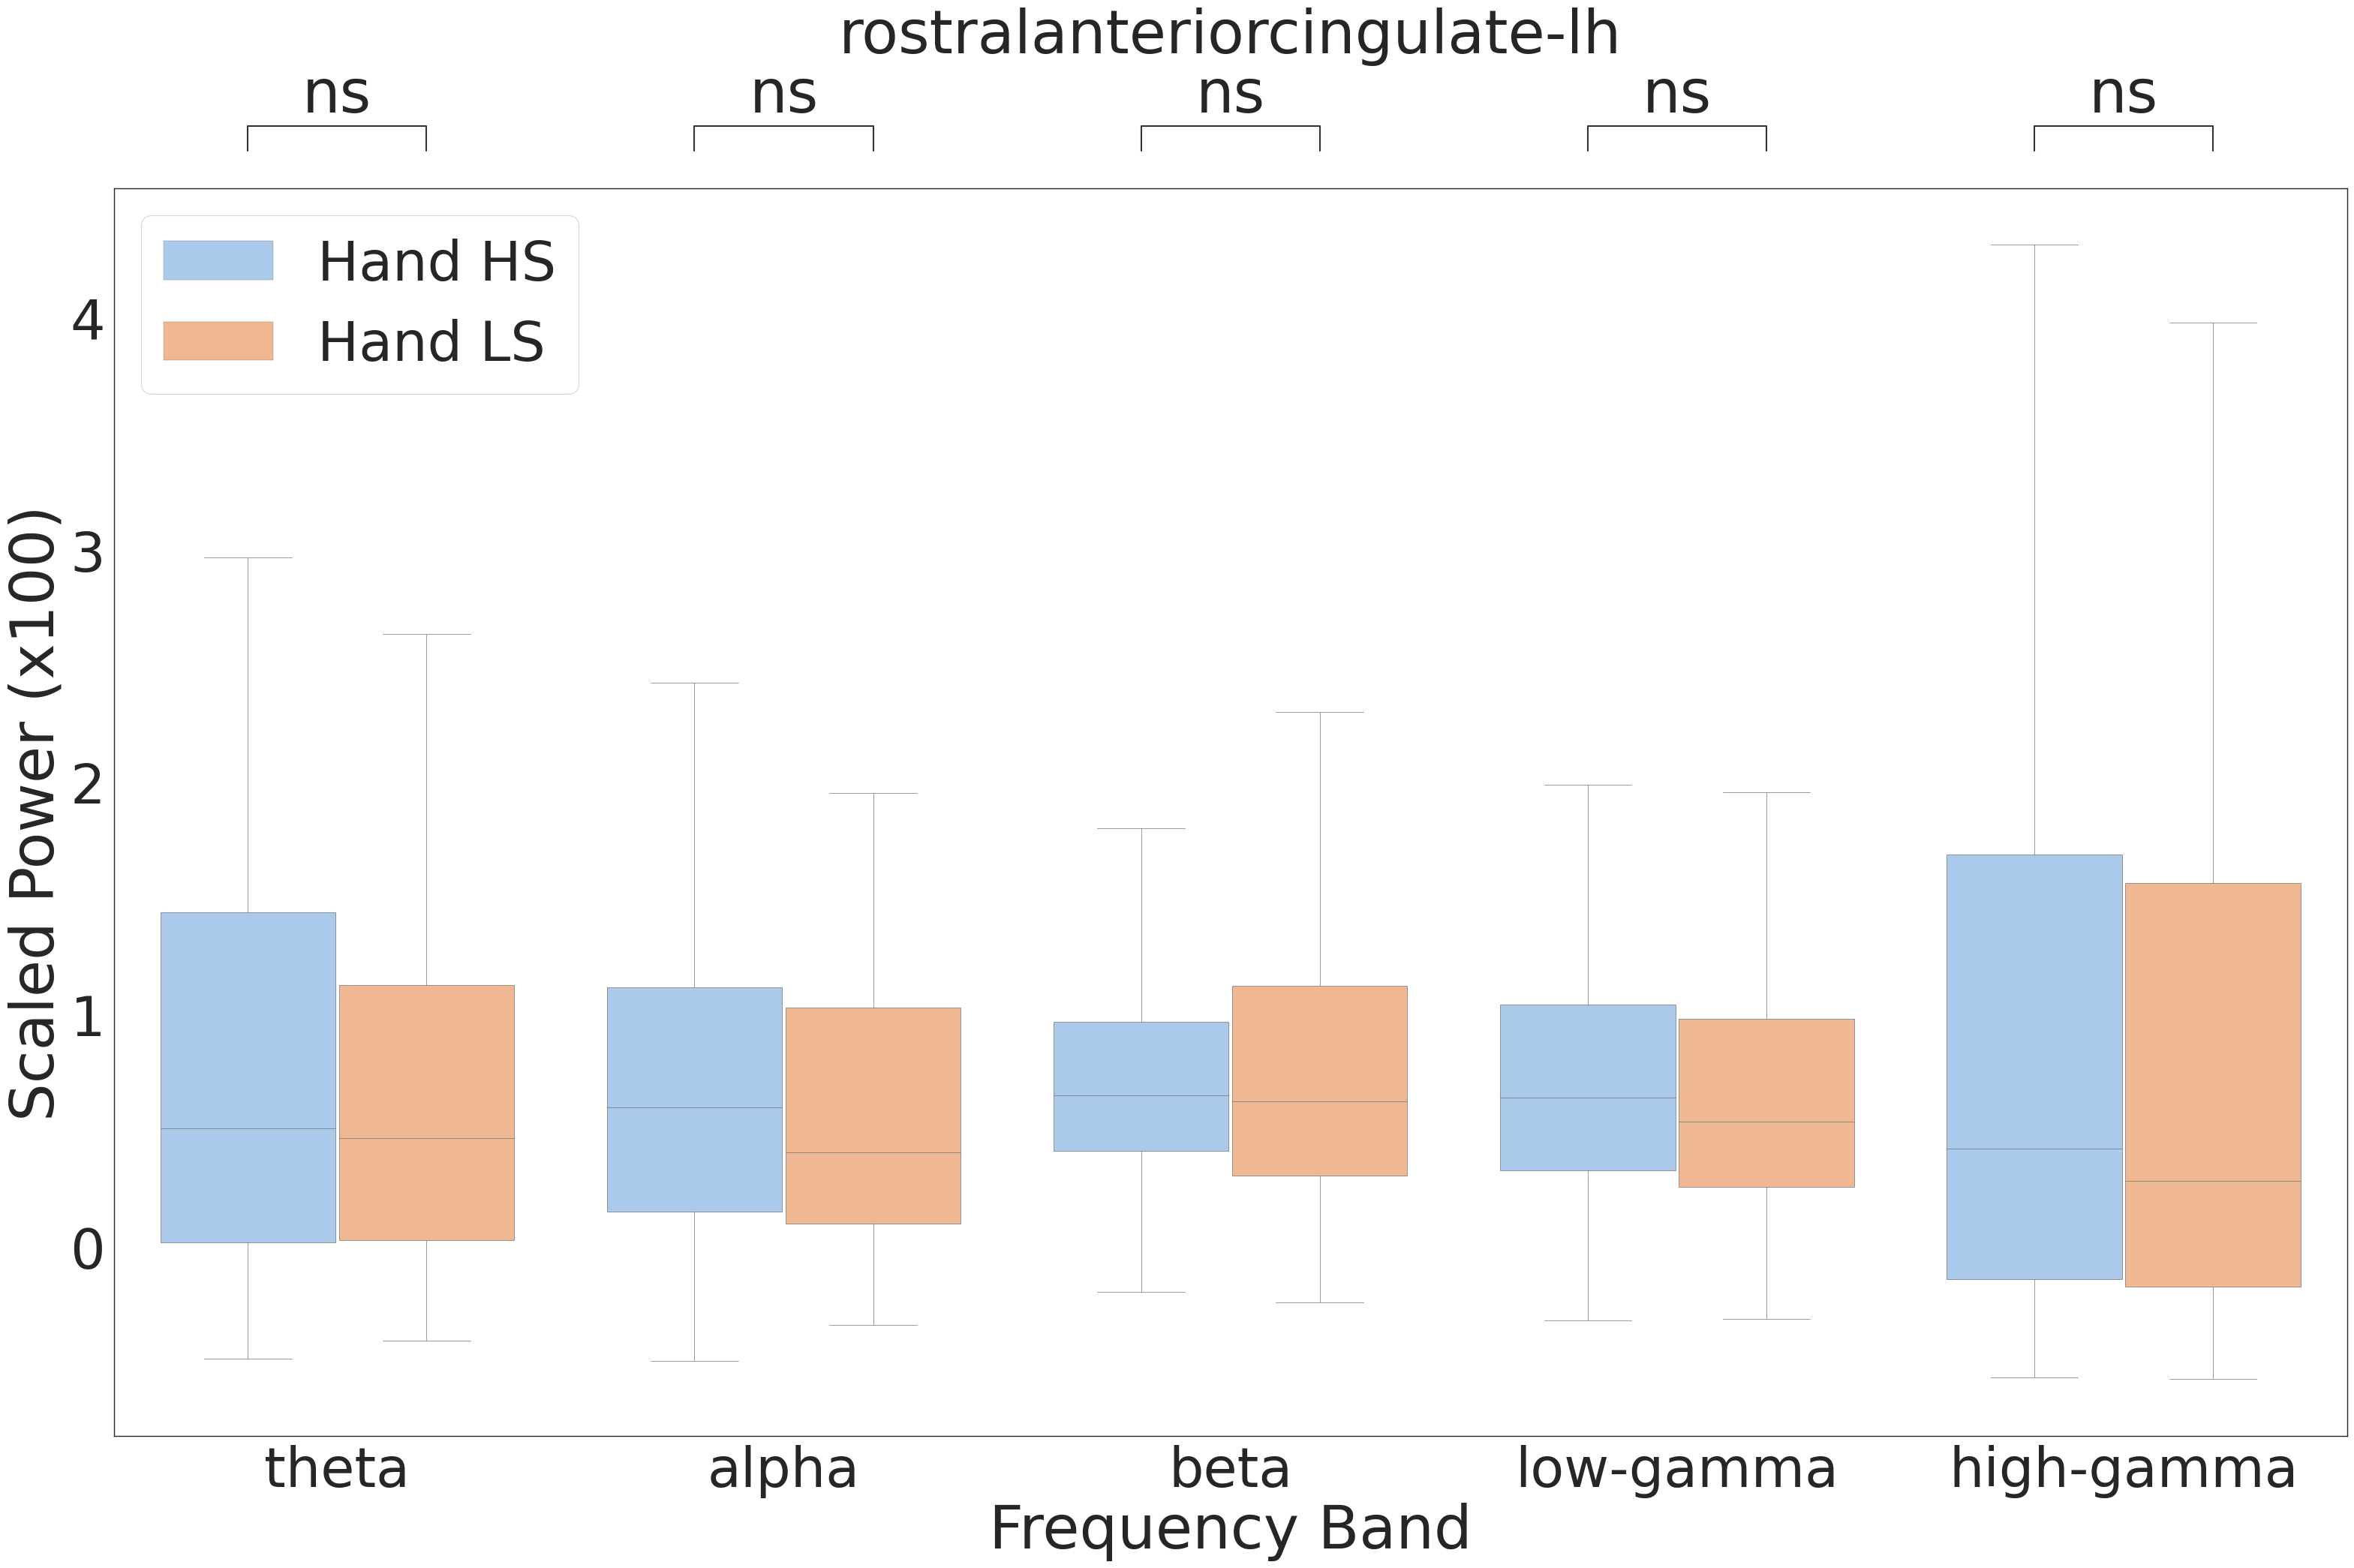

<Figure size 640x480 with 0 Axes>

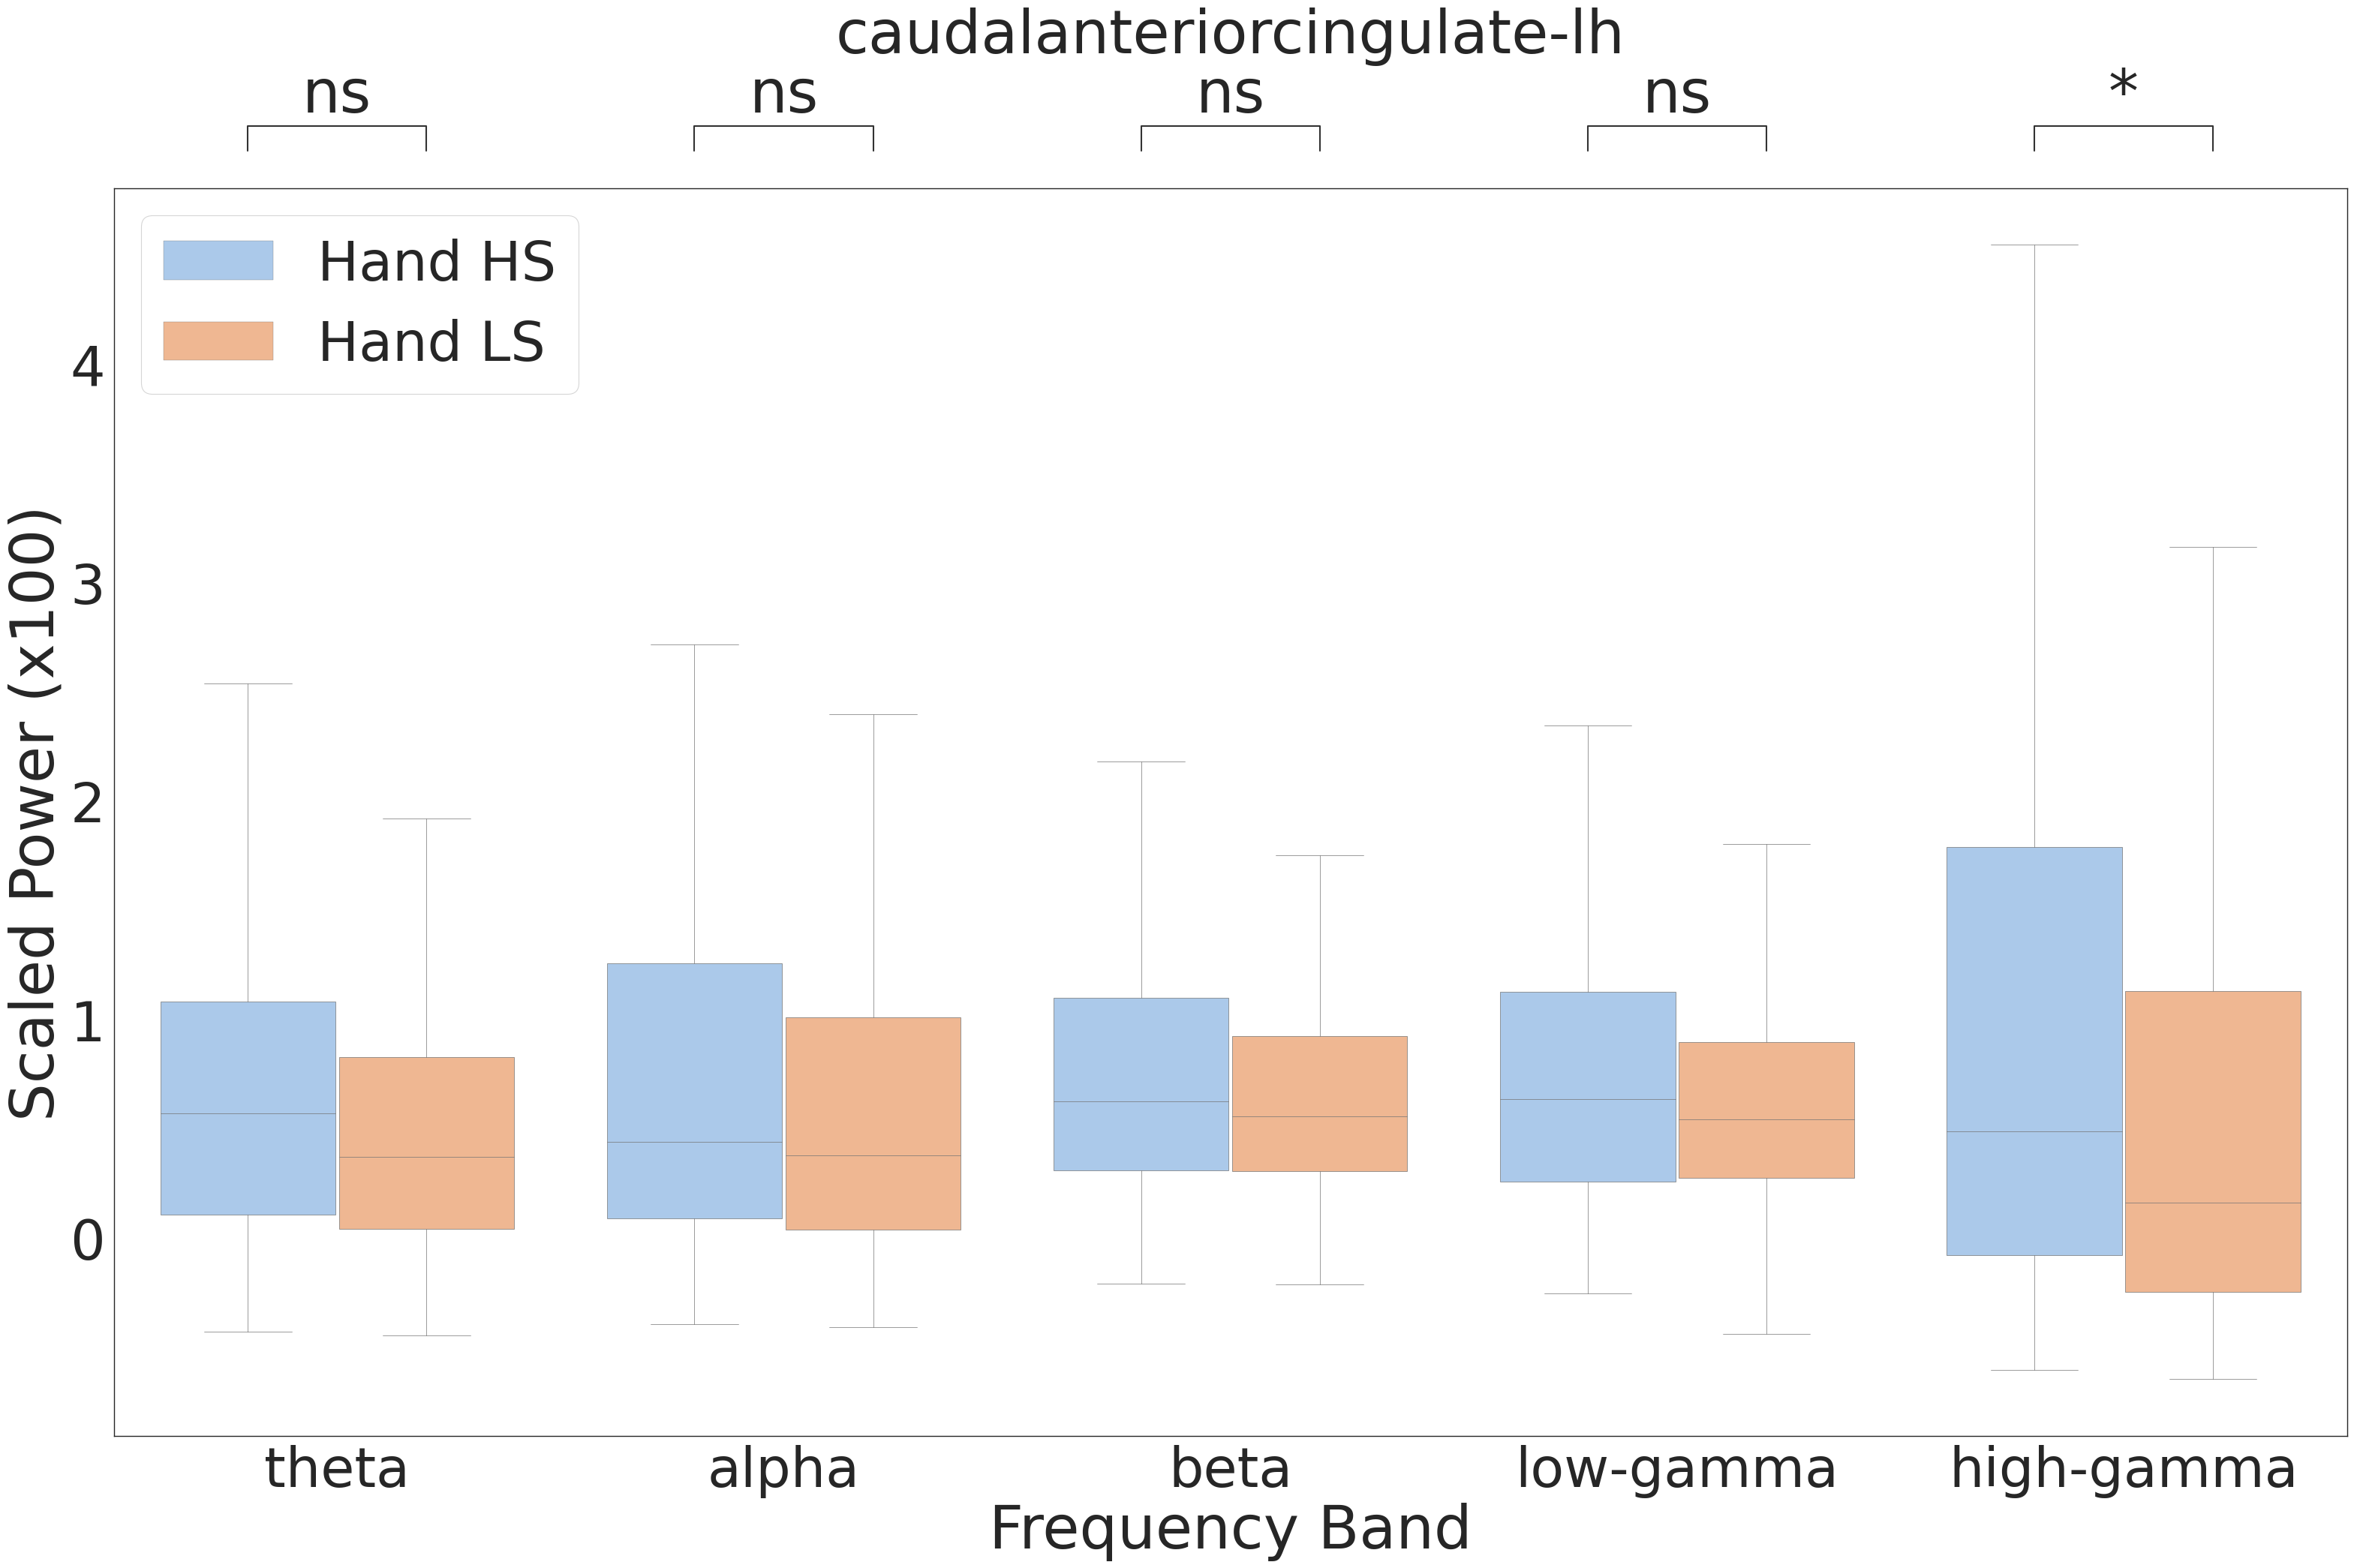

<Figure size 640x480 with 0 Axes>

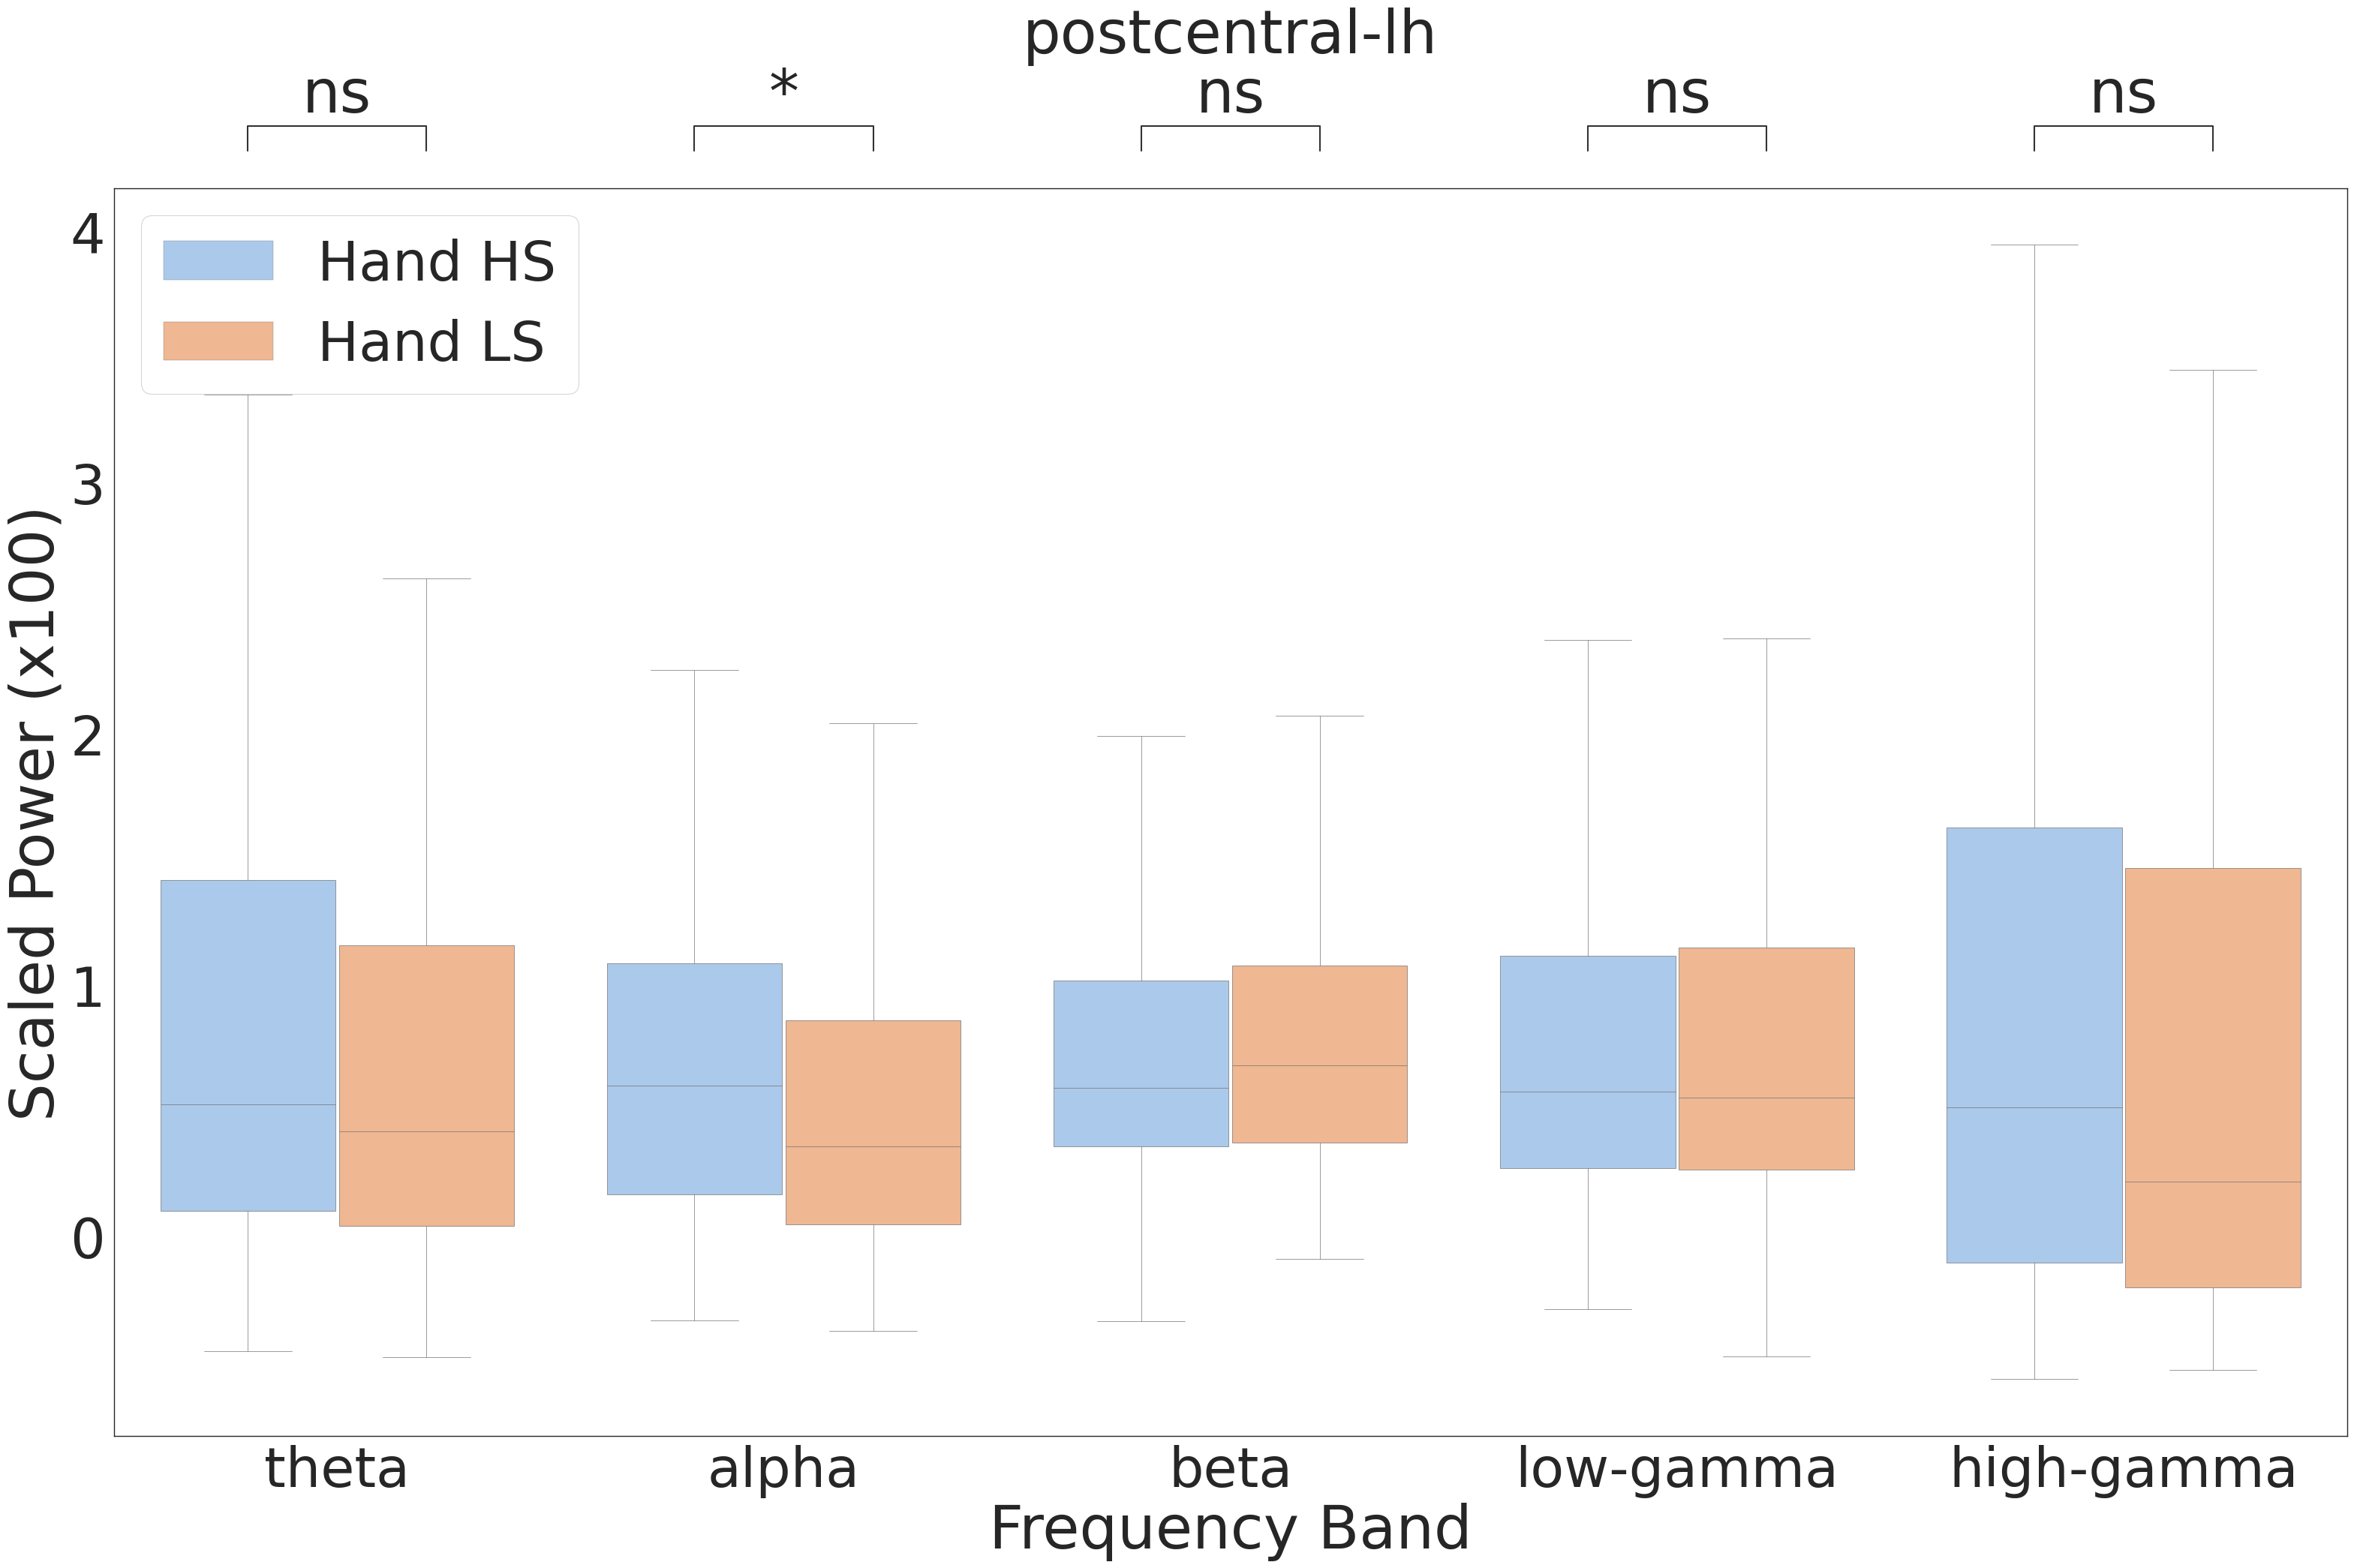

<Figure size 640x480 with 0 Axes>

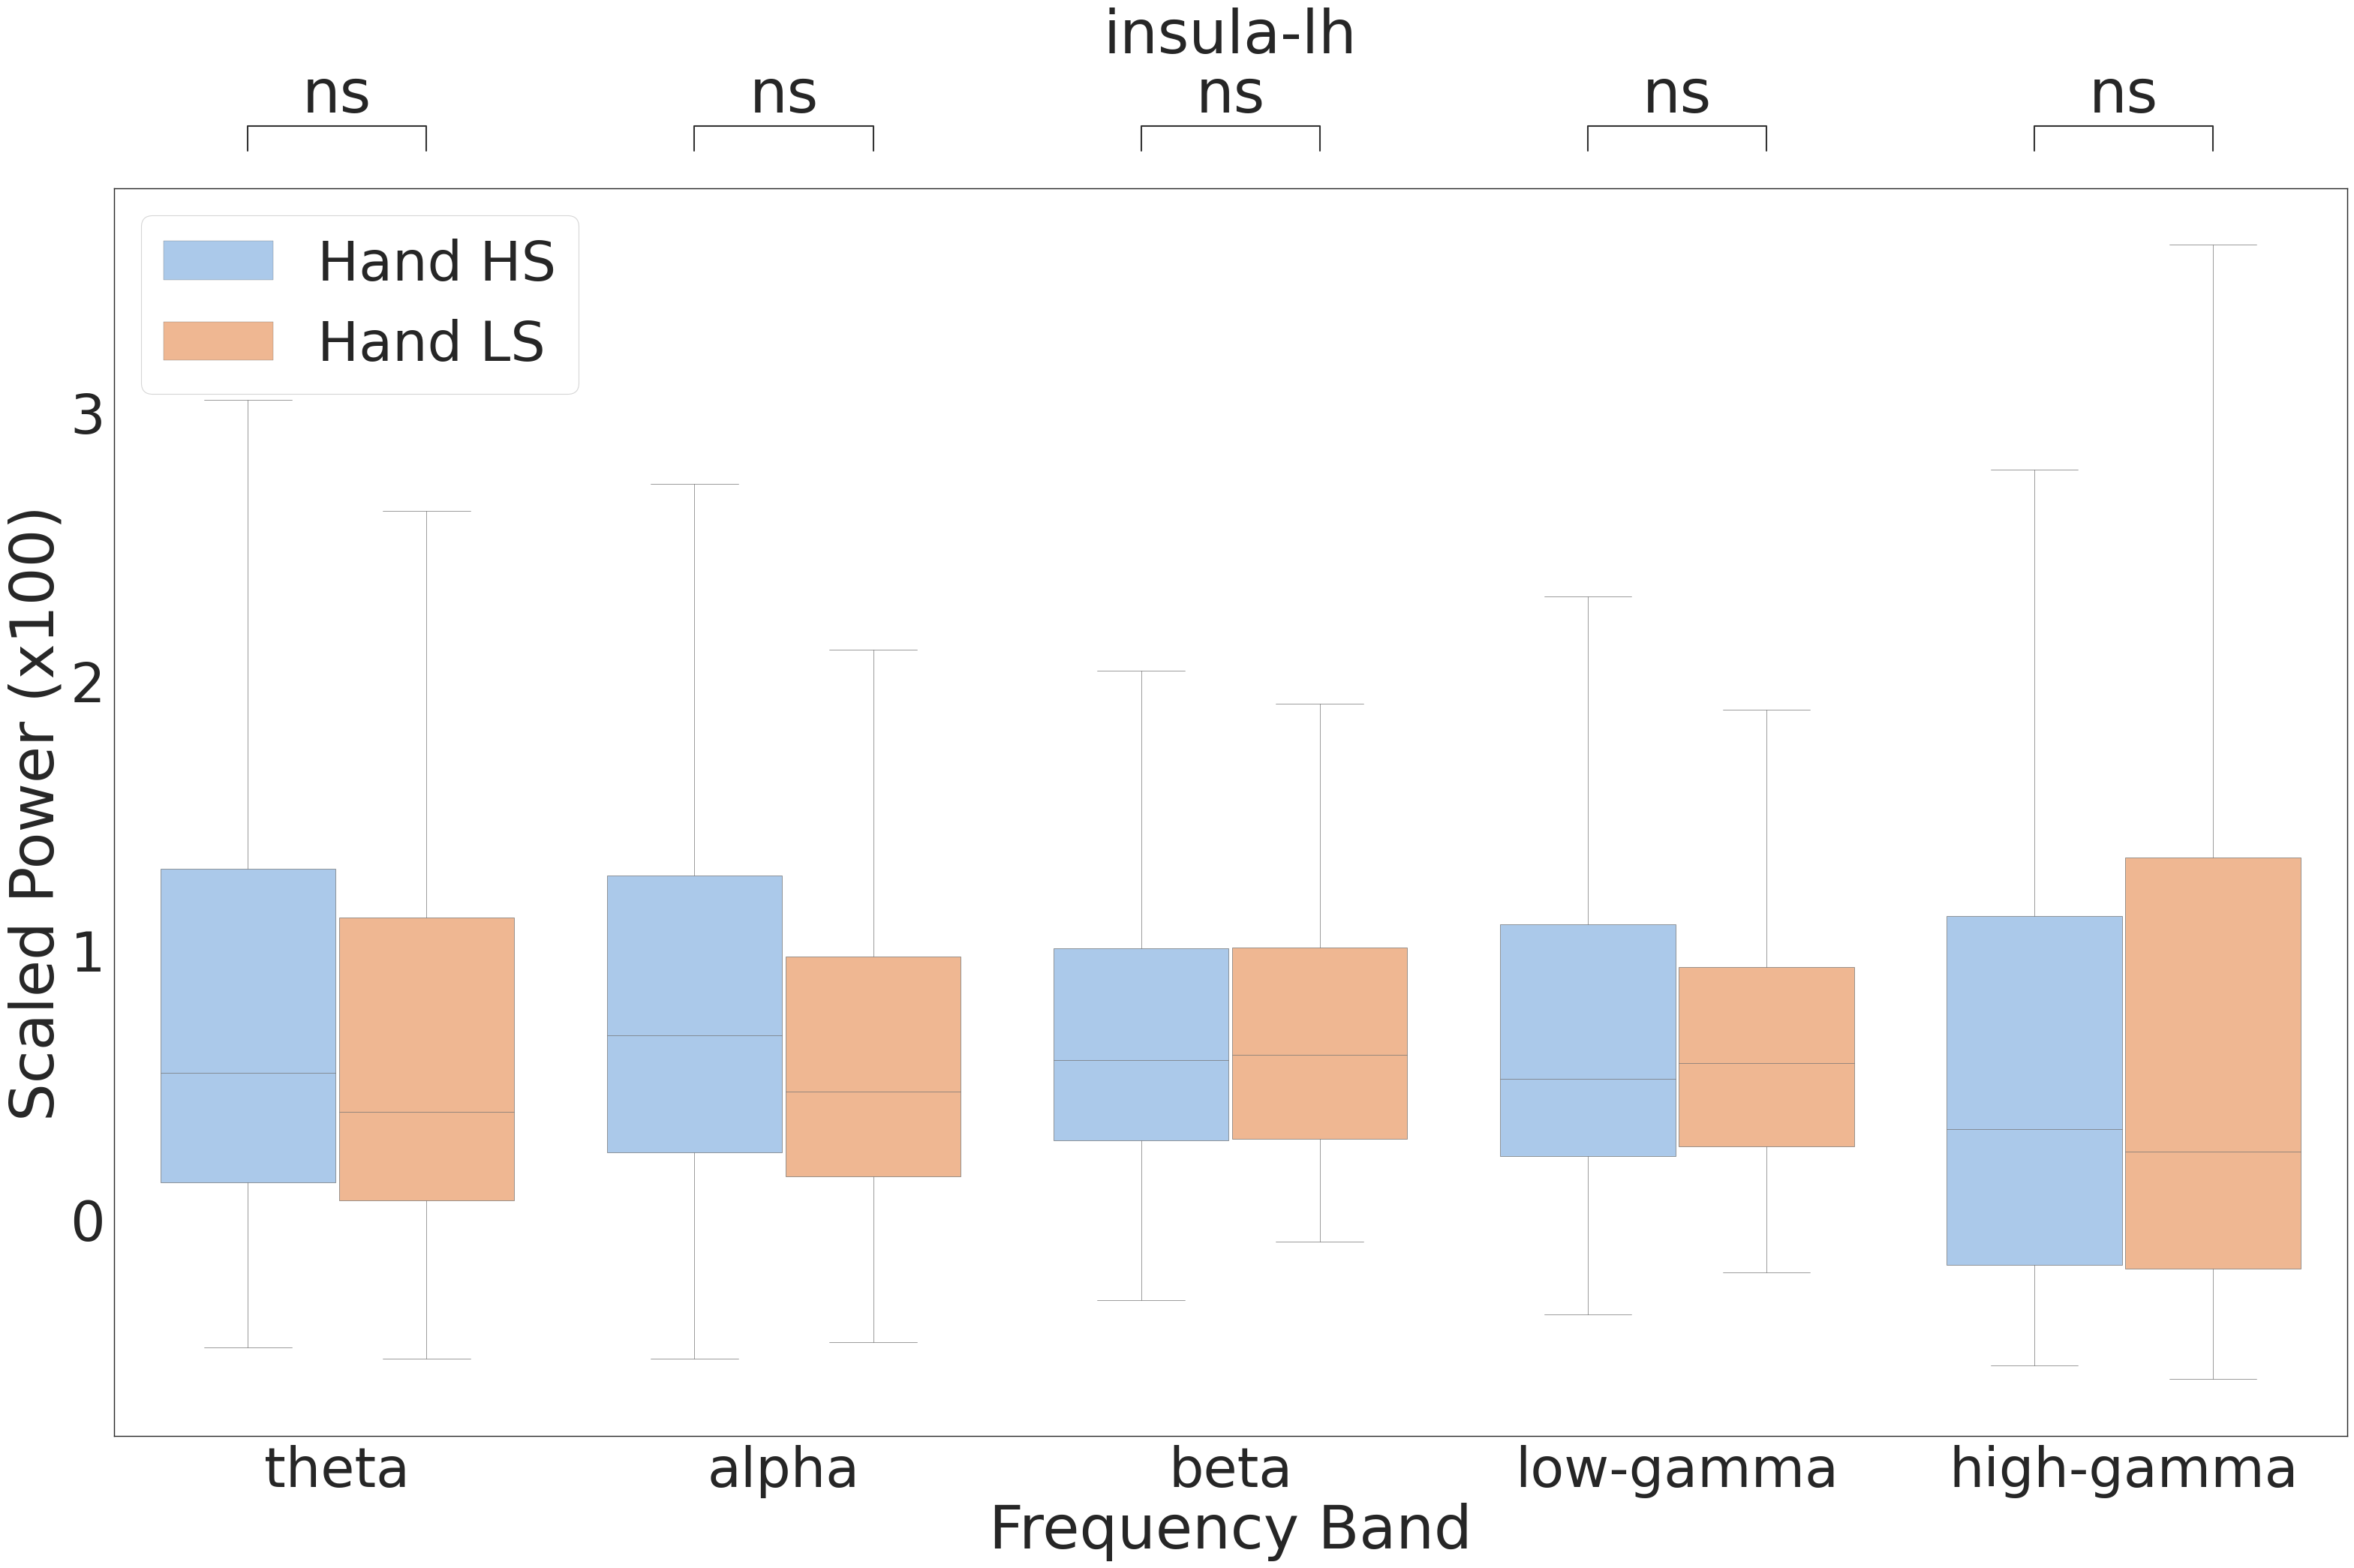

<Figure size 640x480 with 0 Axes>

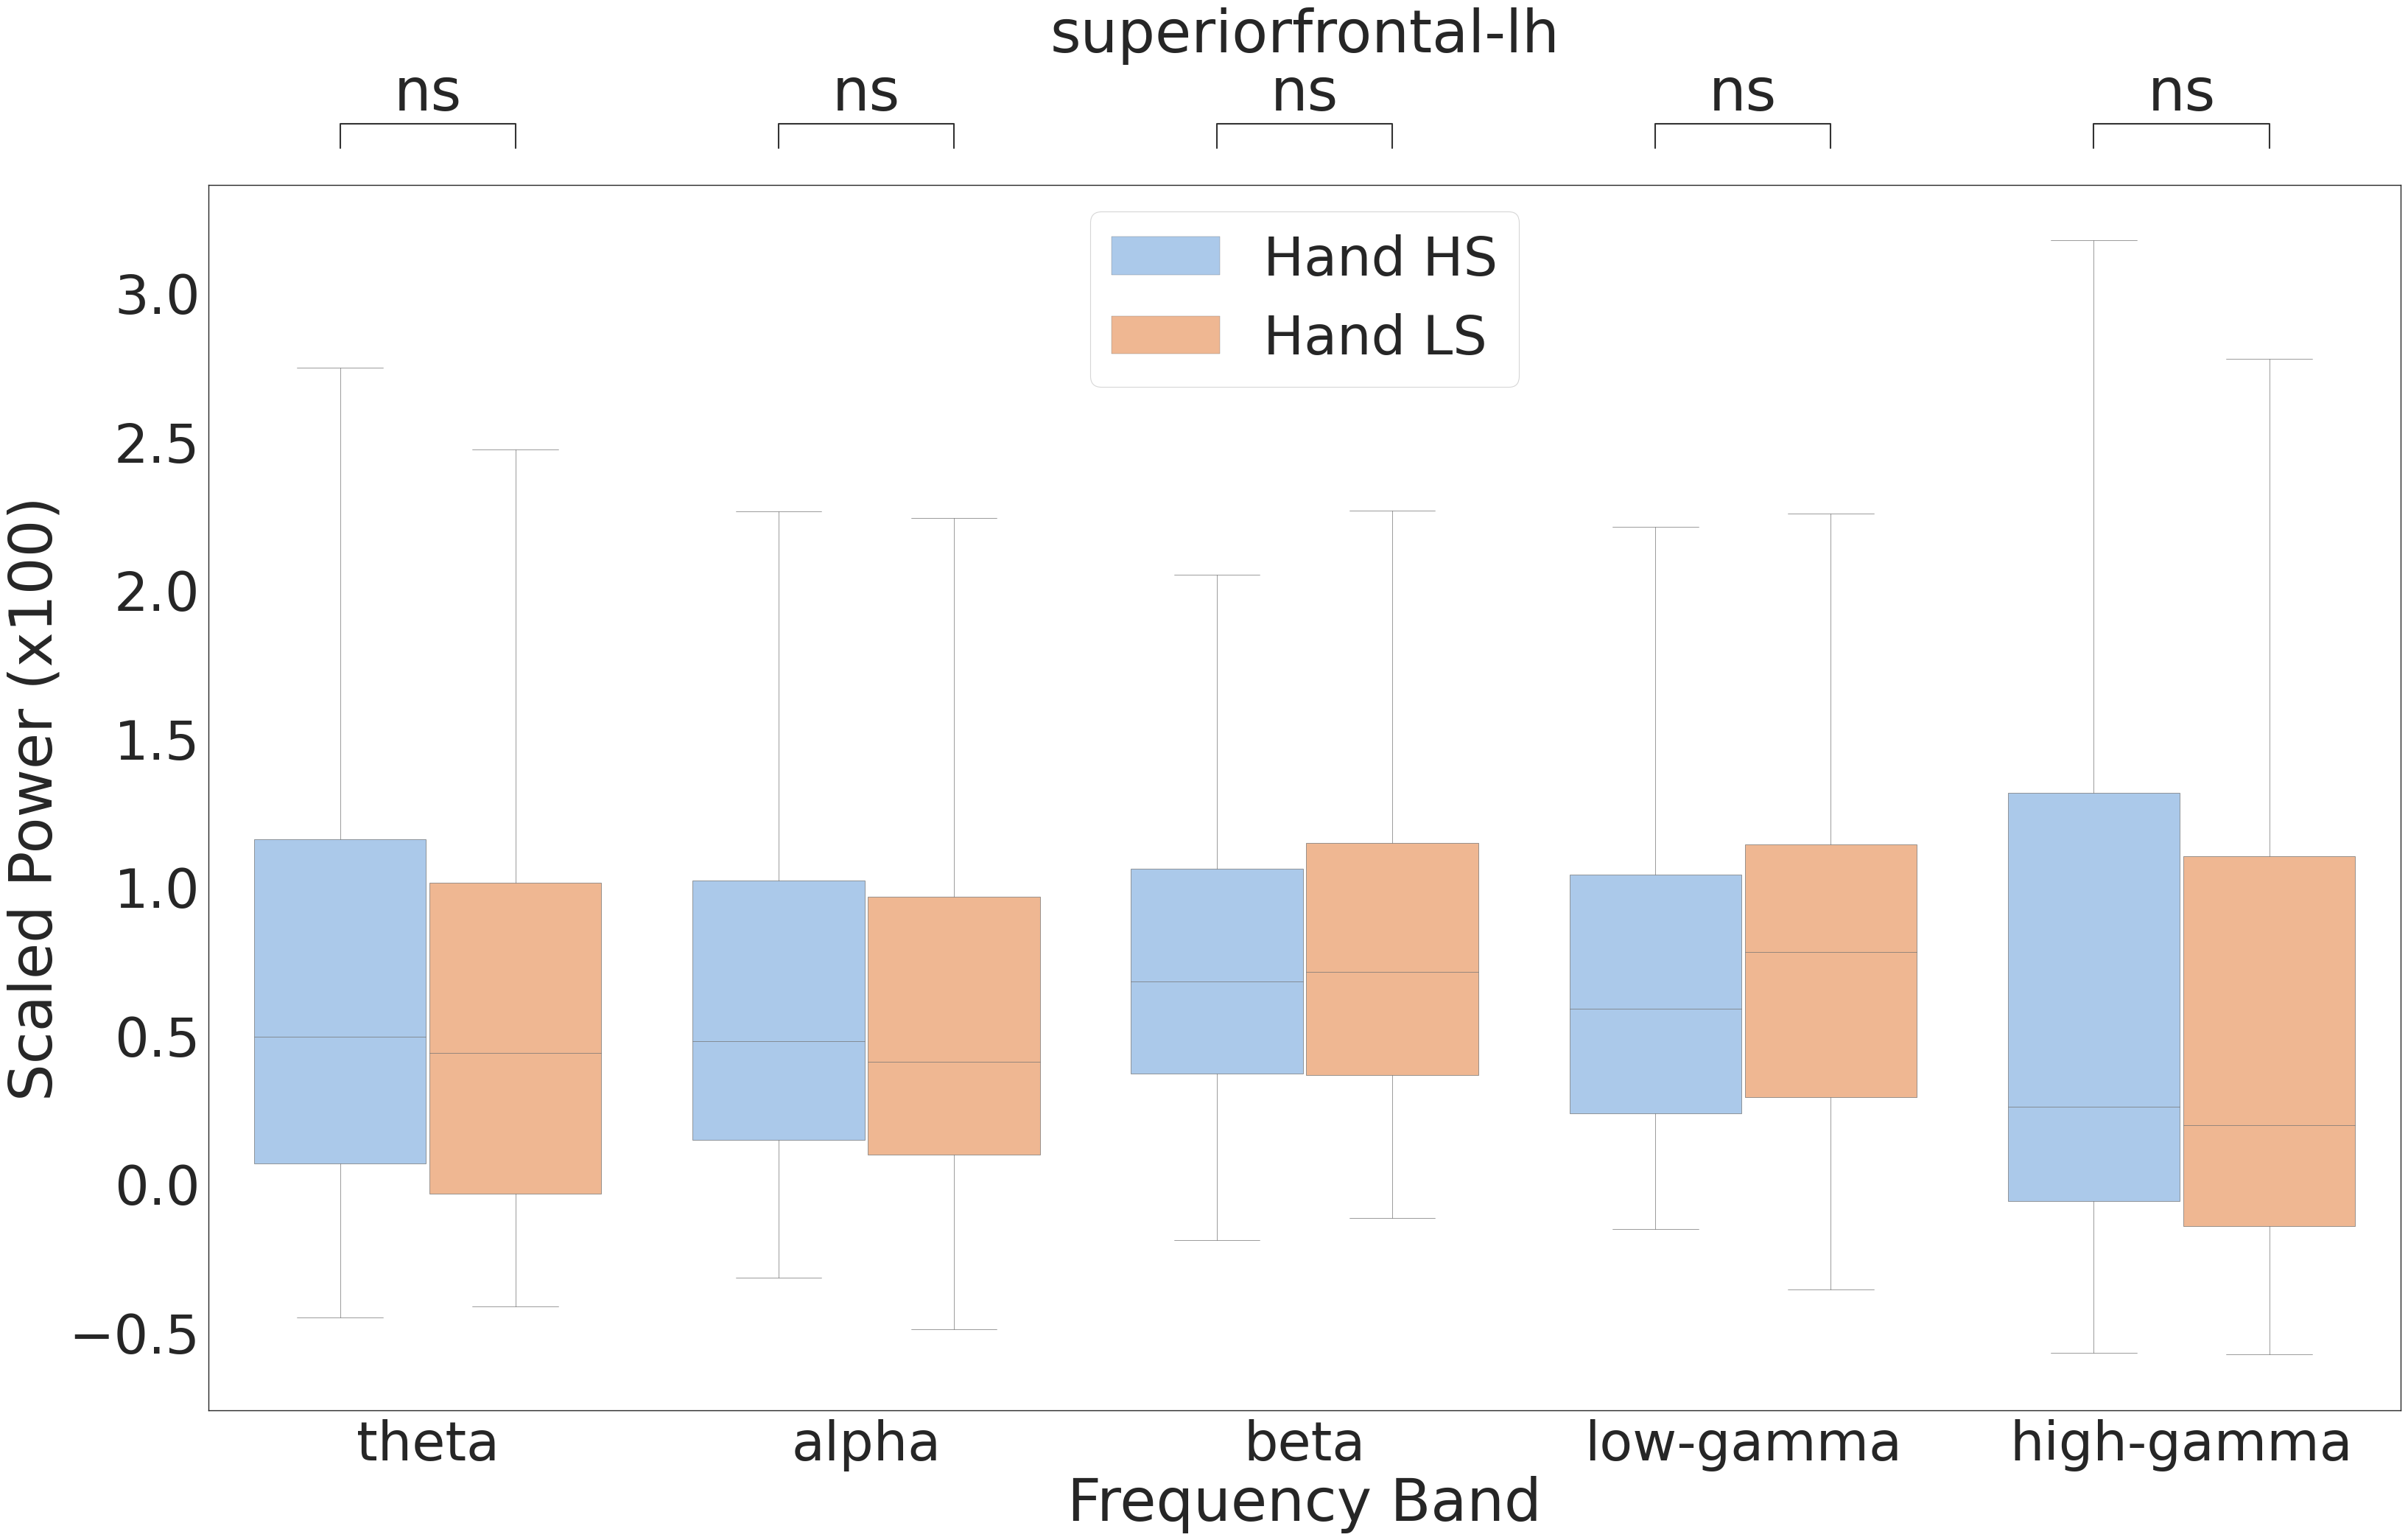

<Figure size 640x480 with 0 Axes>

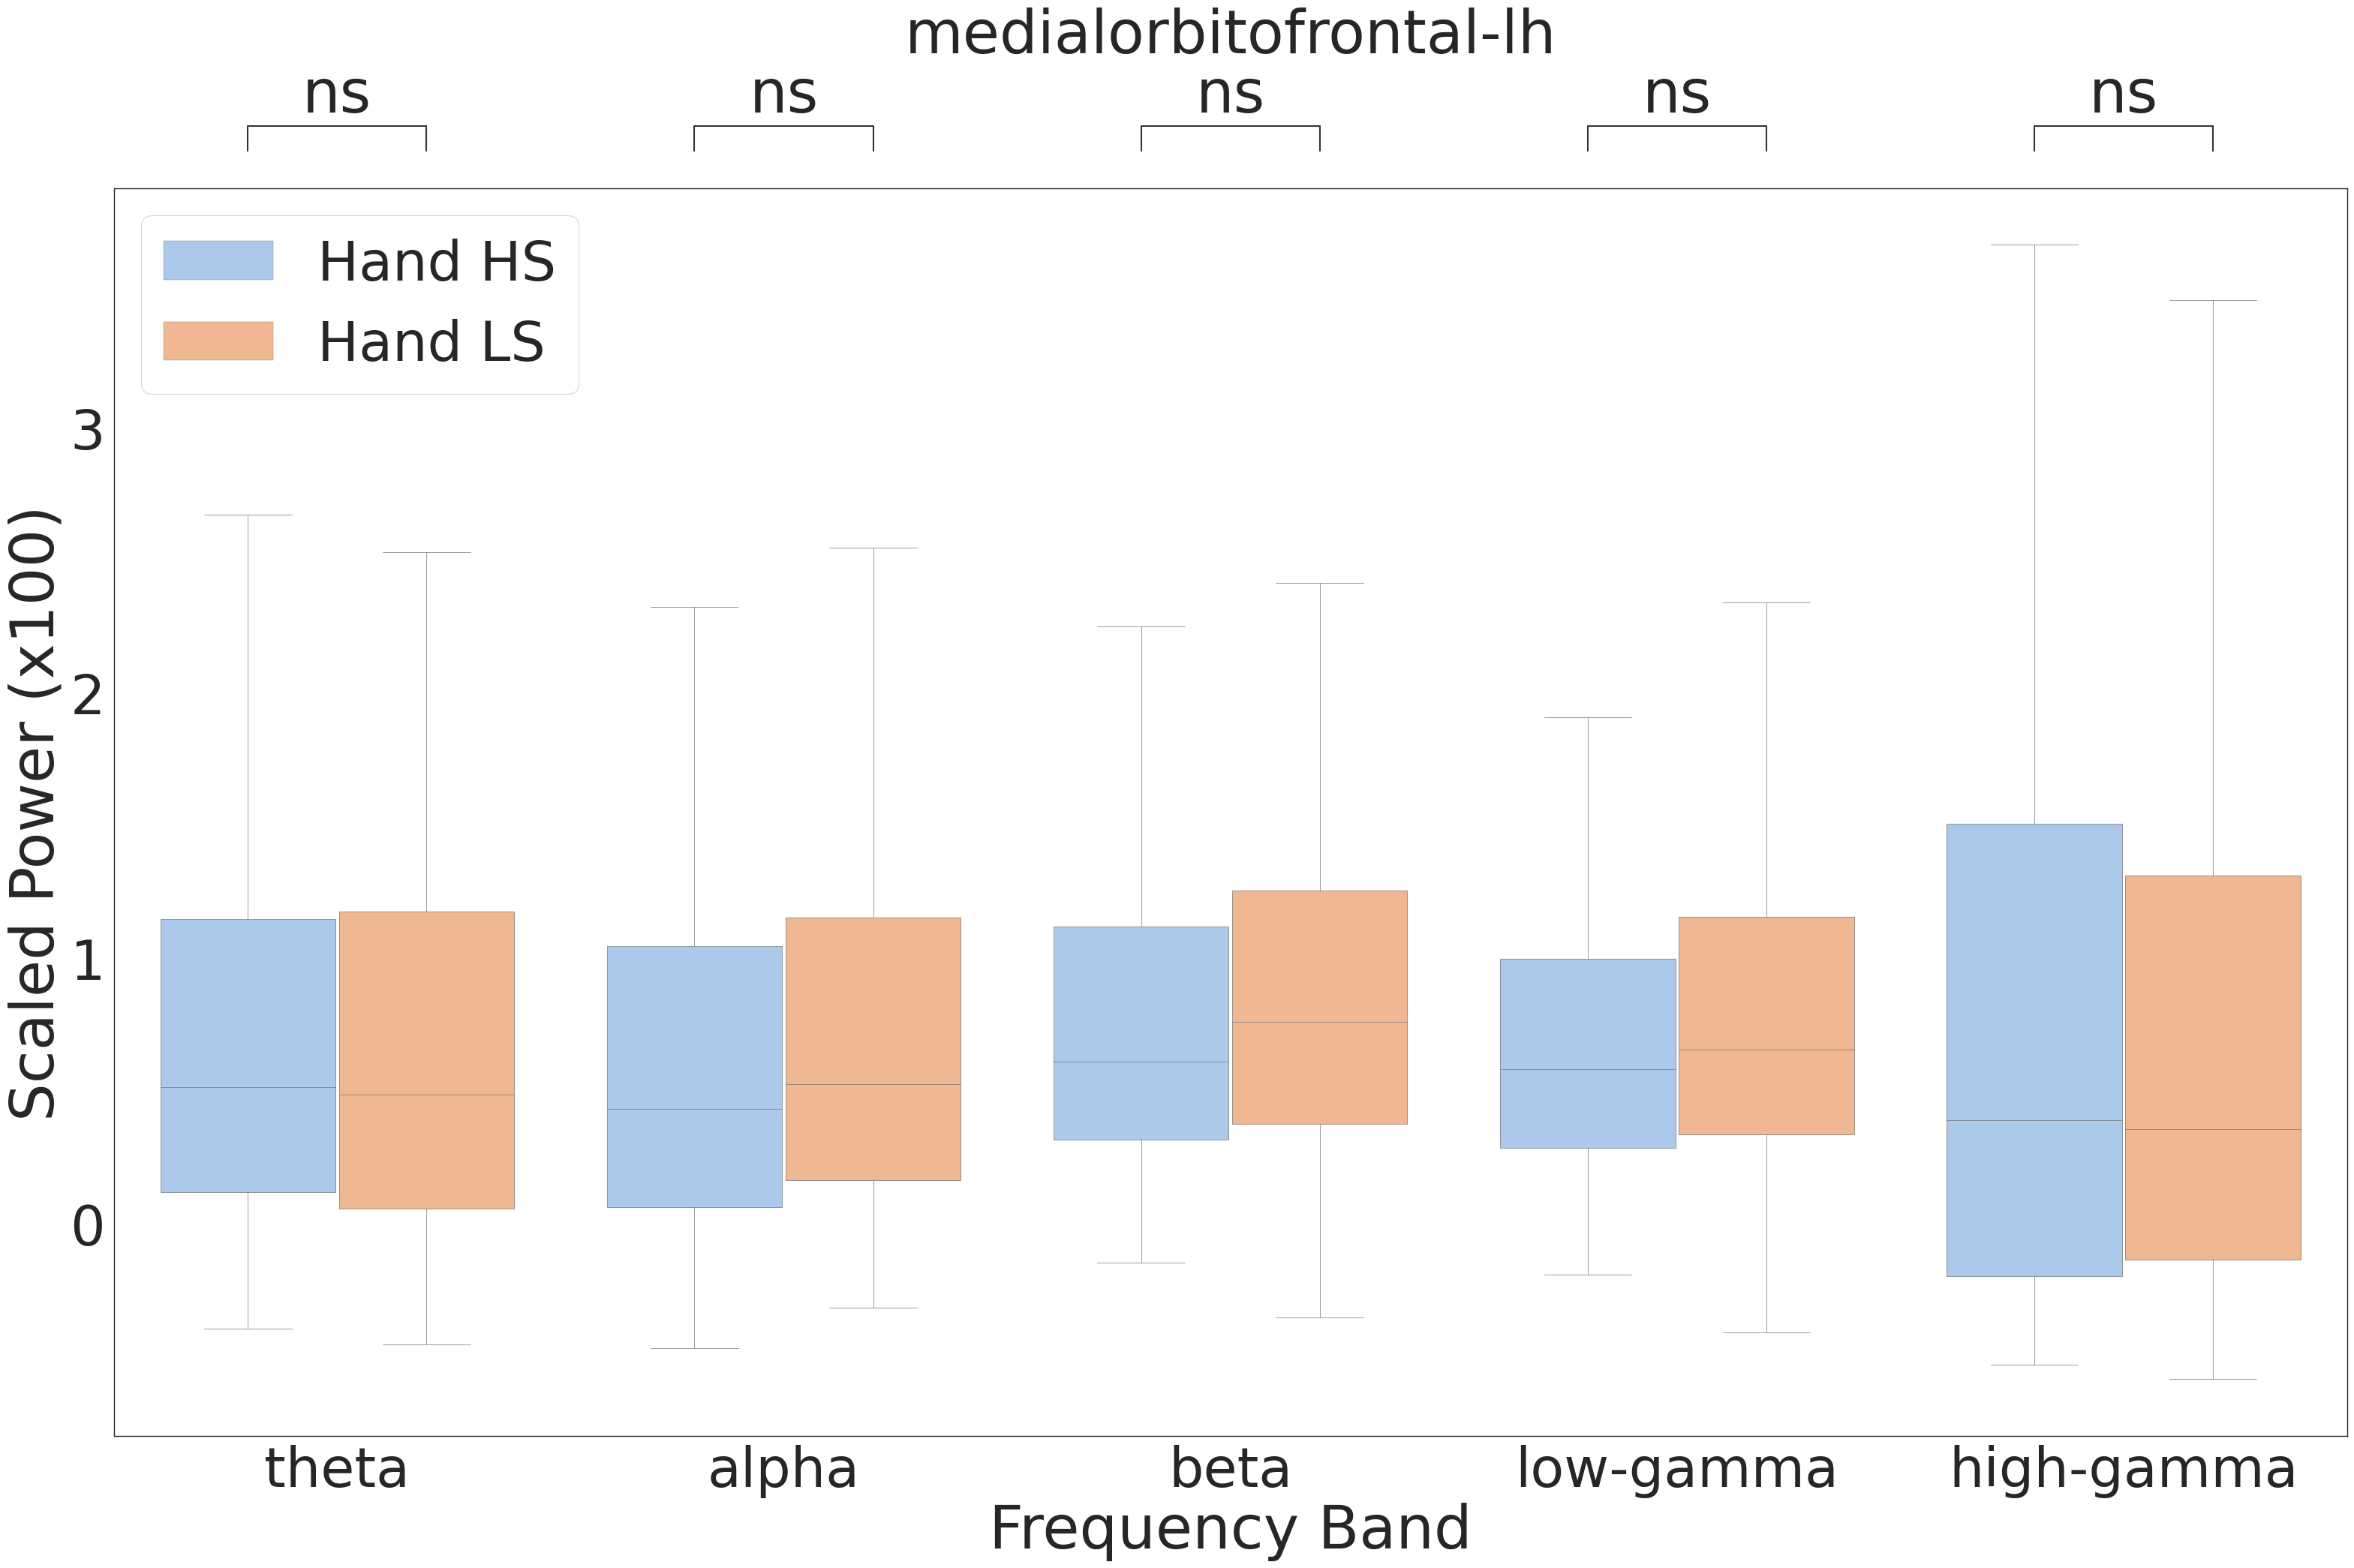

<Figure size 640x480 with 0 Axes>

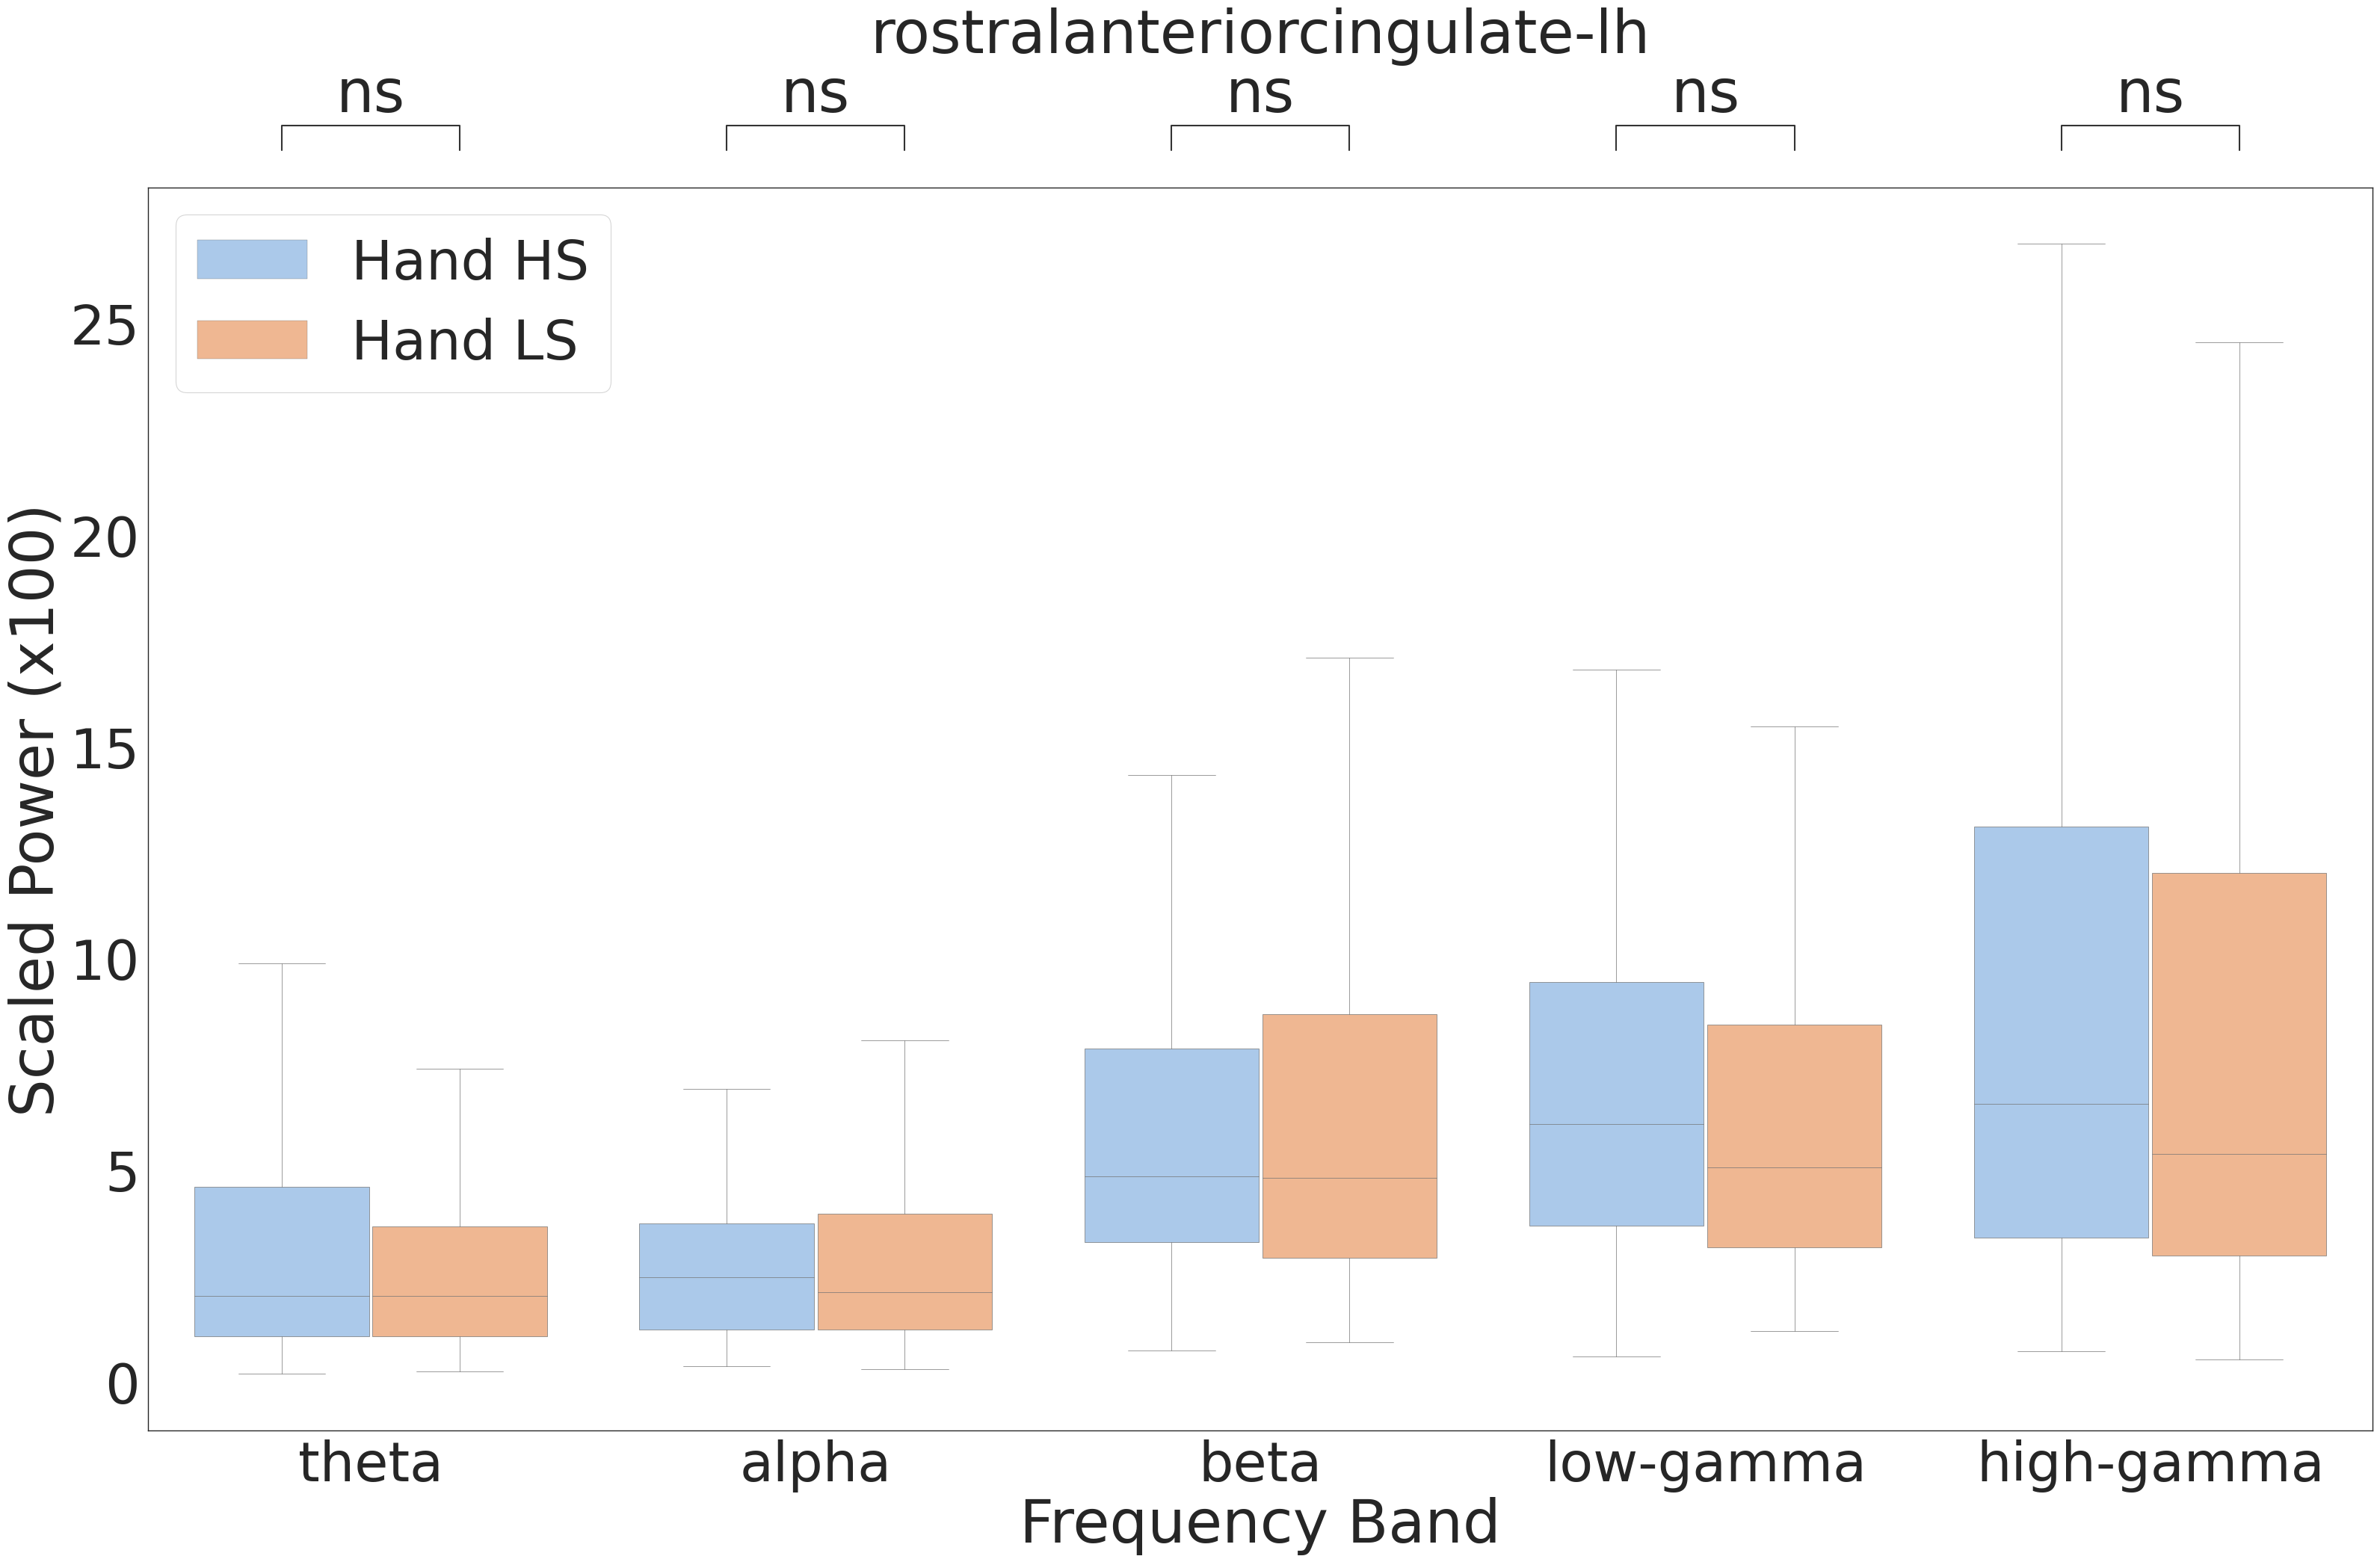

<Figure size 640x480 with 0 Axes>

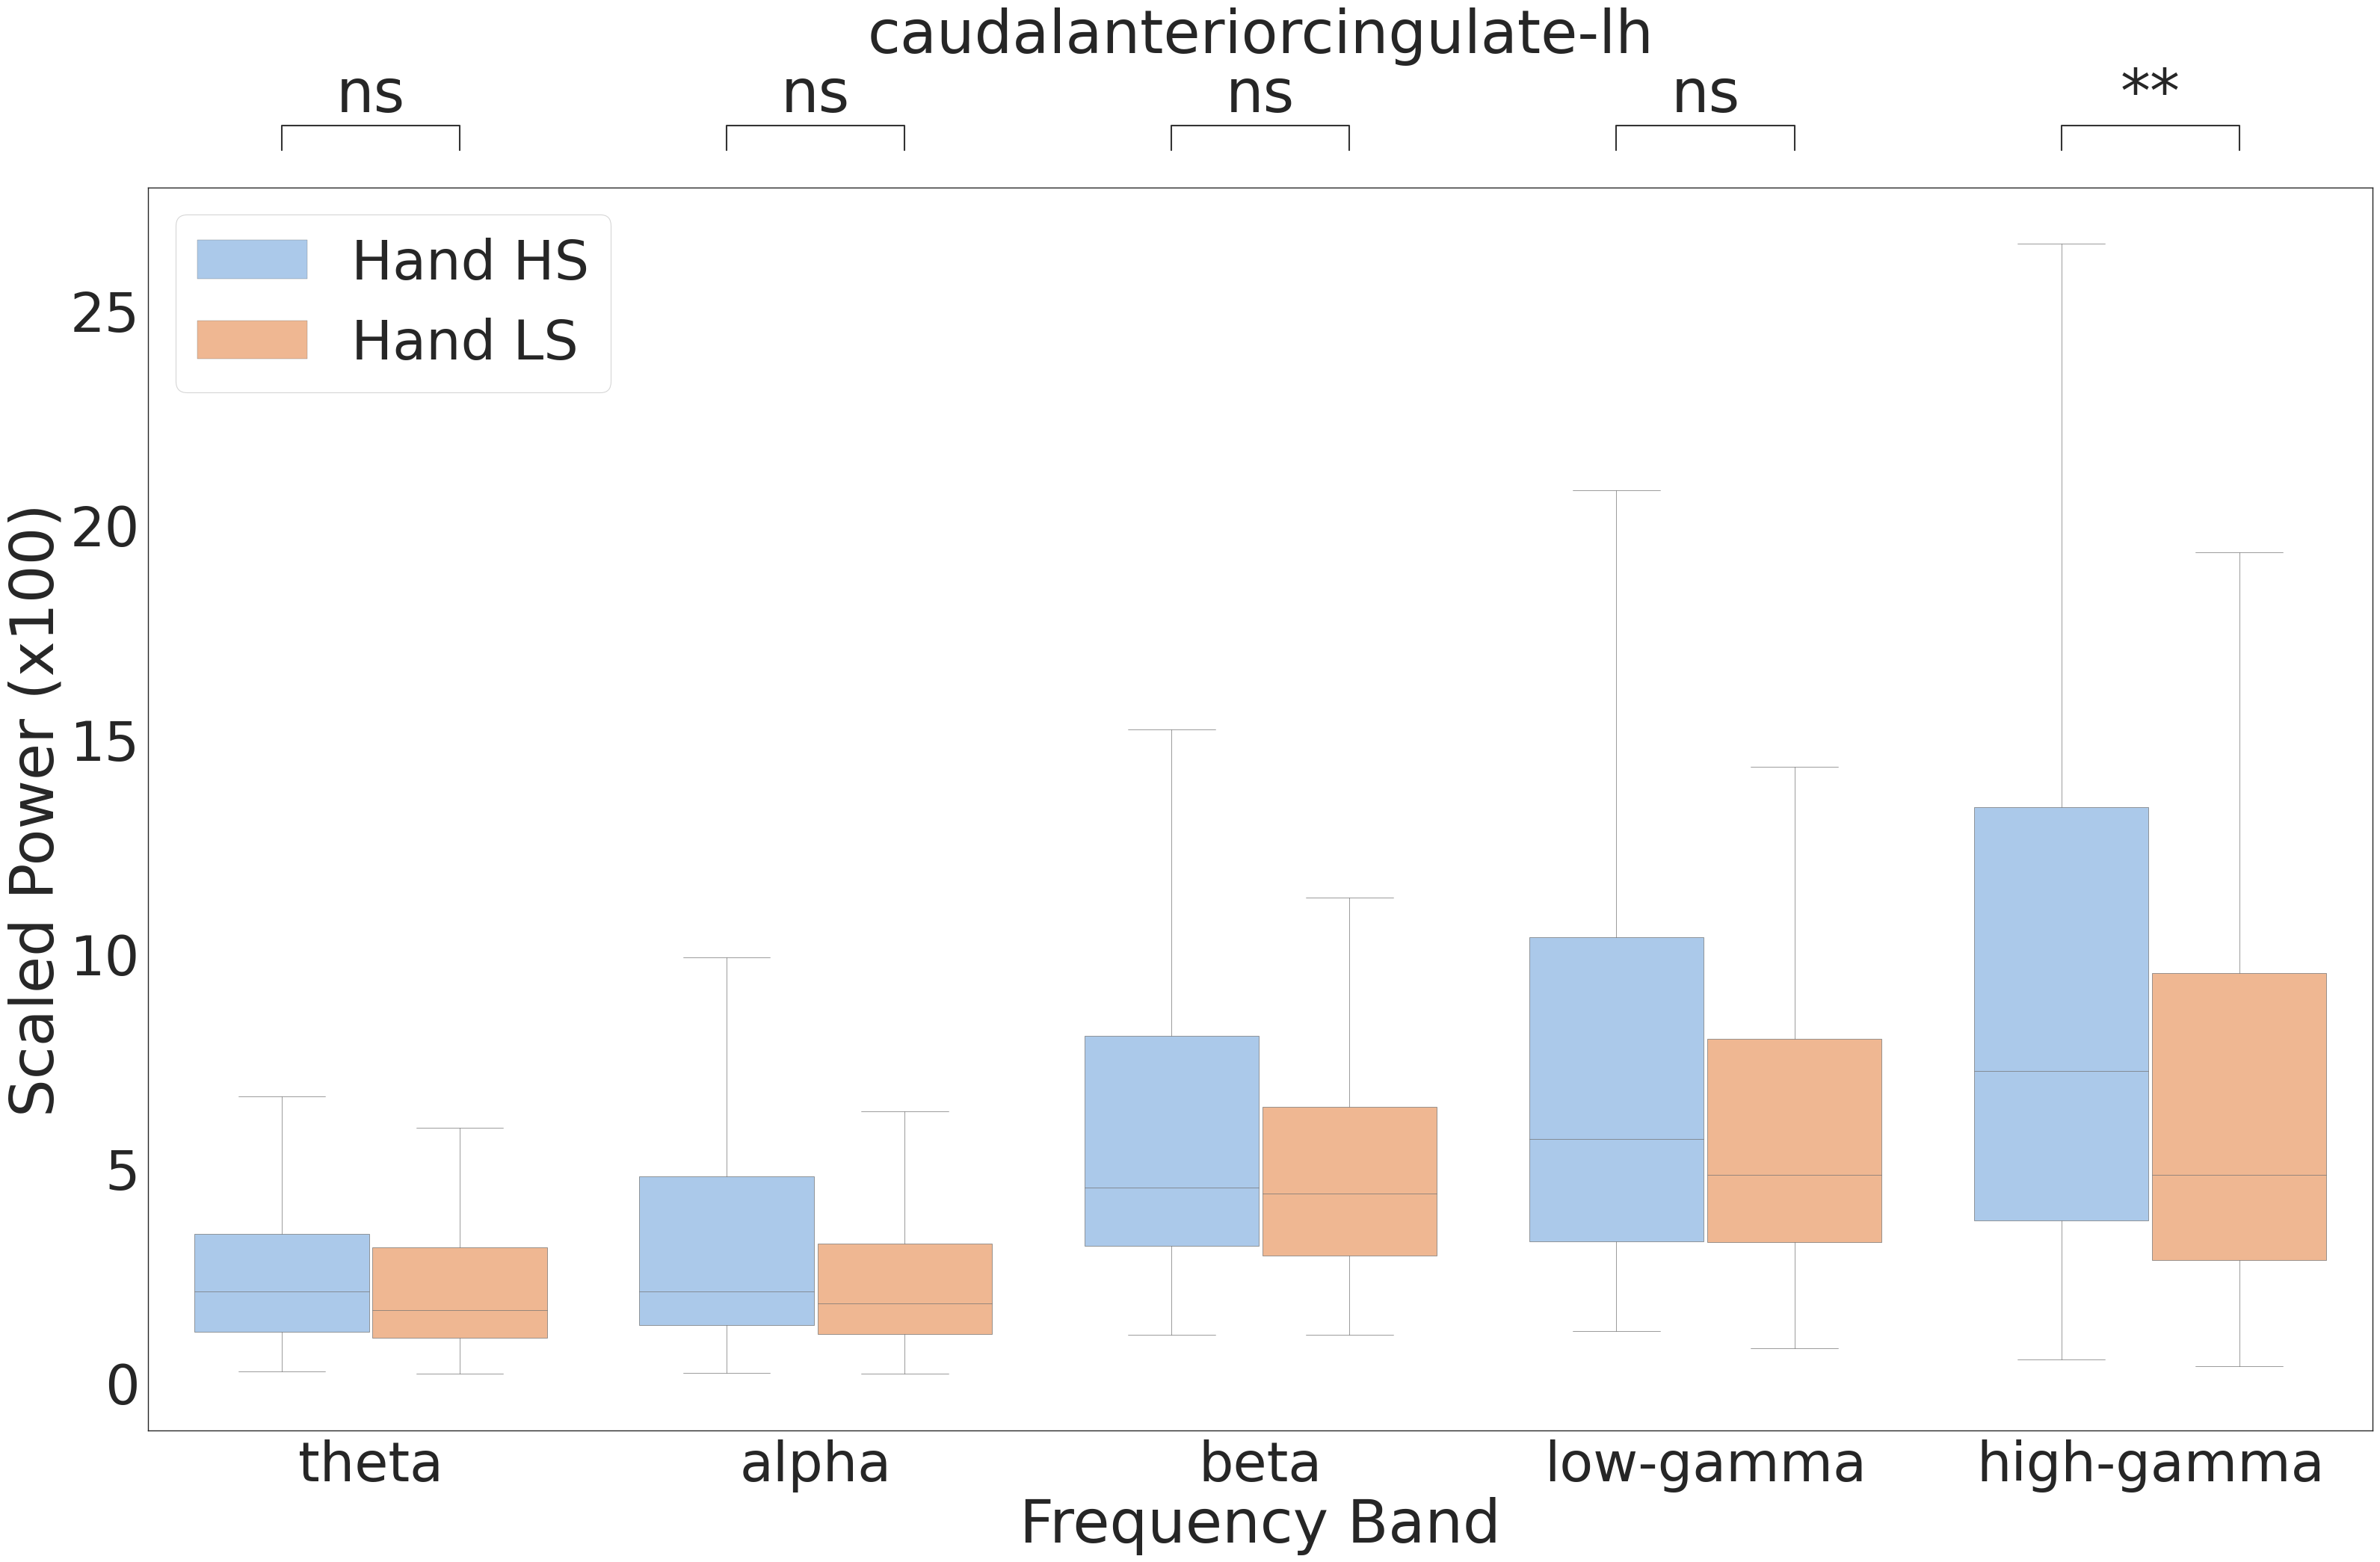

<Figure size 640x480 with 0 Axes>

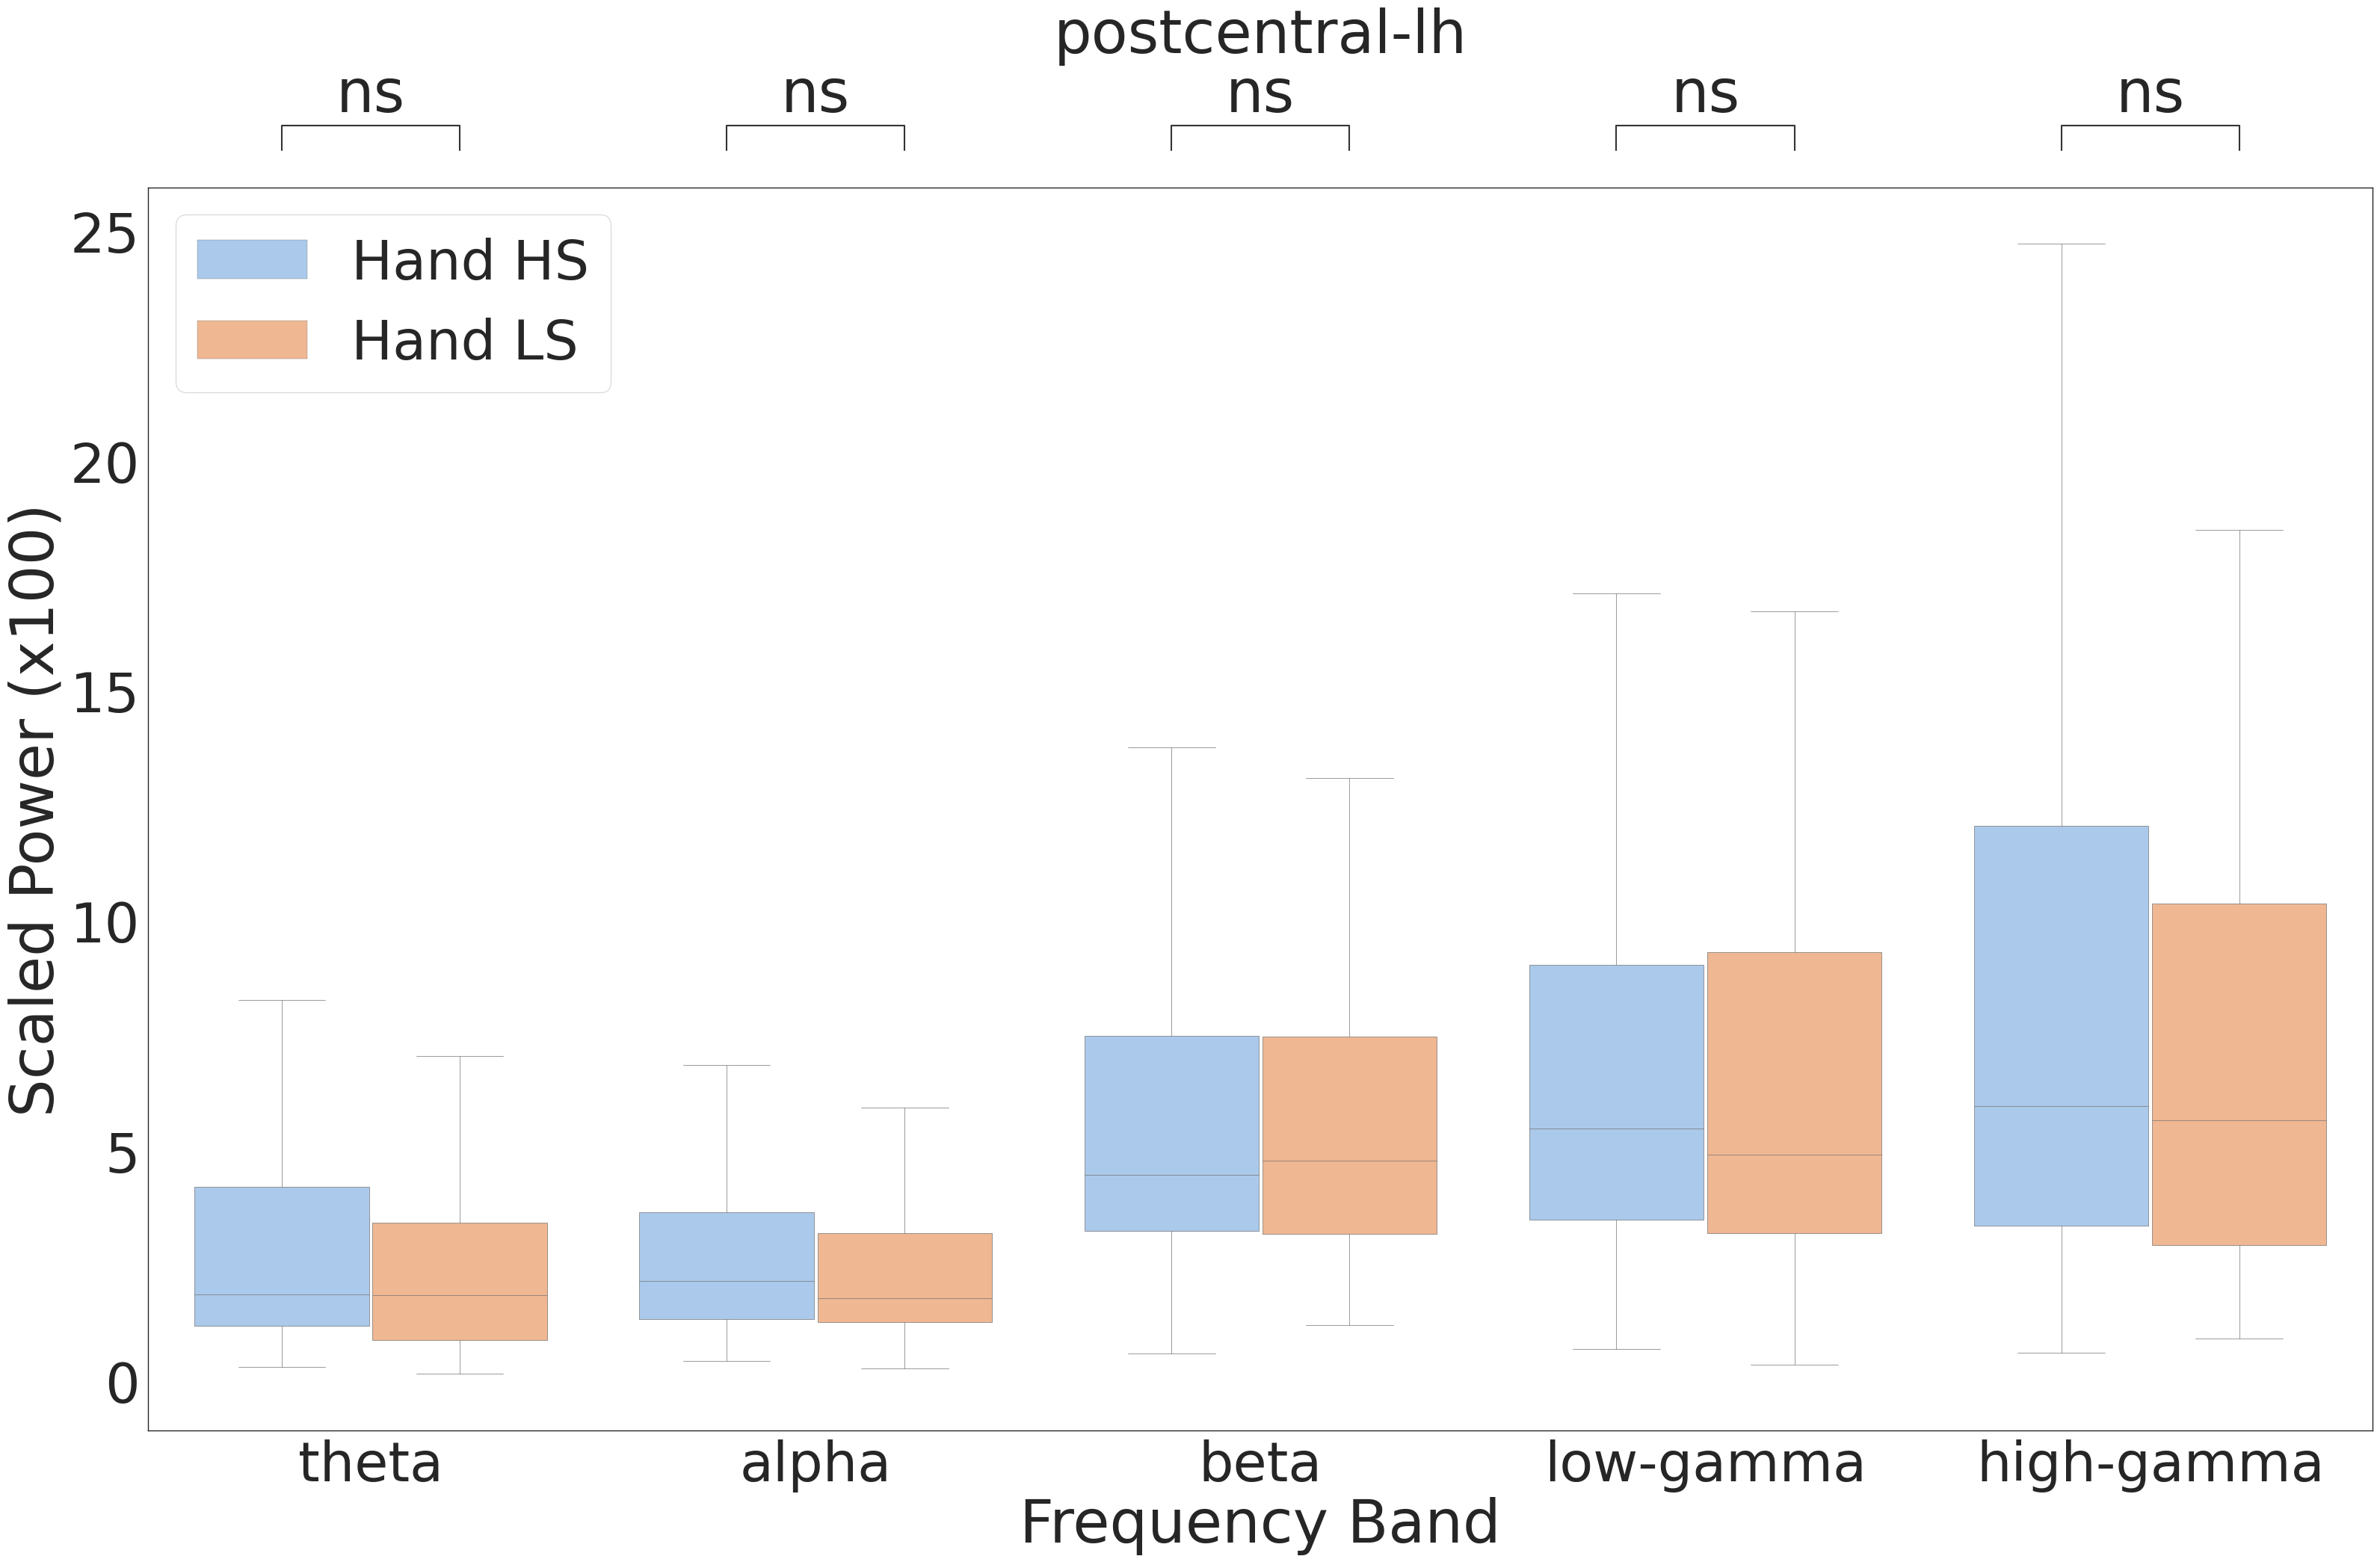

<Figure size 640x480 with 0 Axes>

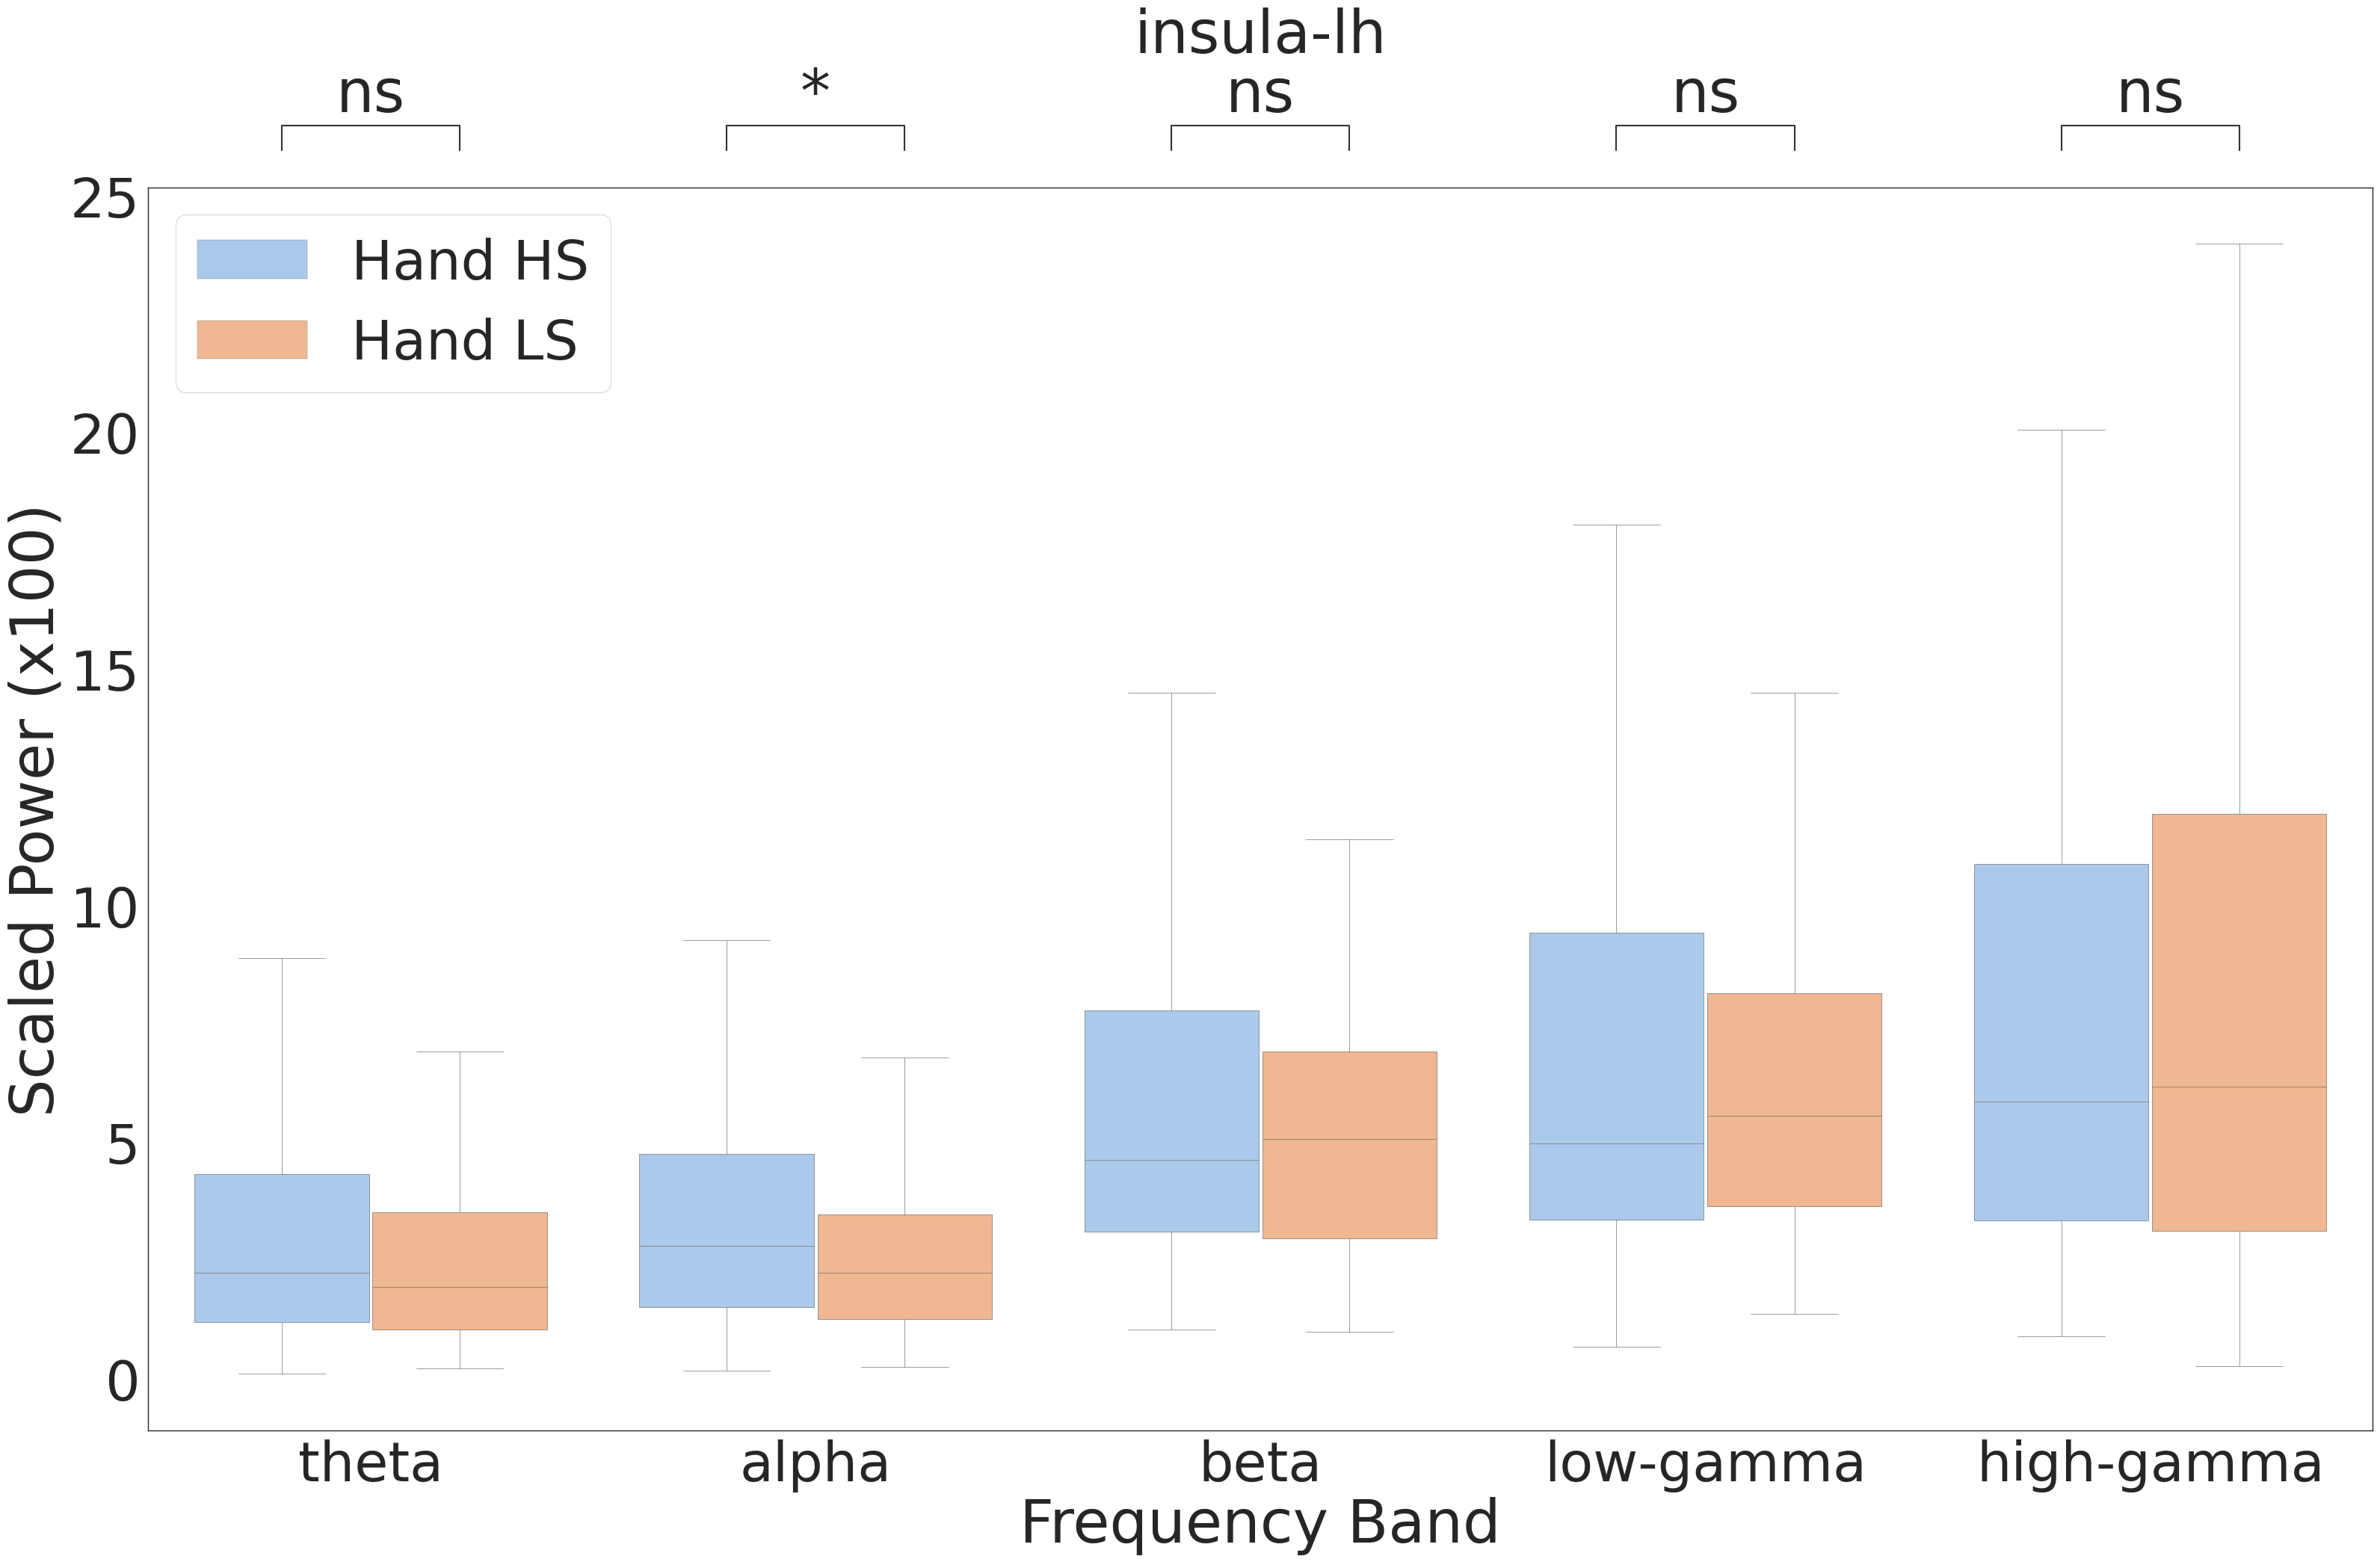

<Figure size 640x480 with 0 Axes>

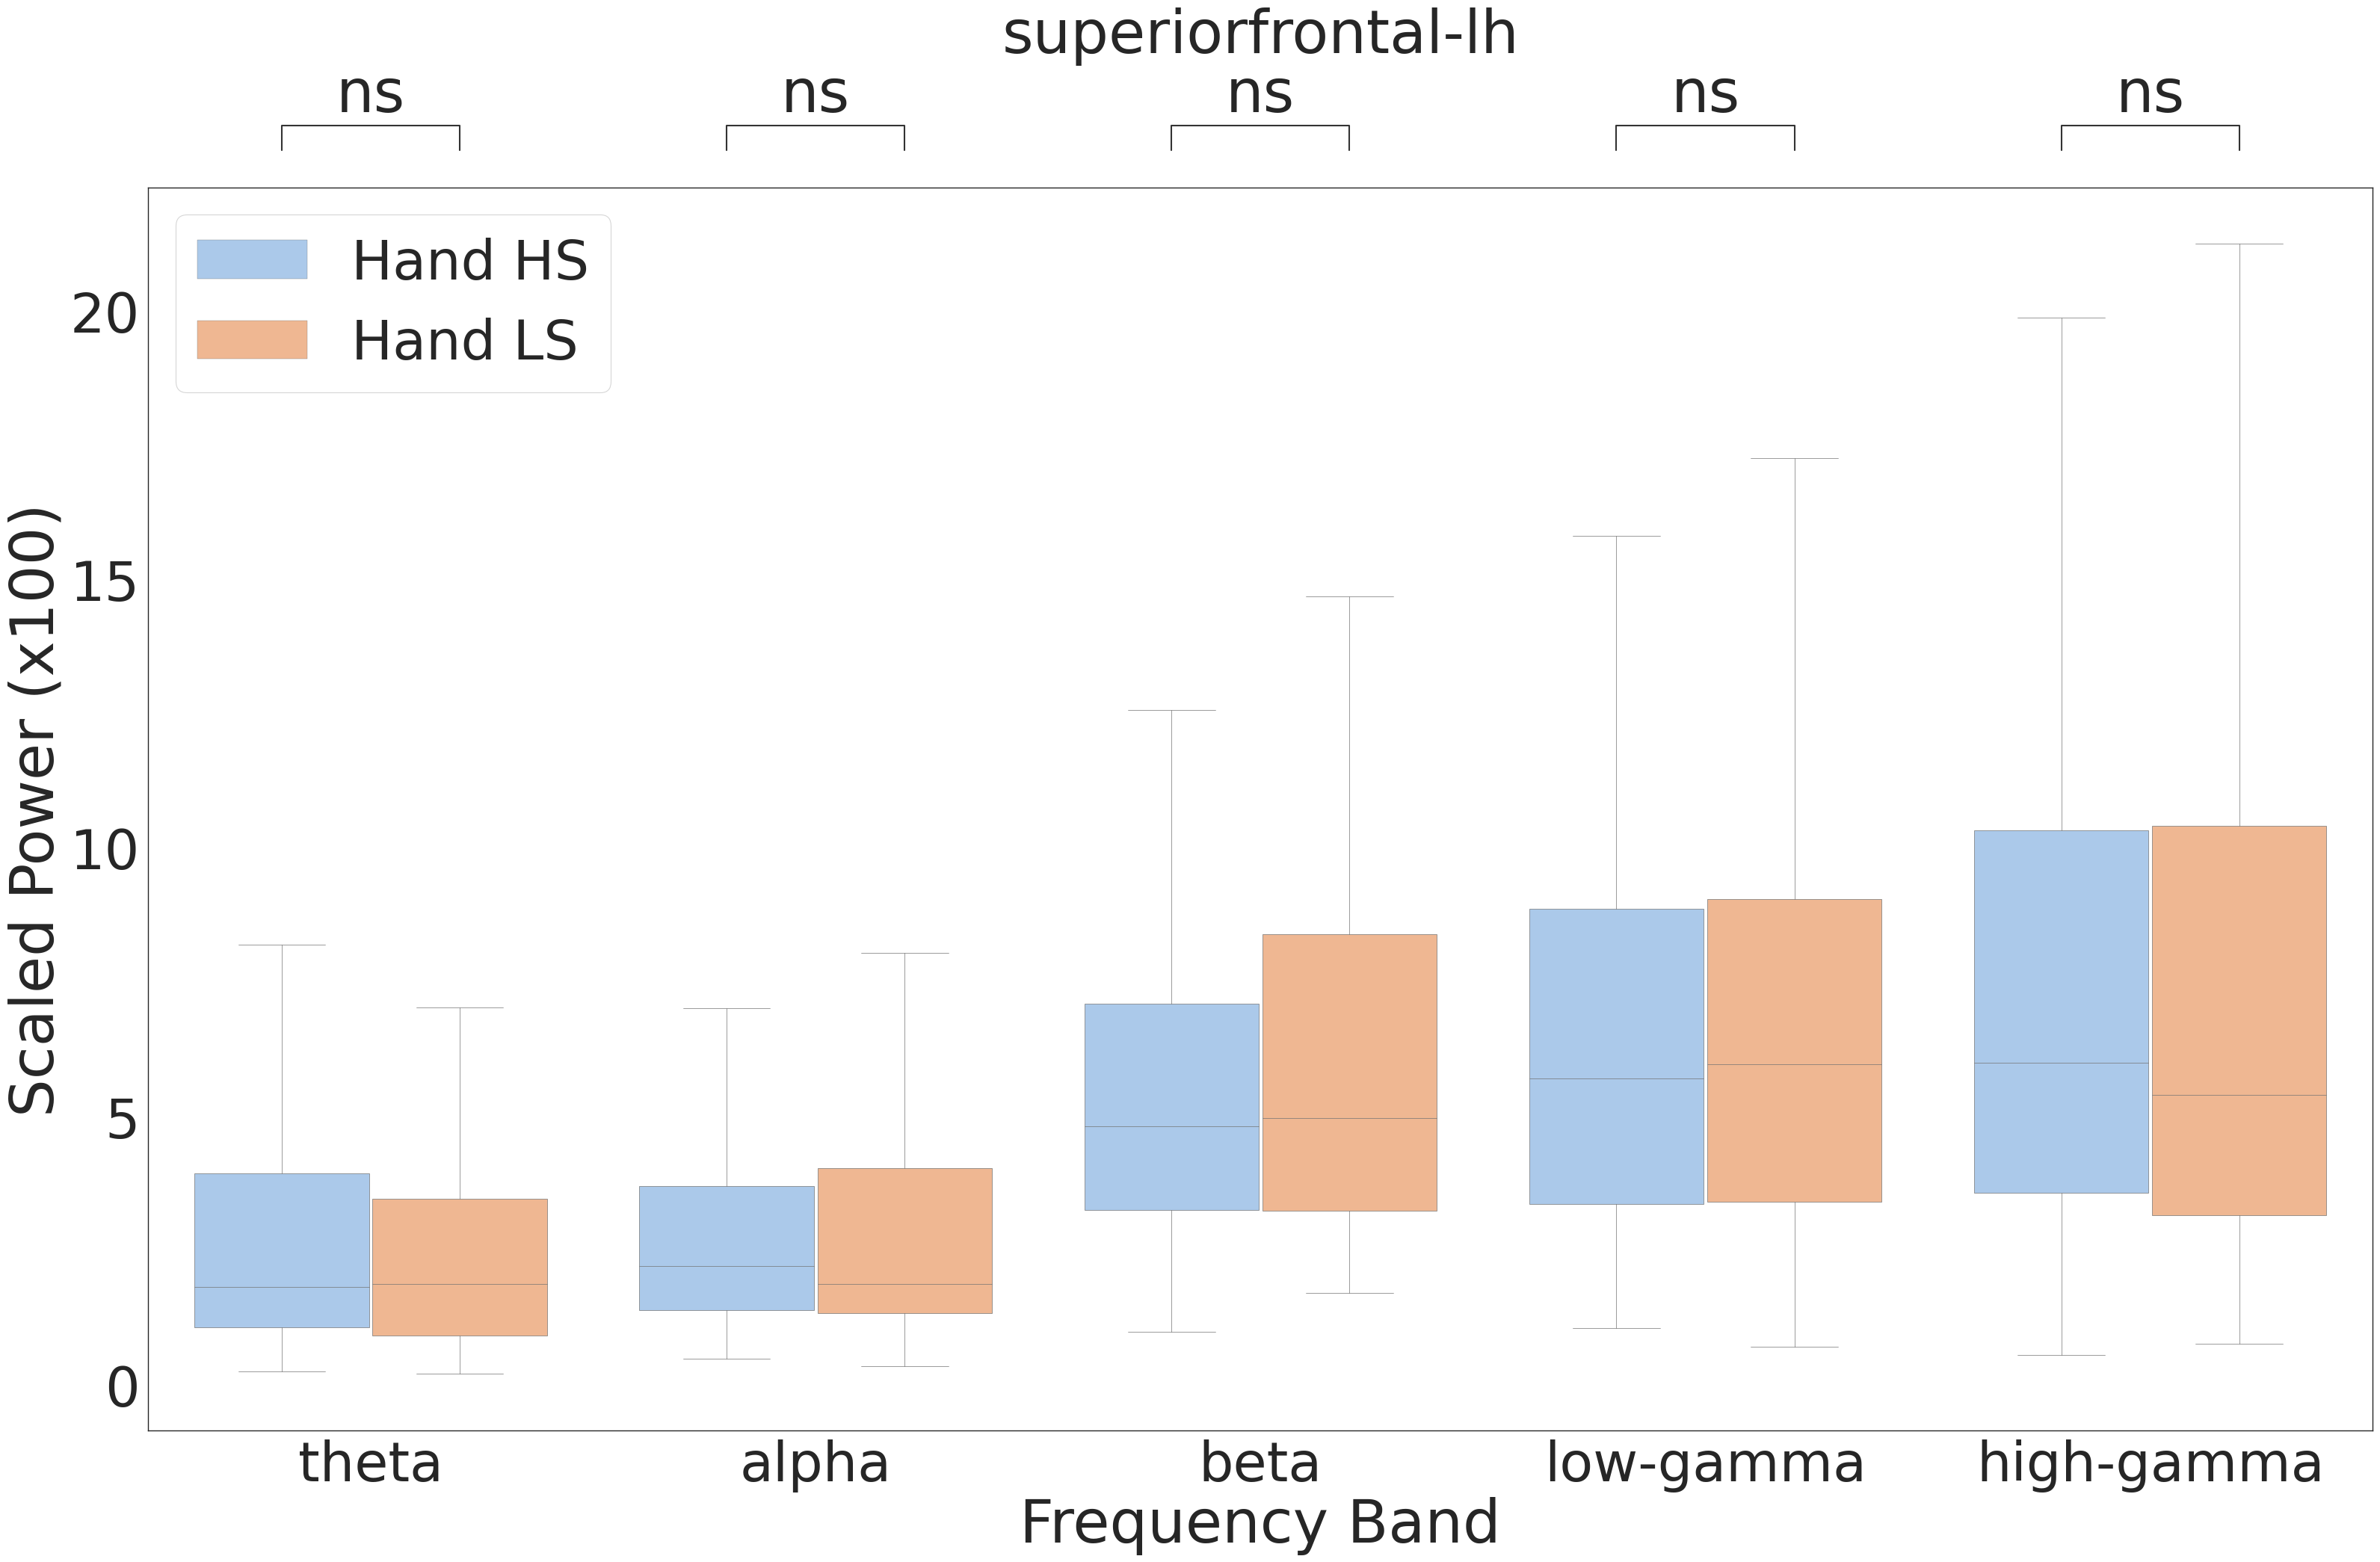

<Figure size 640x480 with 0 Axes>

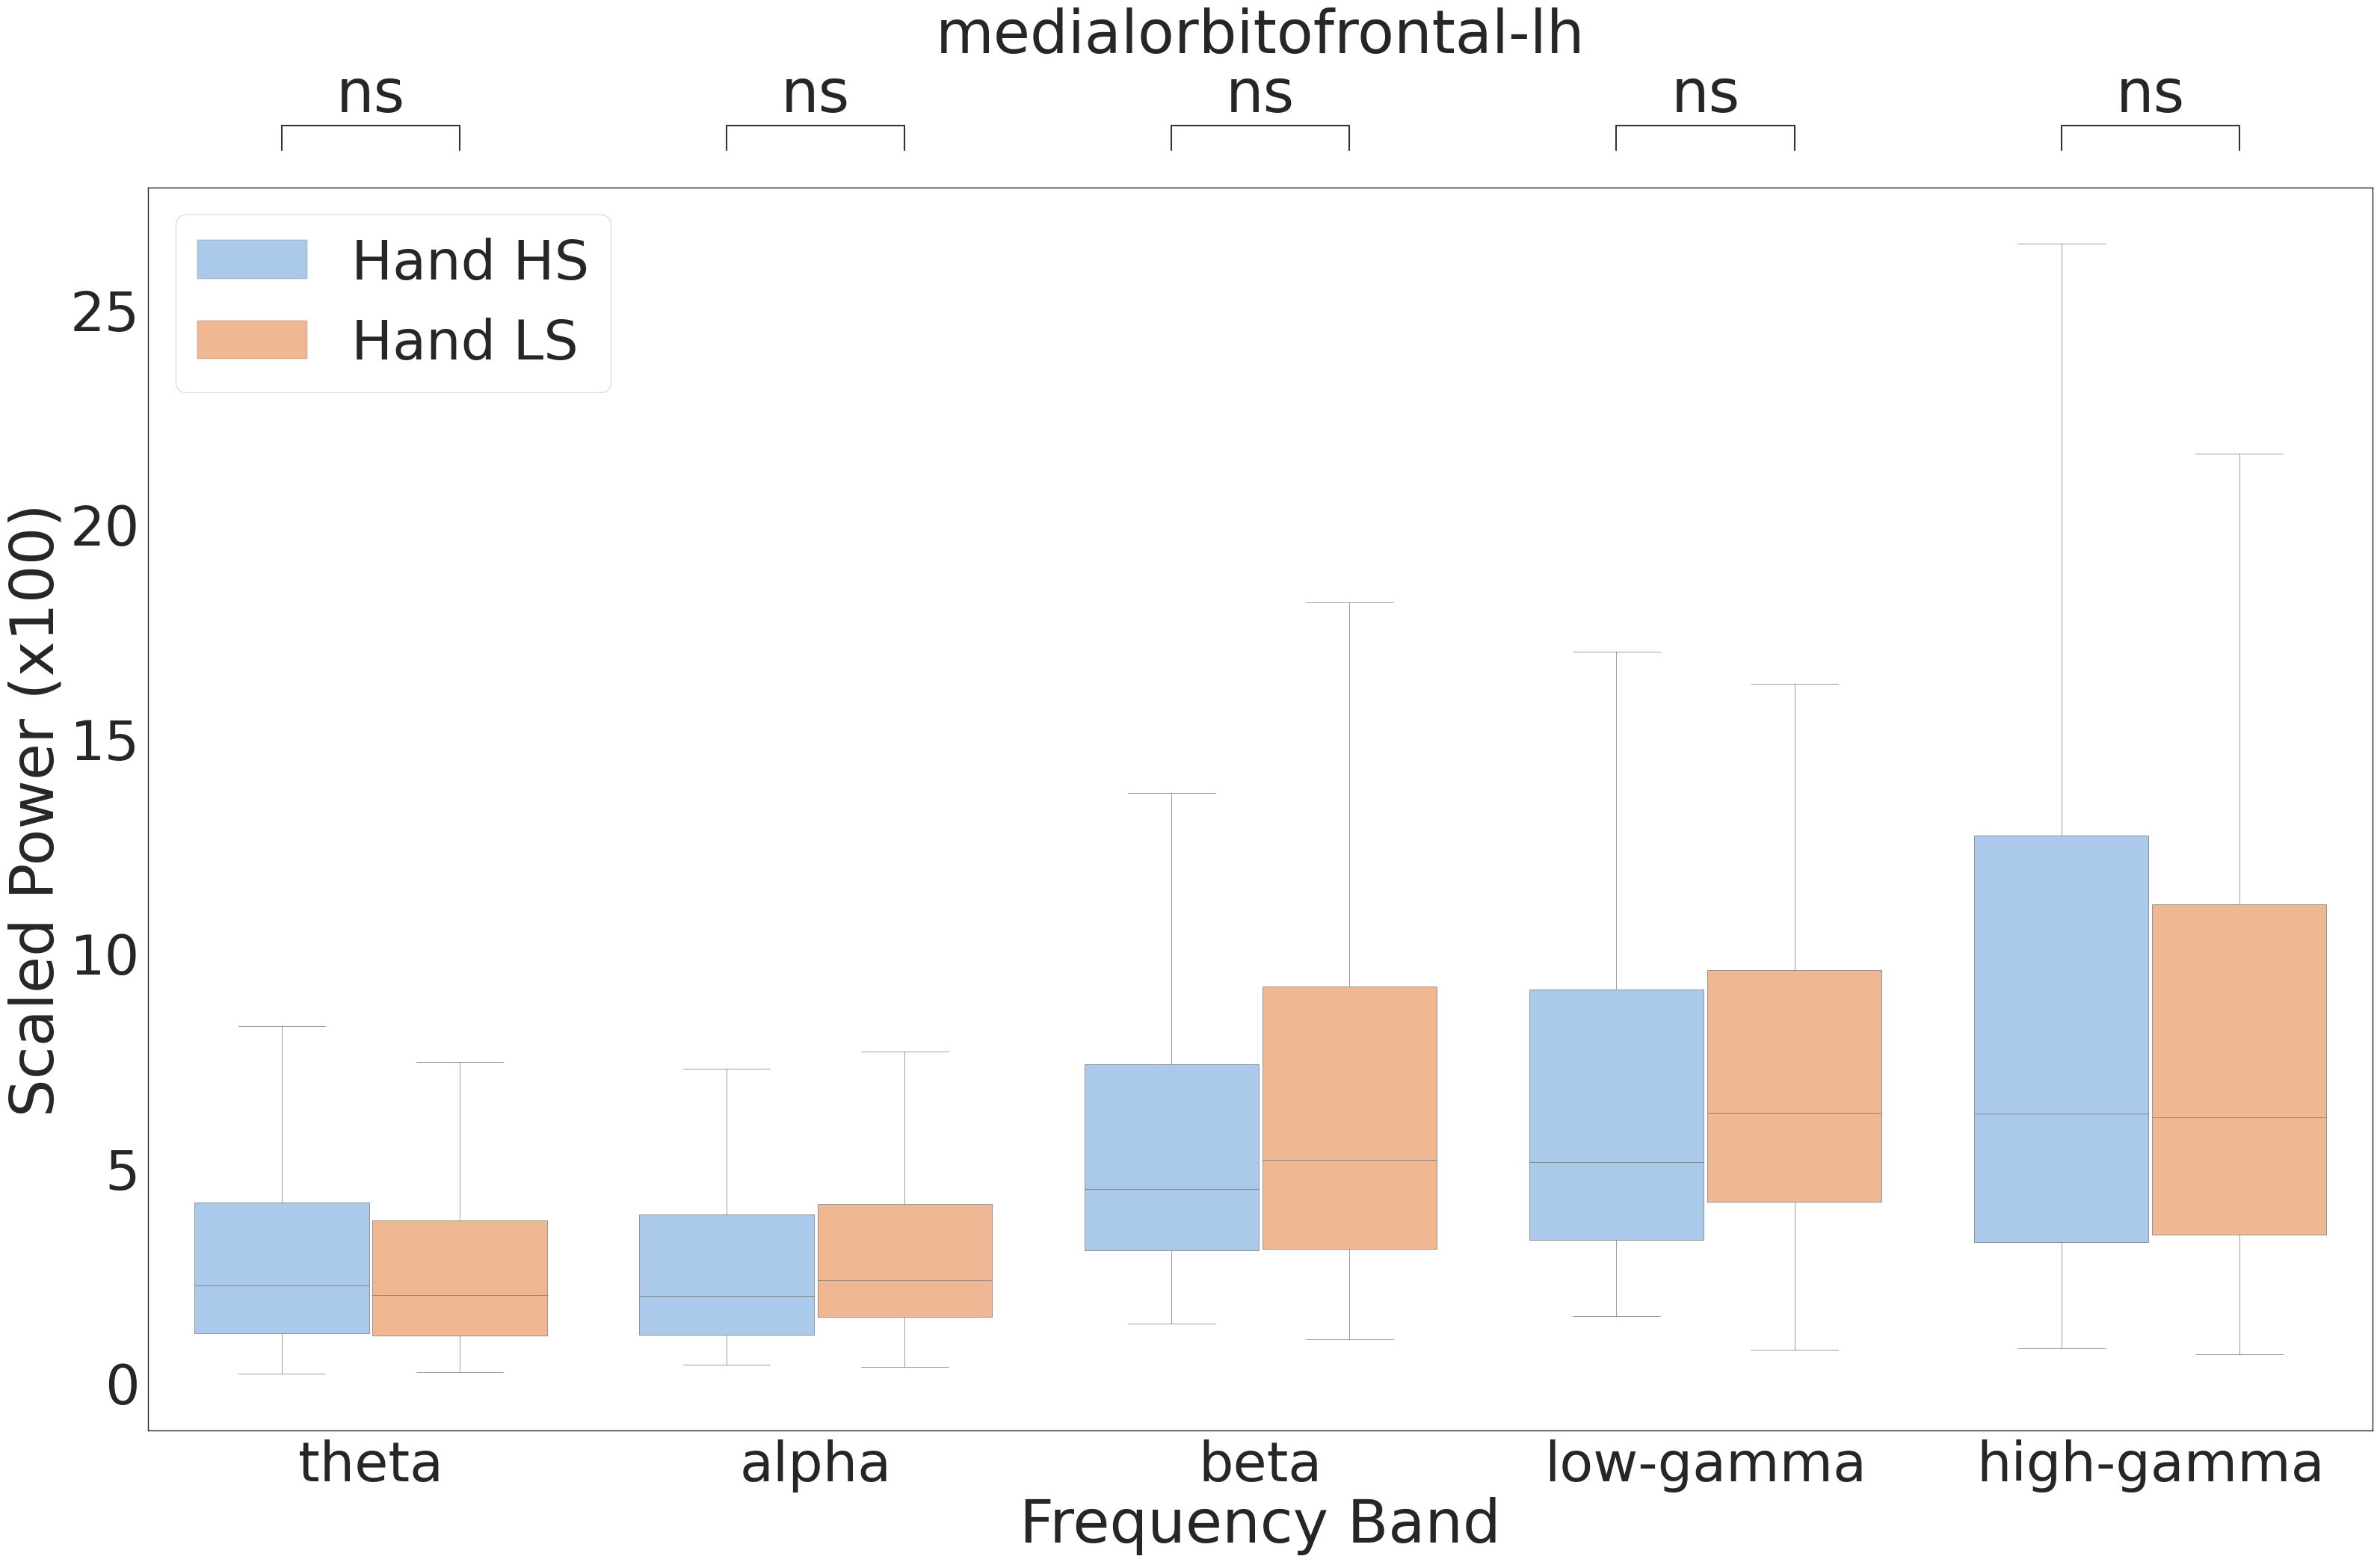

<Figure size 640x480 with 0 Axes>

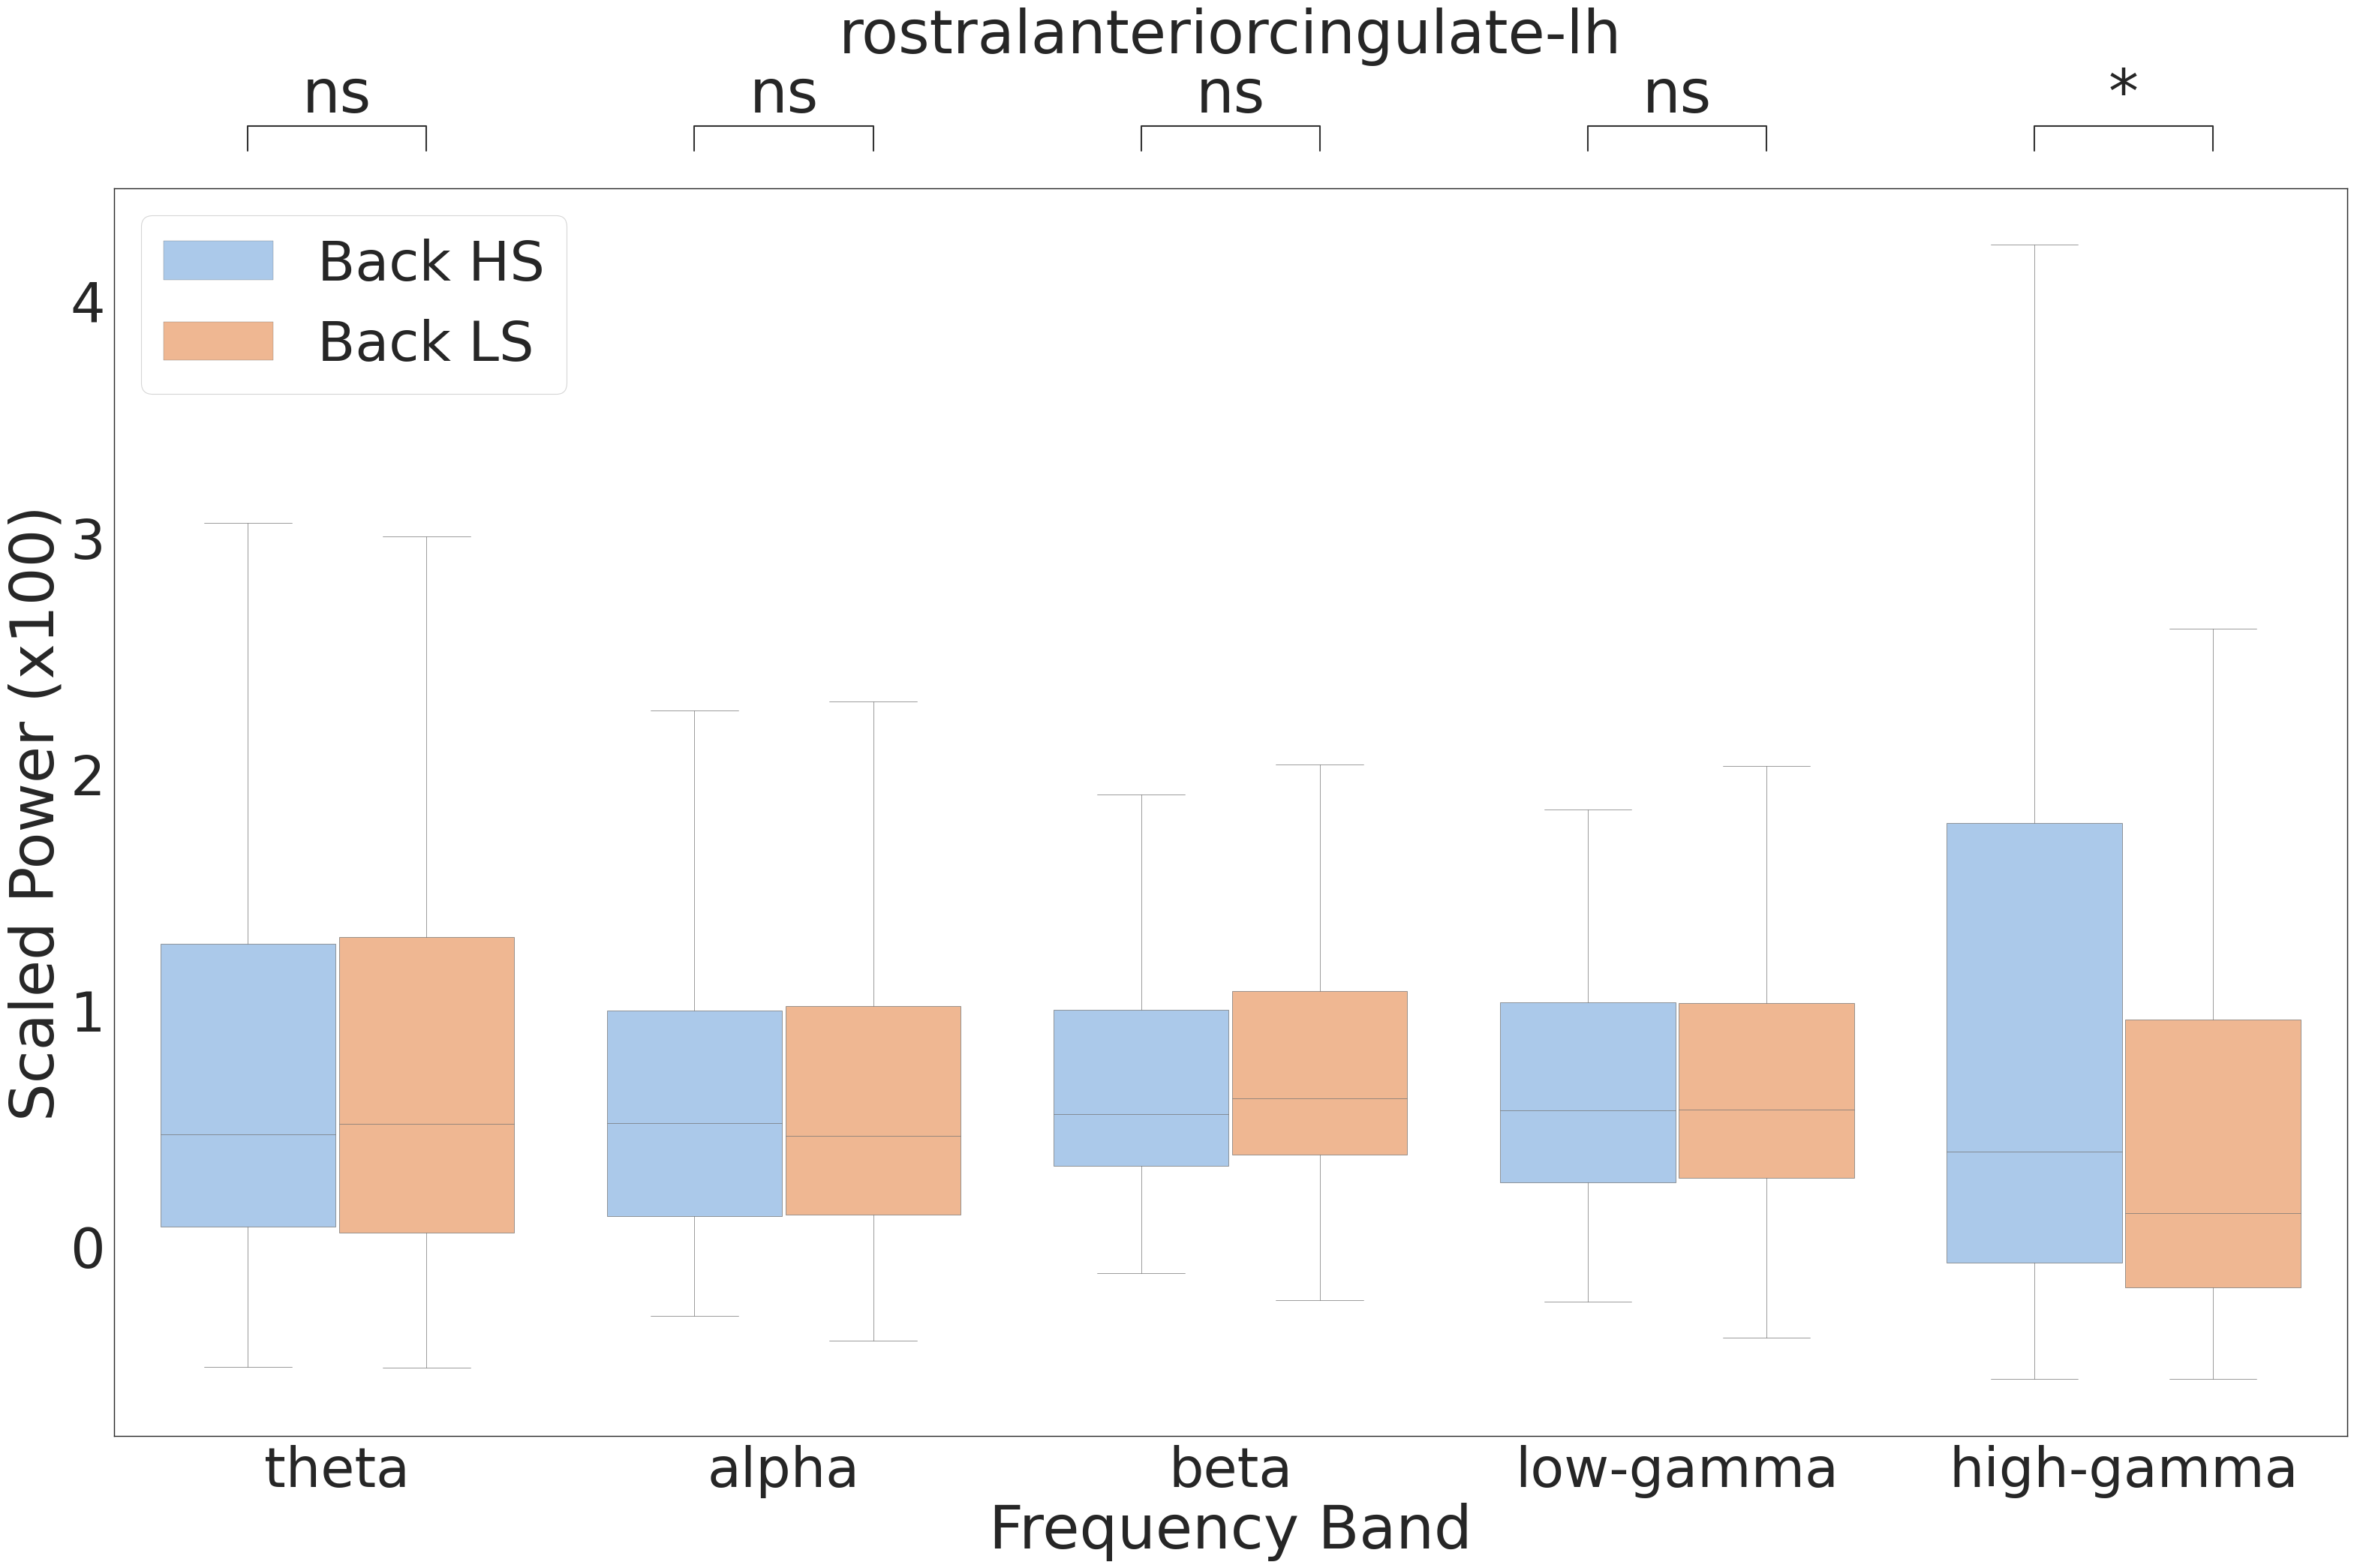

<Figure size 640x480 with 0 Axes>

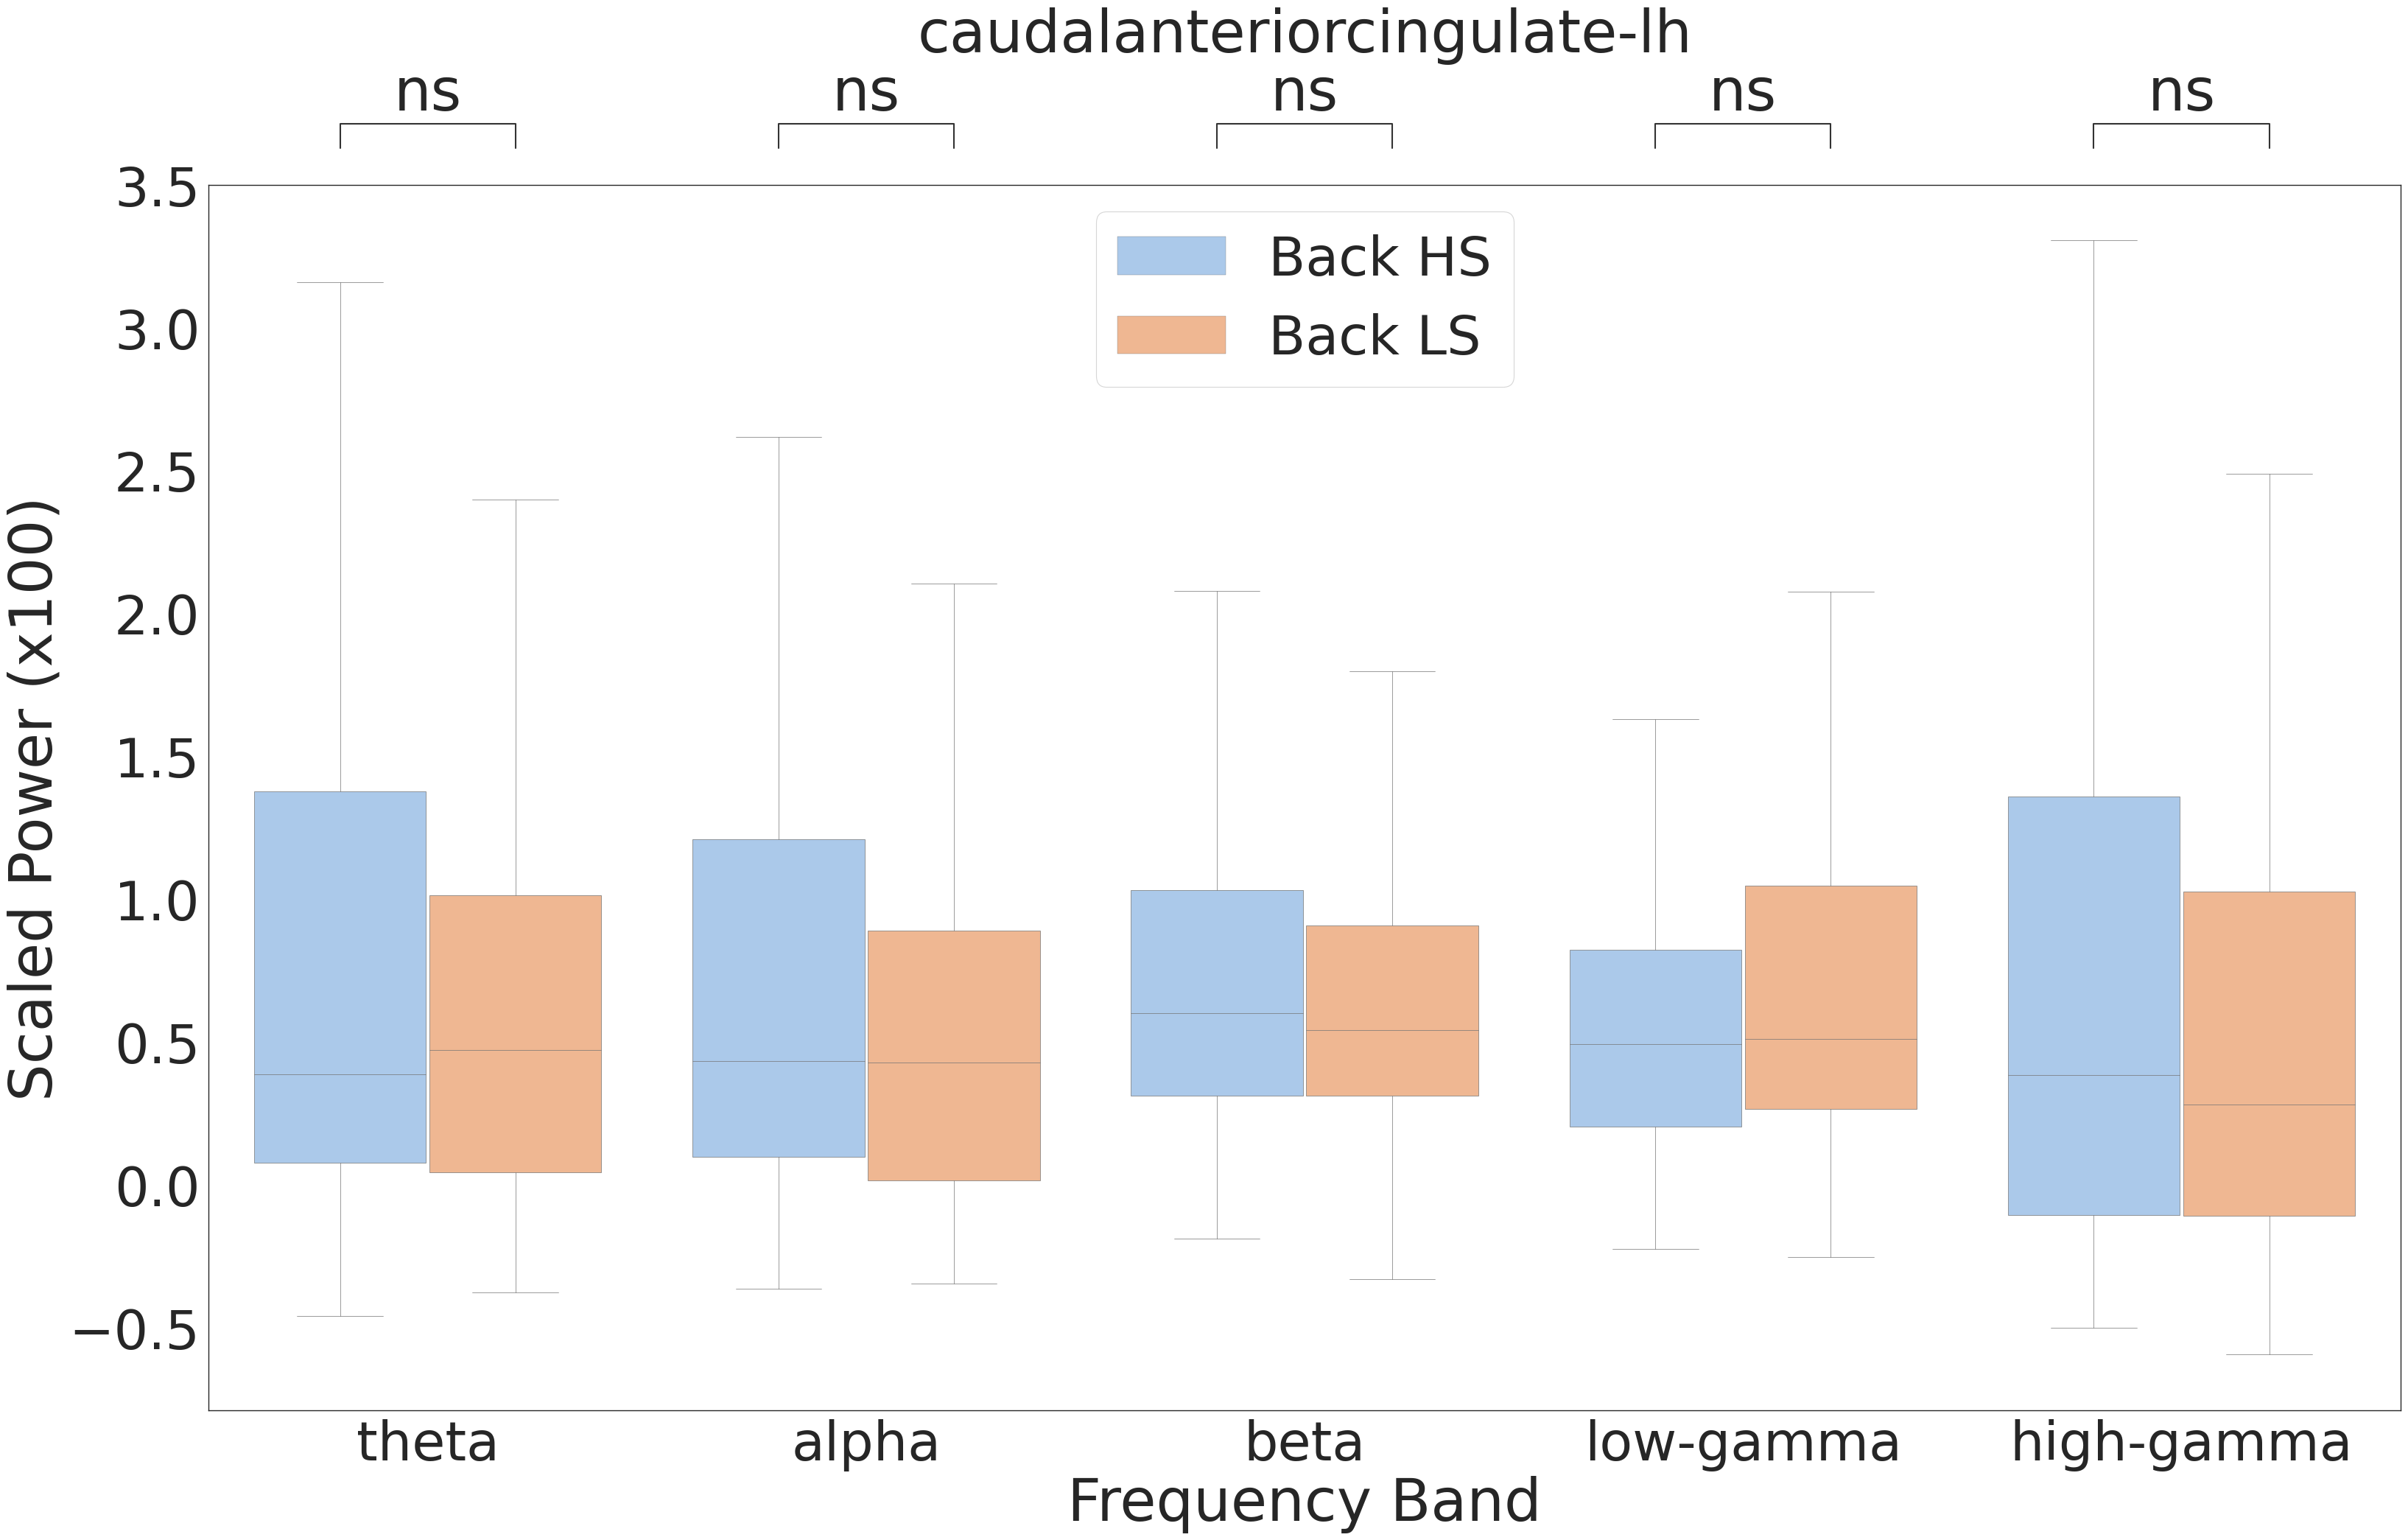

<Figure size 640x480 with 0 Axes>

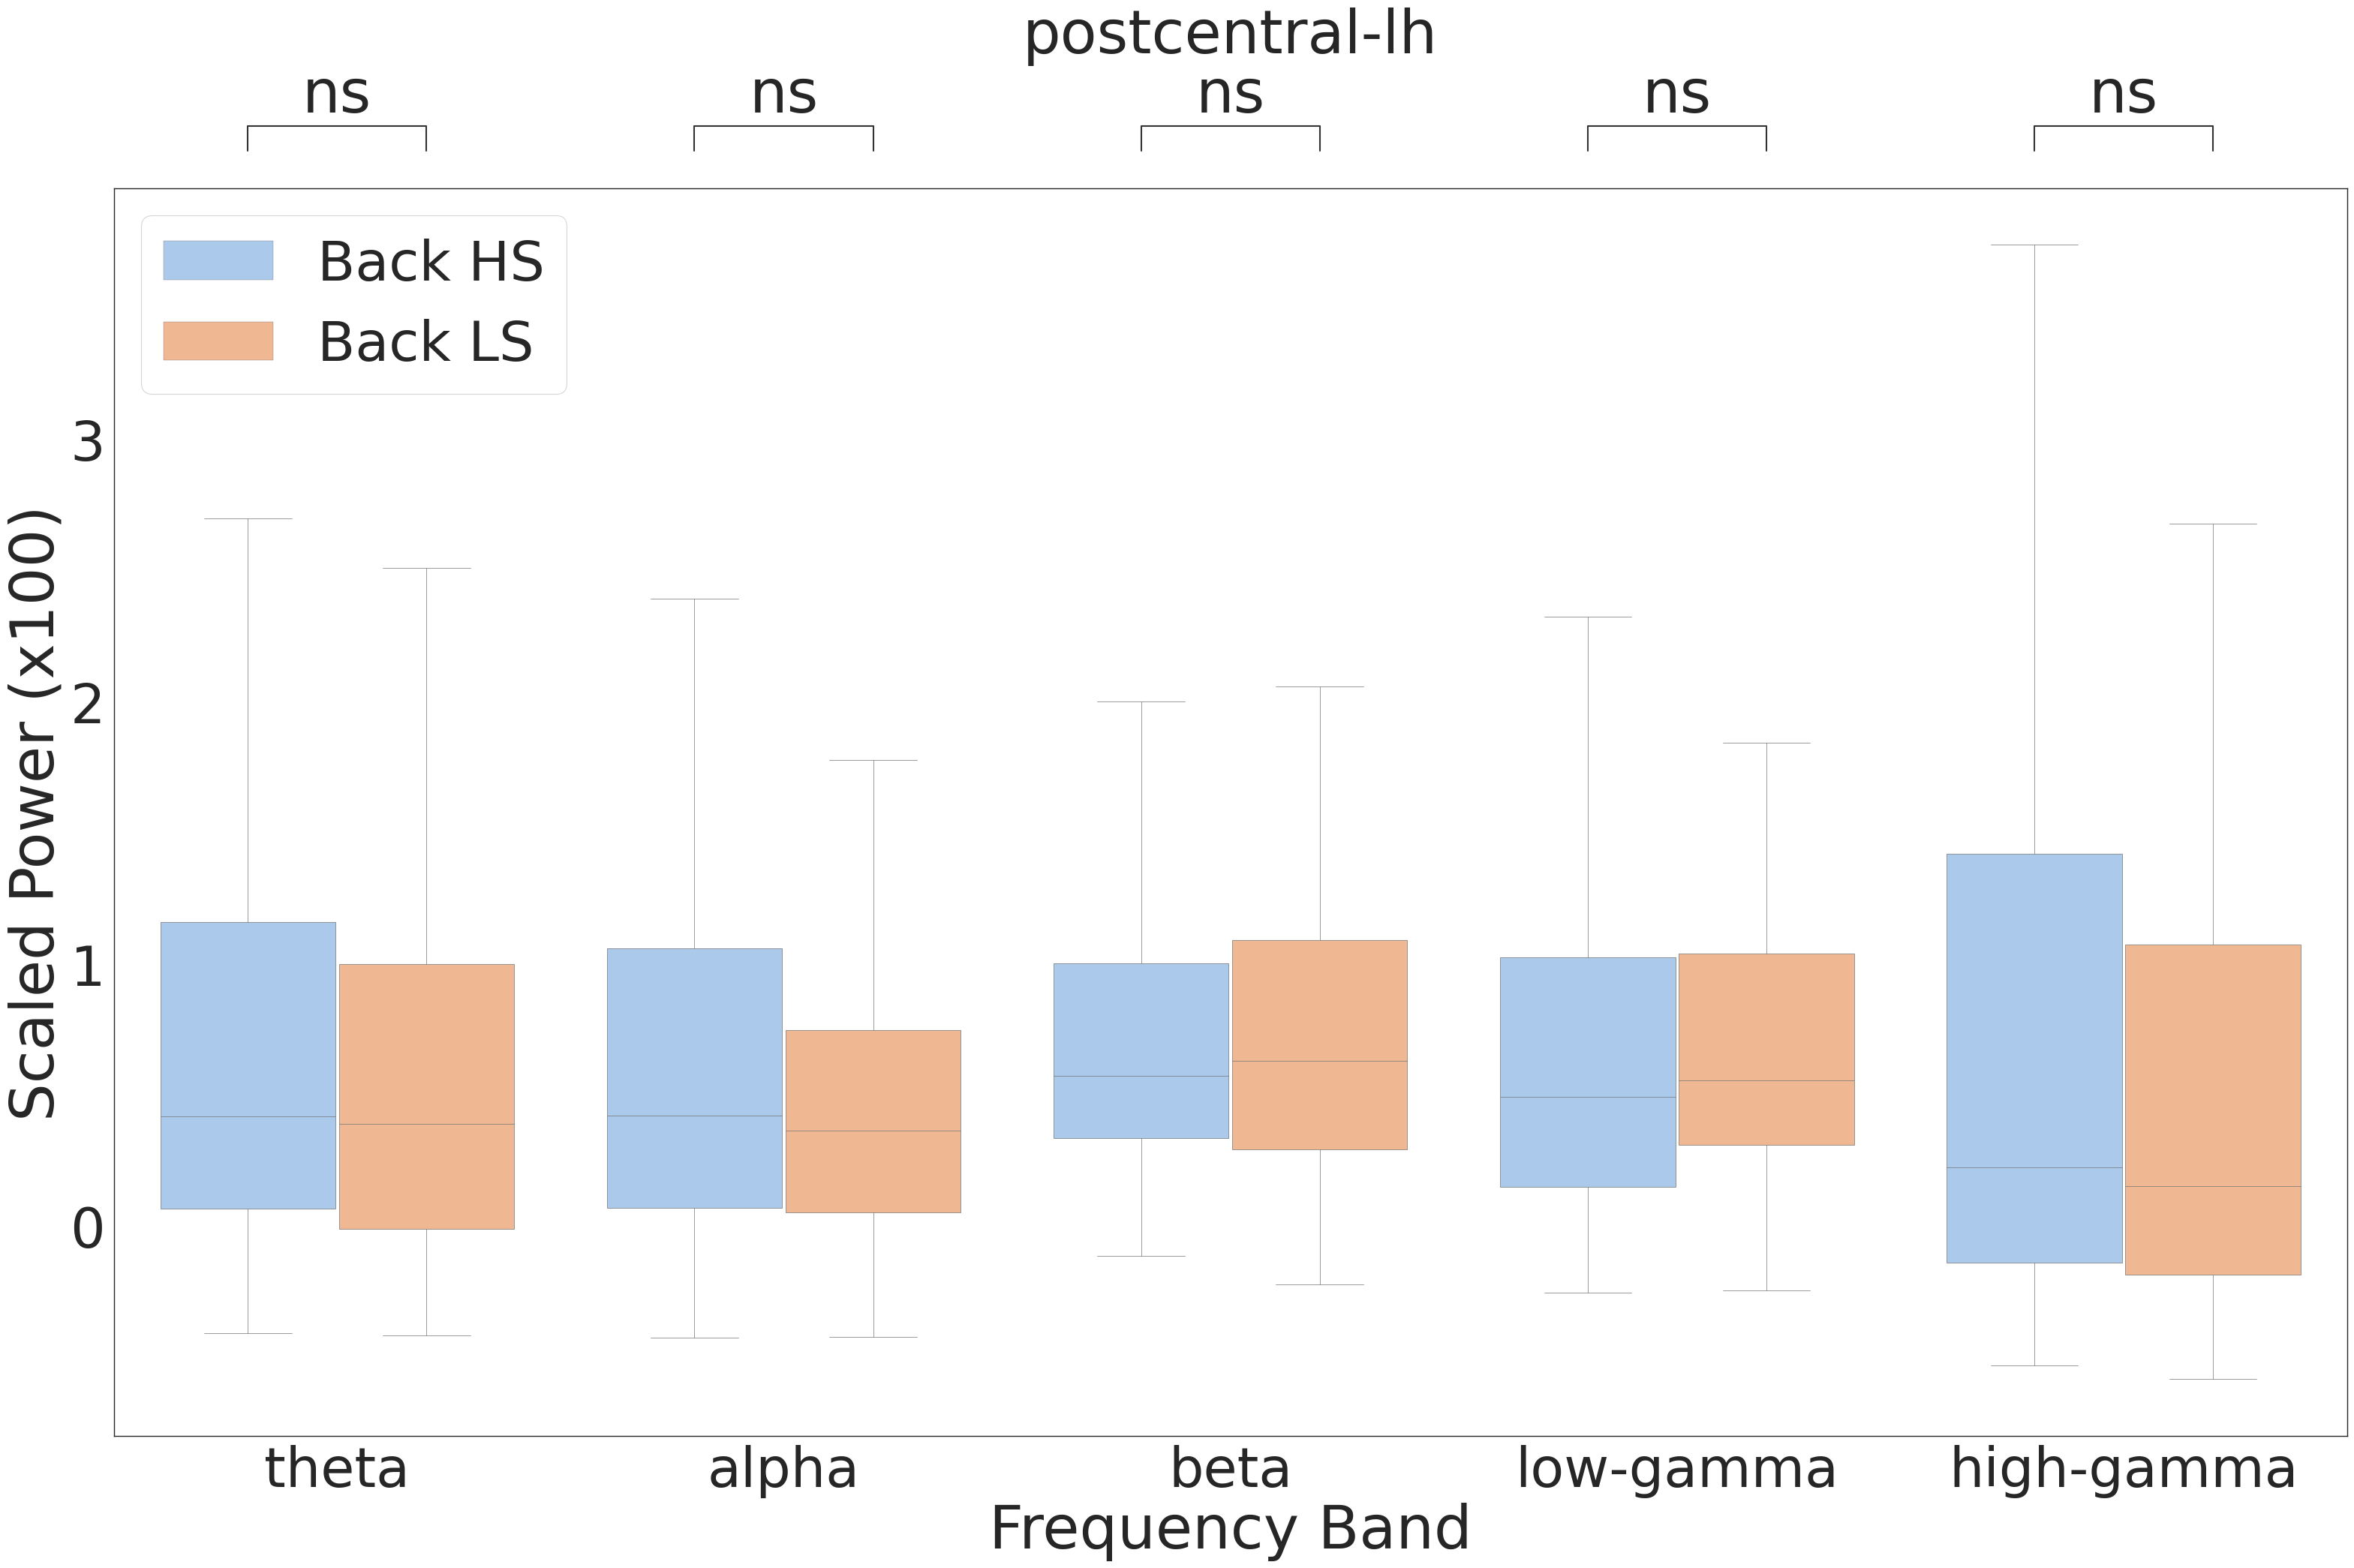

<Figure size 640x480 with 0 Axes>

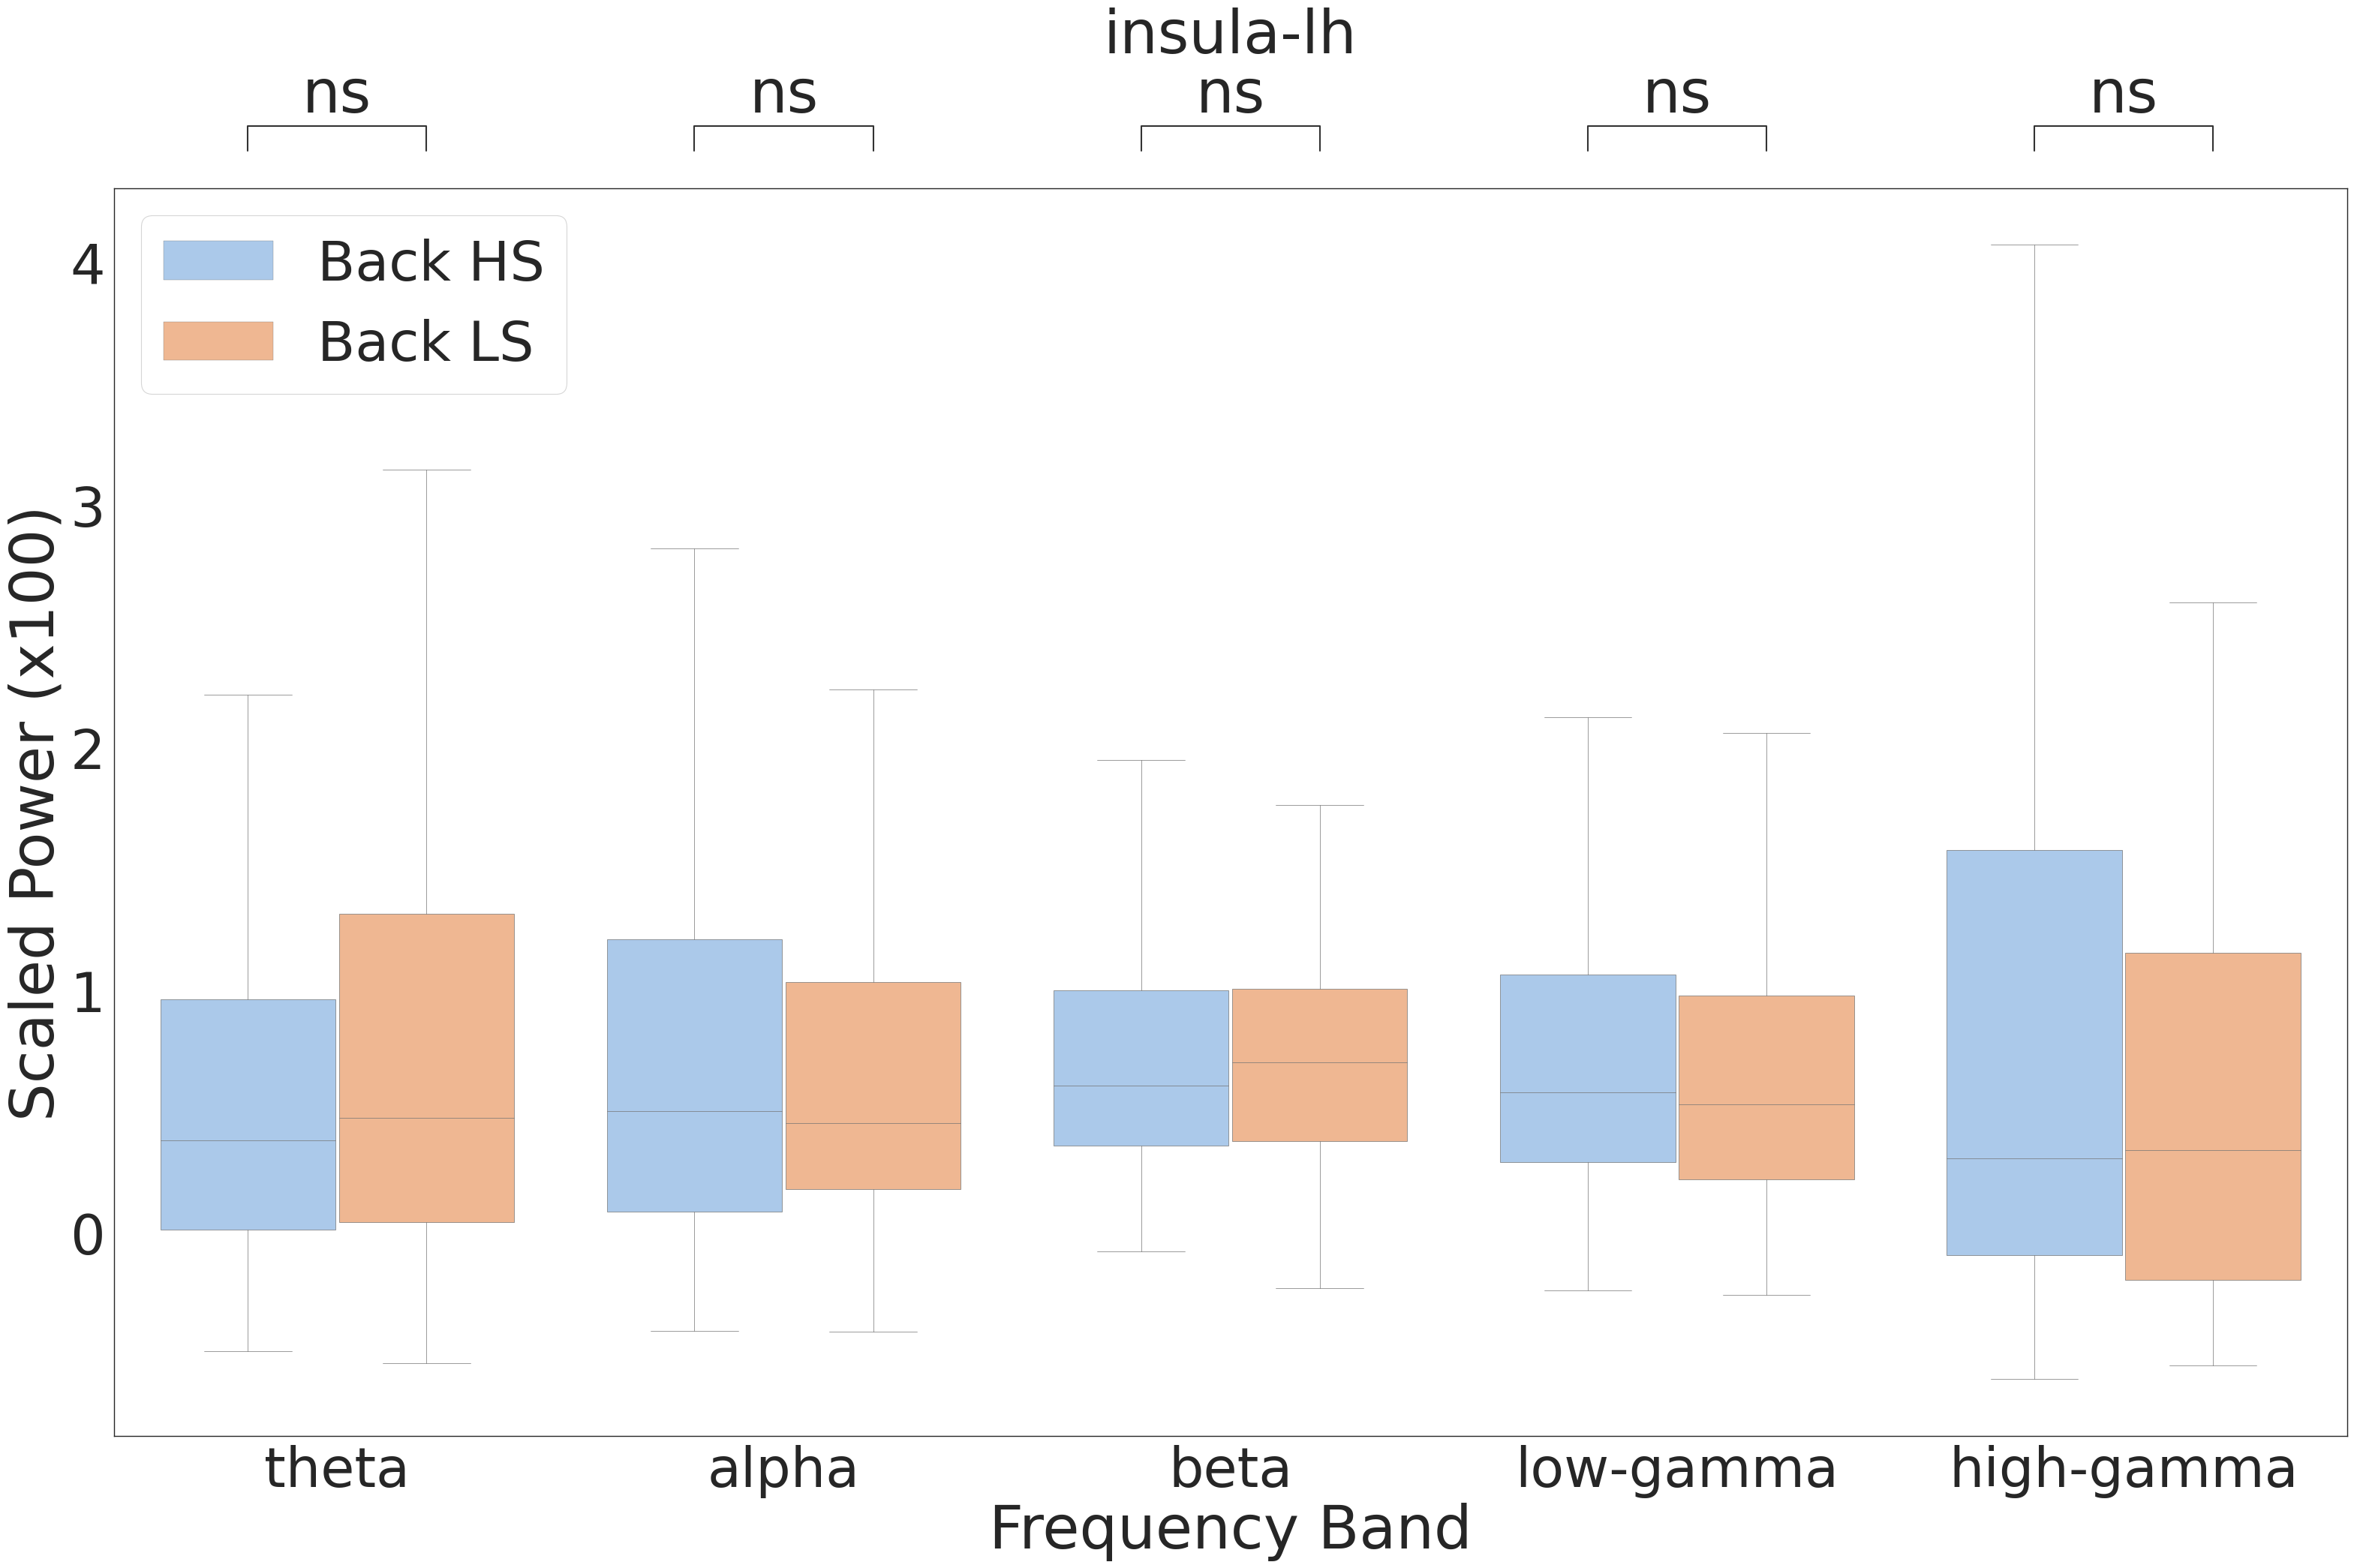

<Figure size 640x480 with 0 Axes>

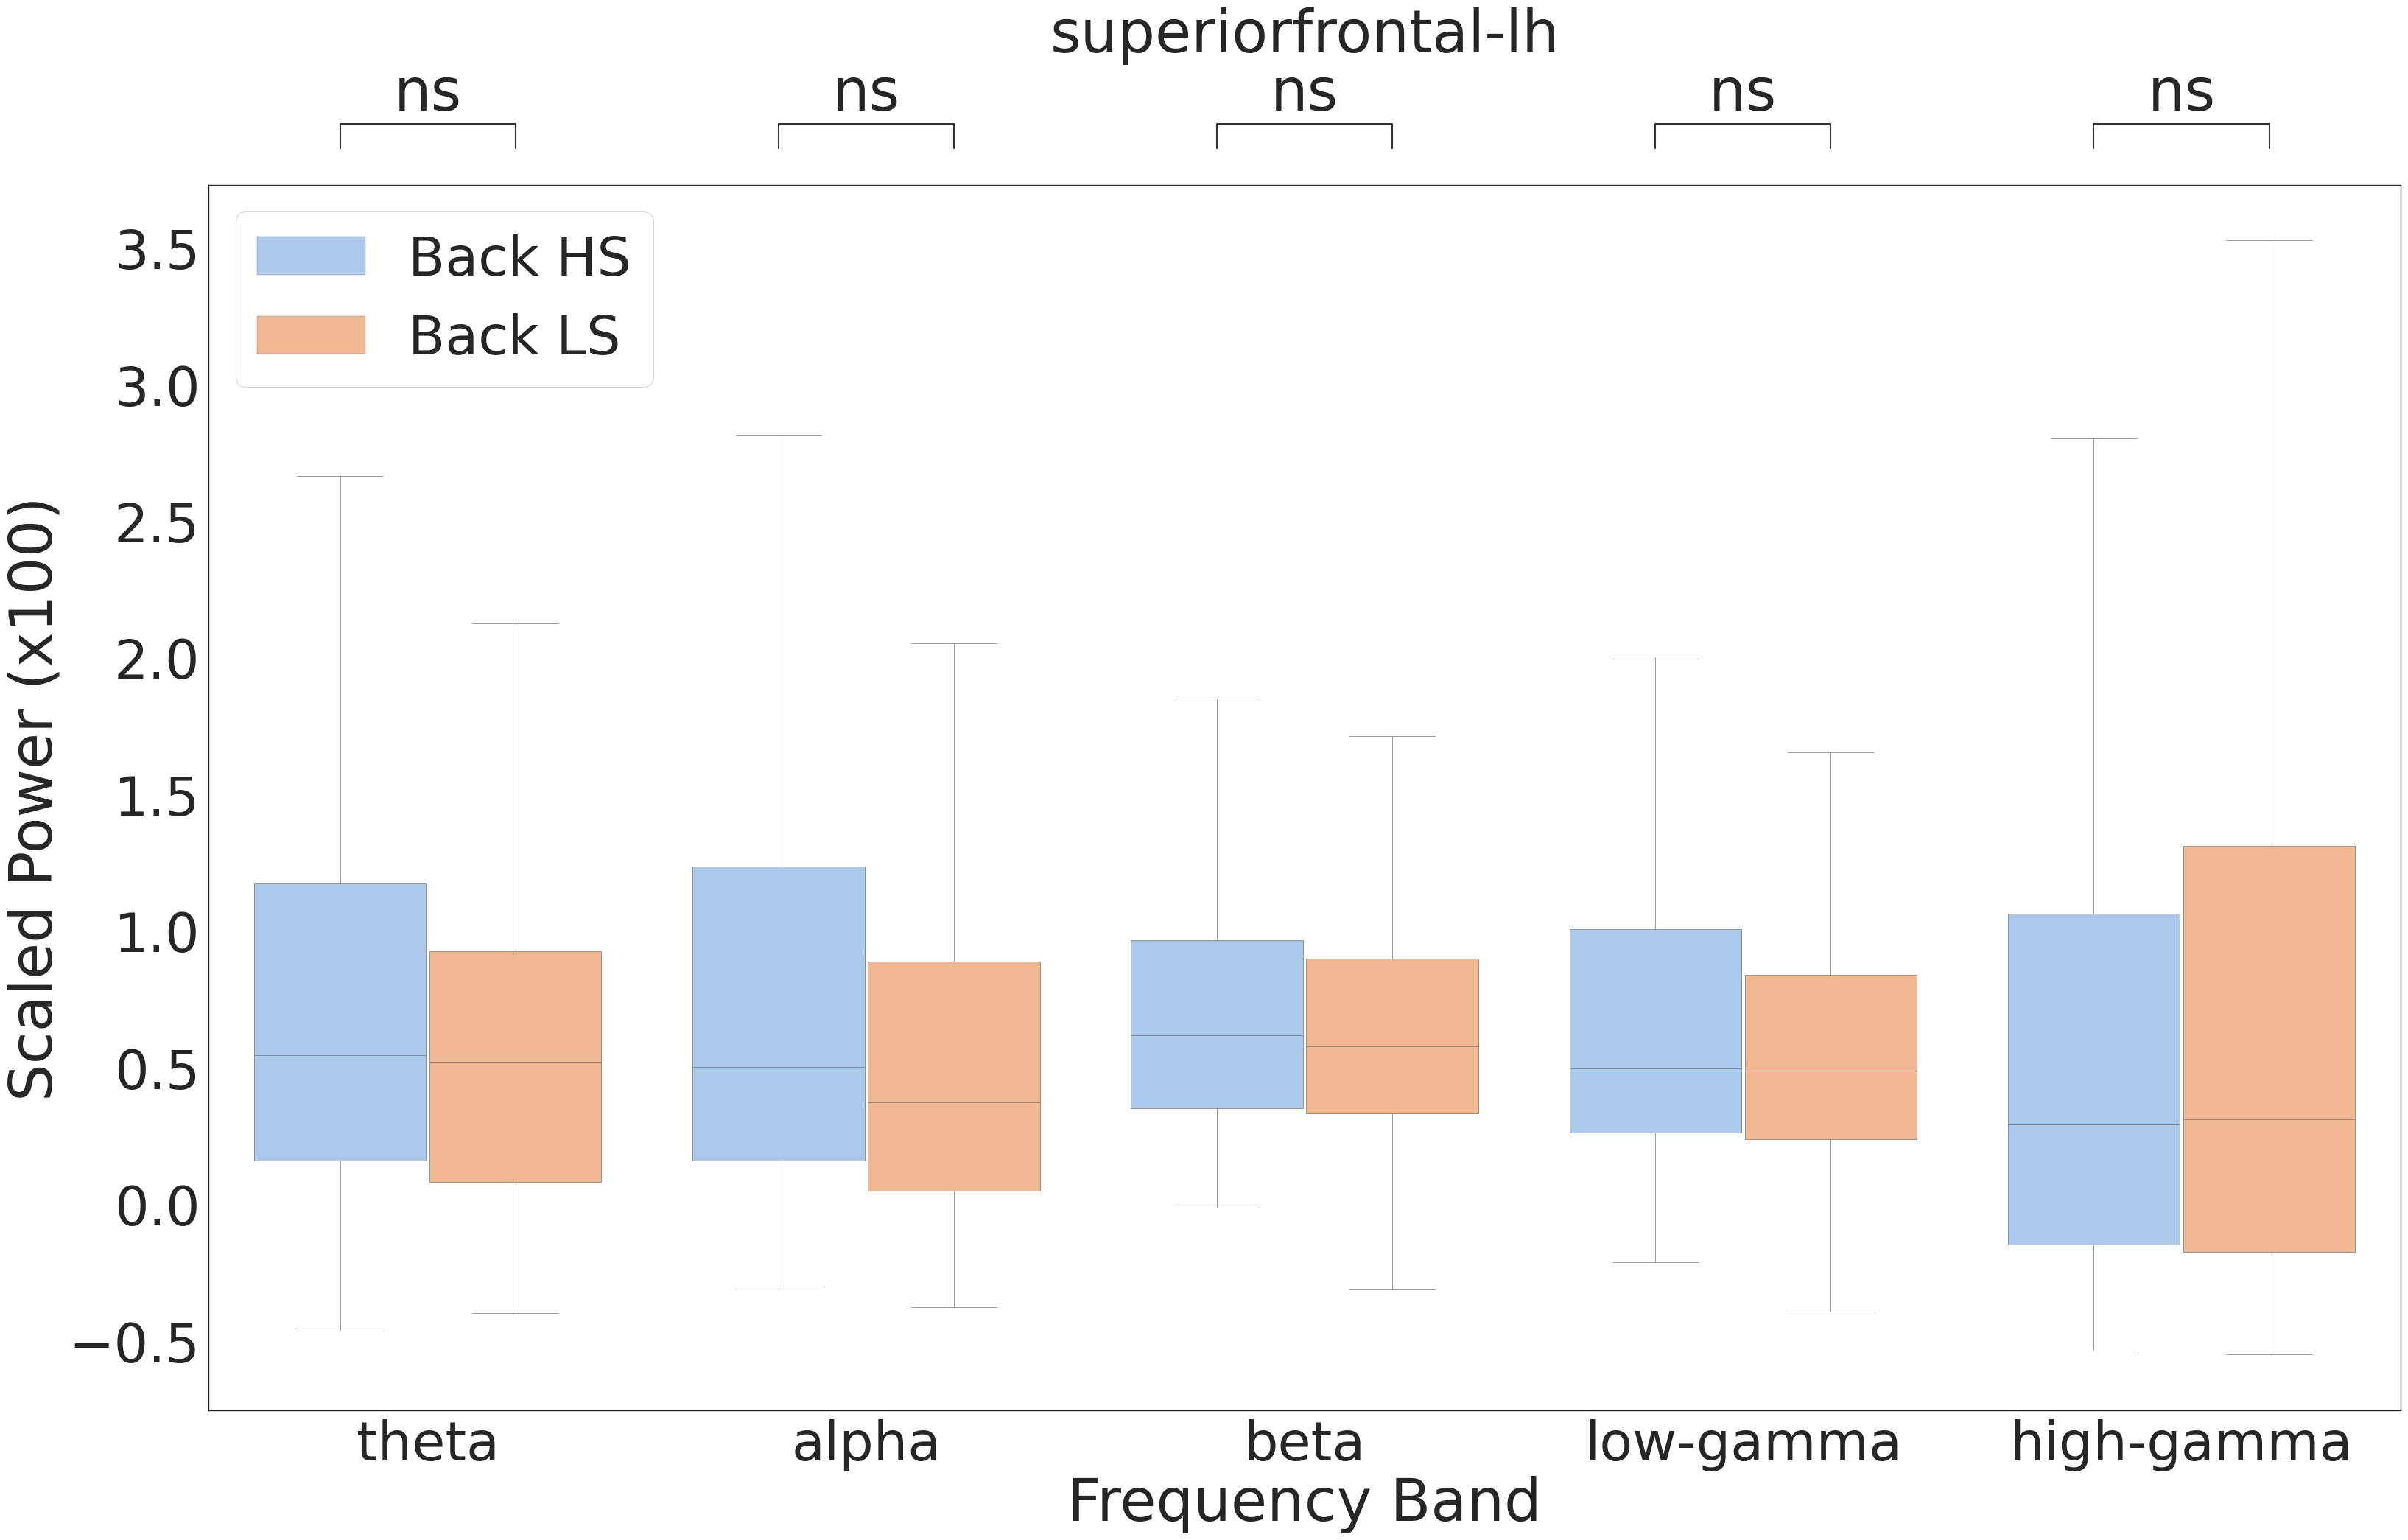

<Figure size 640x480 with 0 Axes>

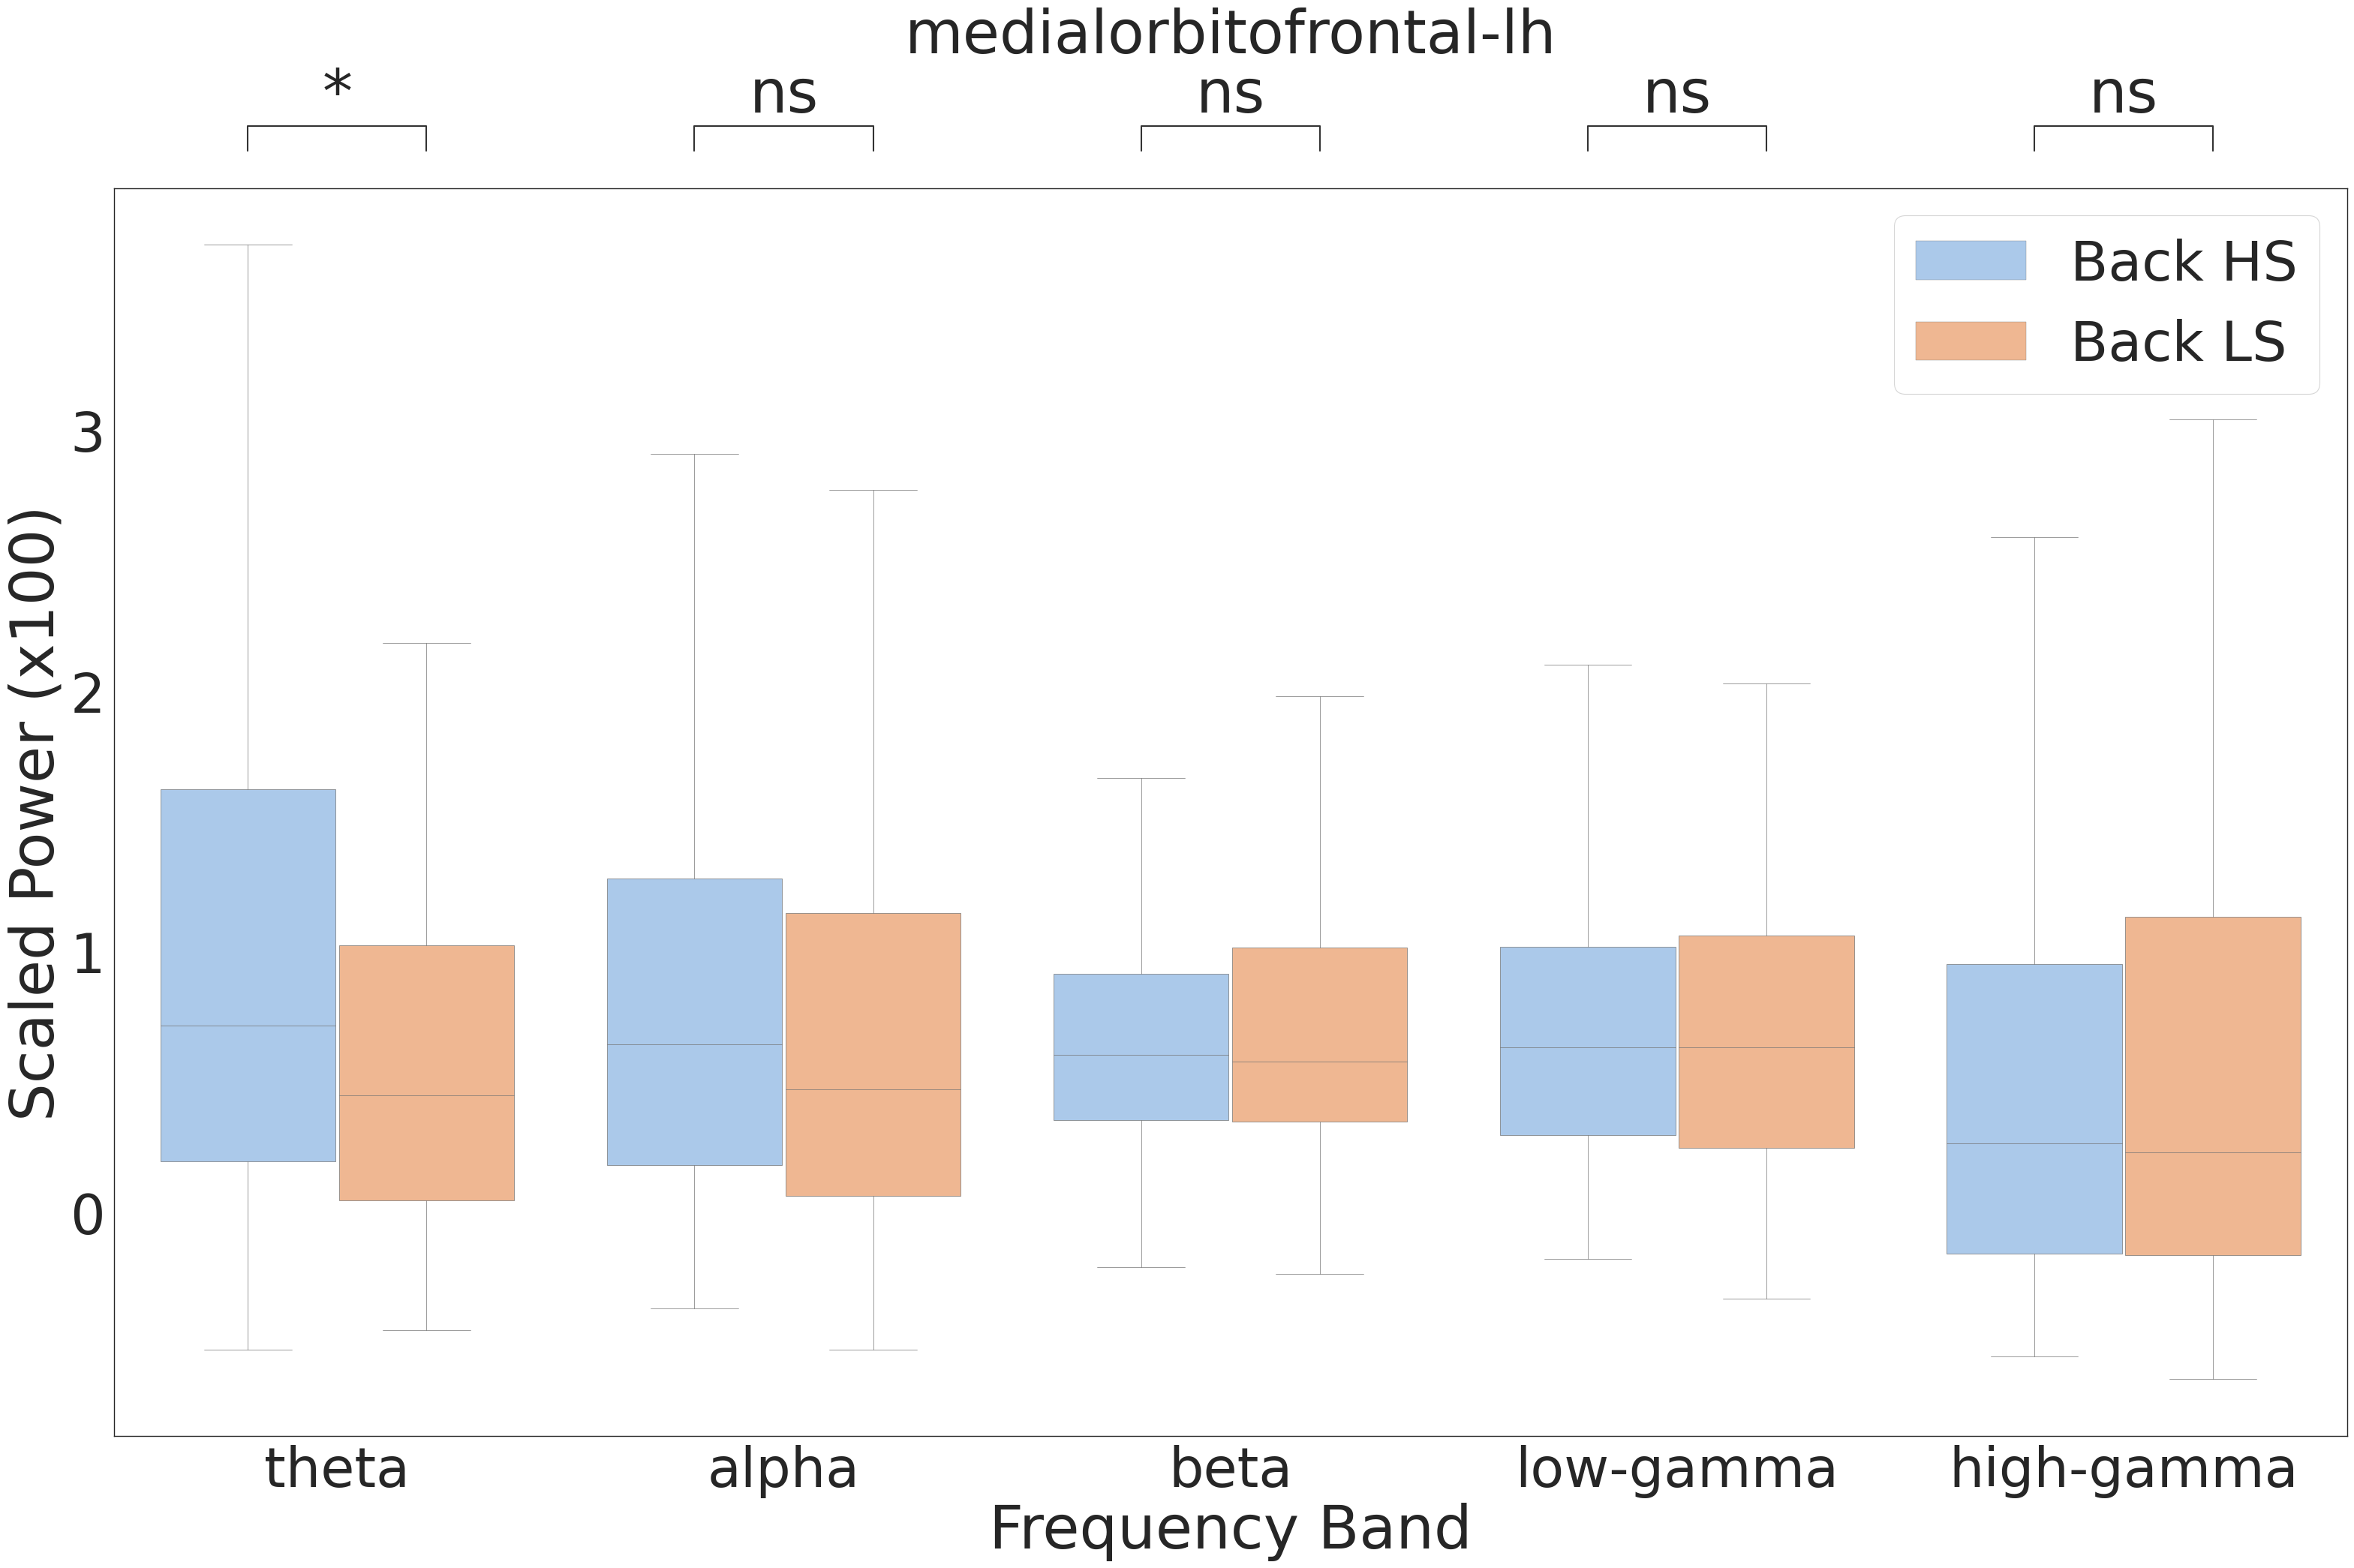

<Figure size 640x480 with 0 Axes>

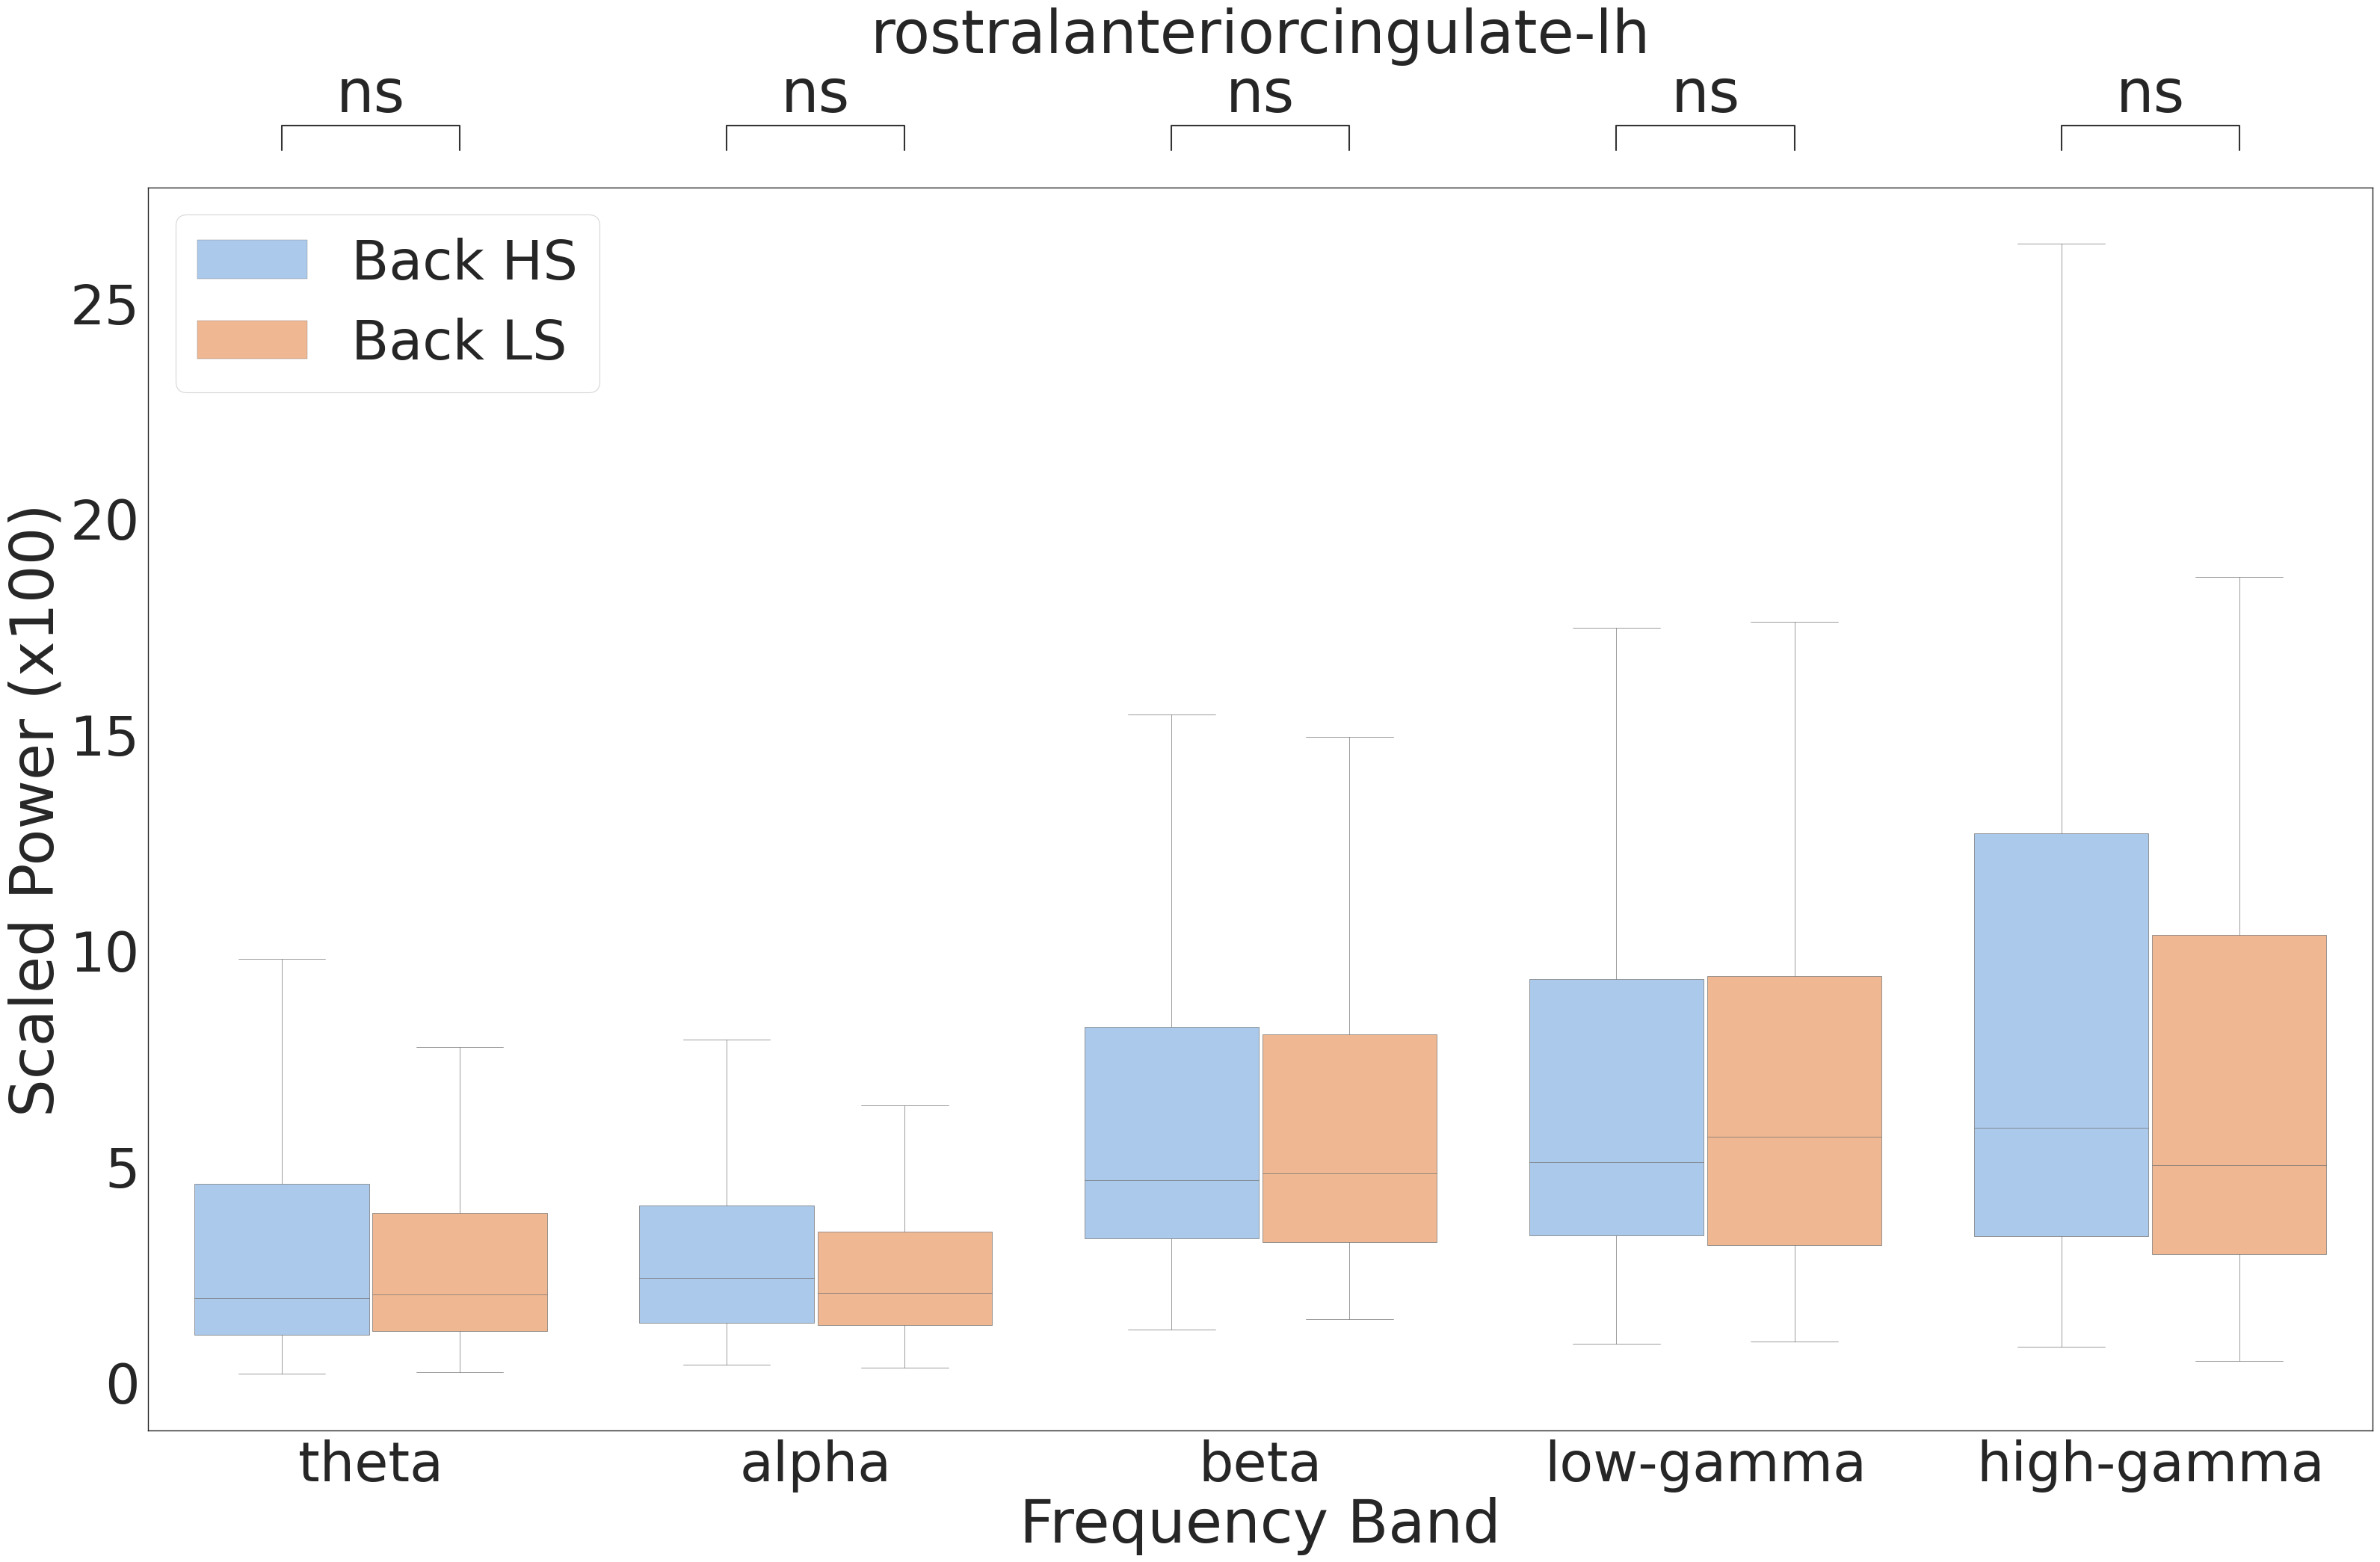

<Figure size 640x480 with 0 Axes>

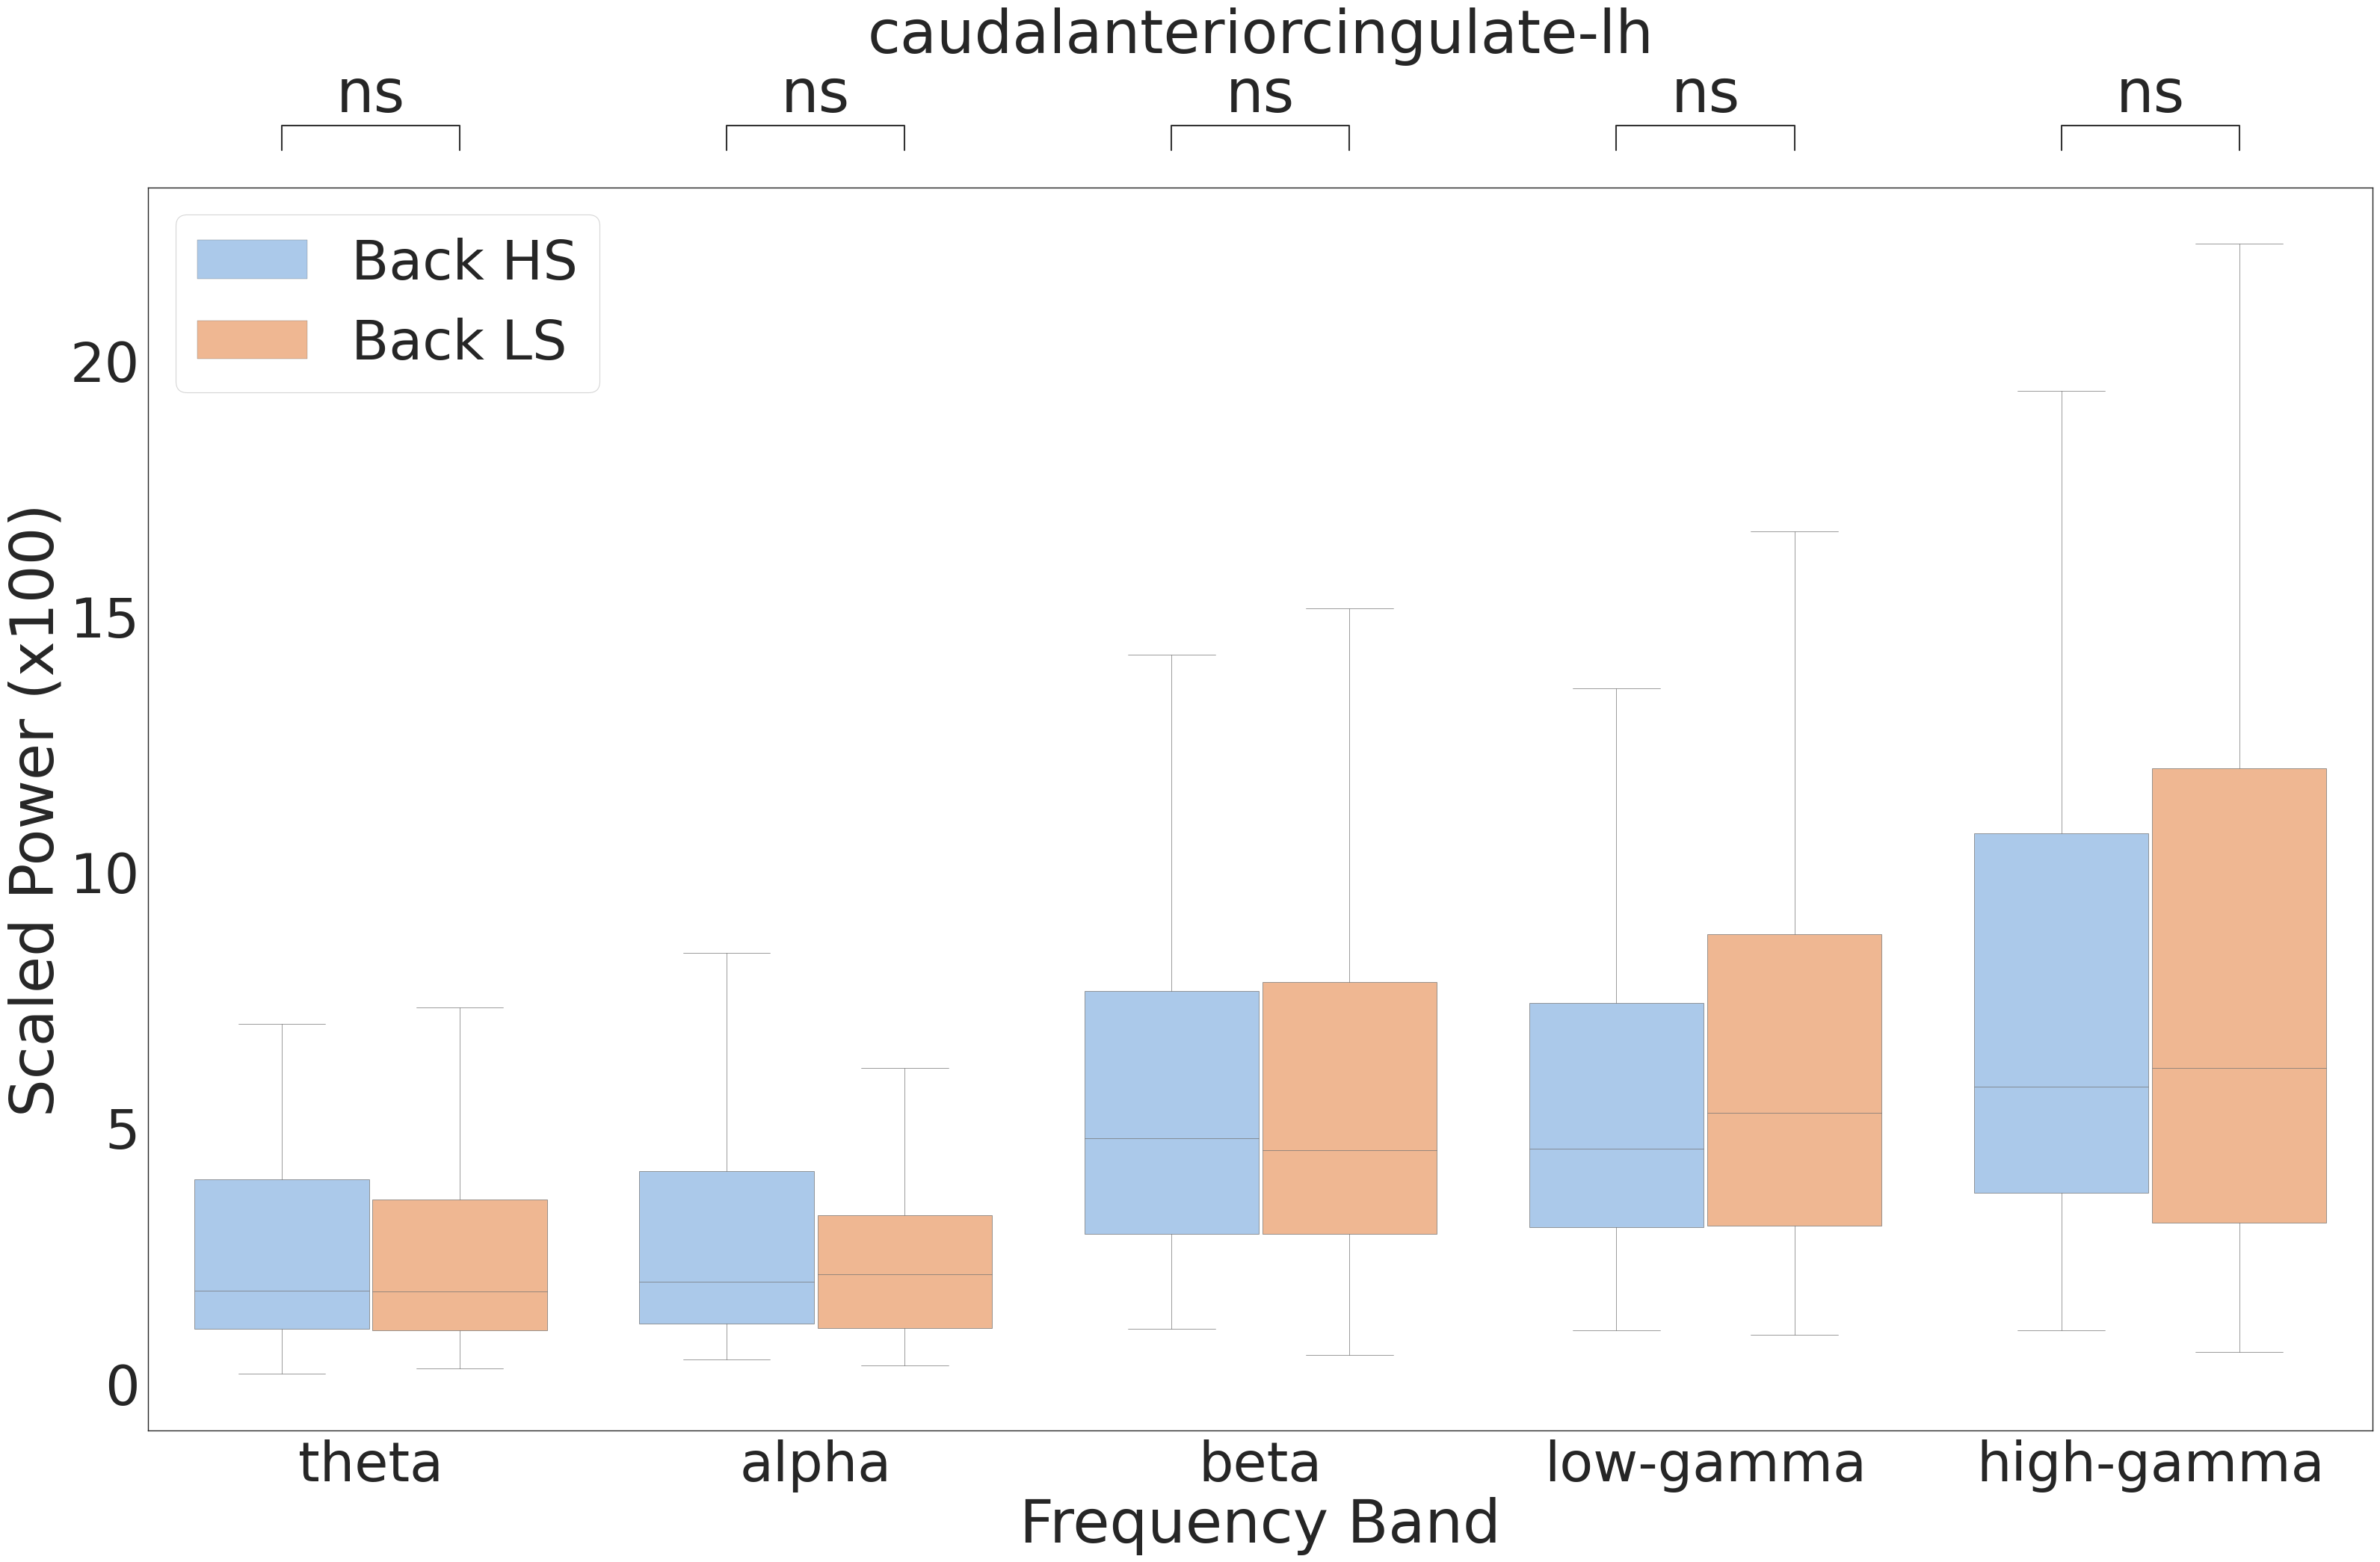

<Figure size 640x480 with 0 Axes>

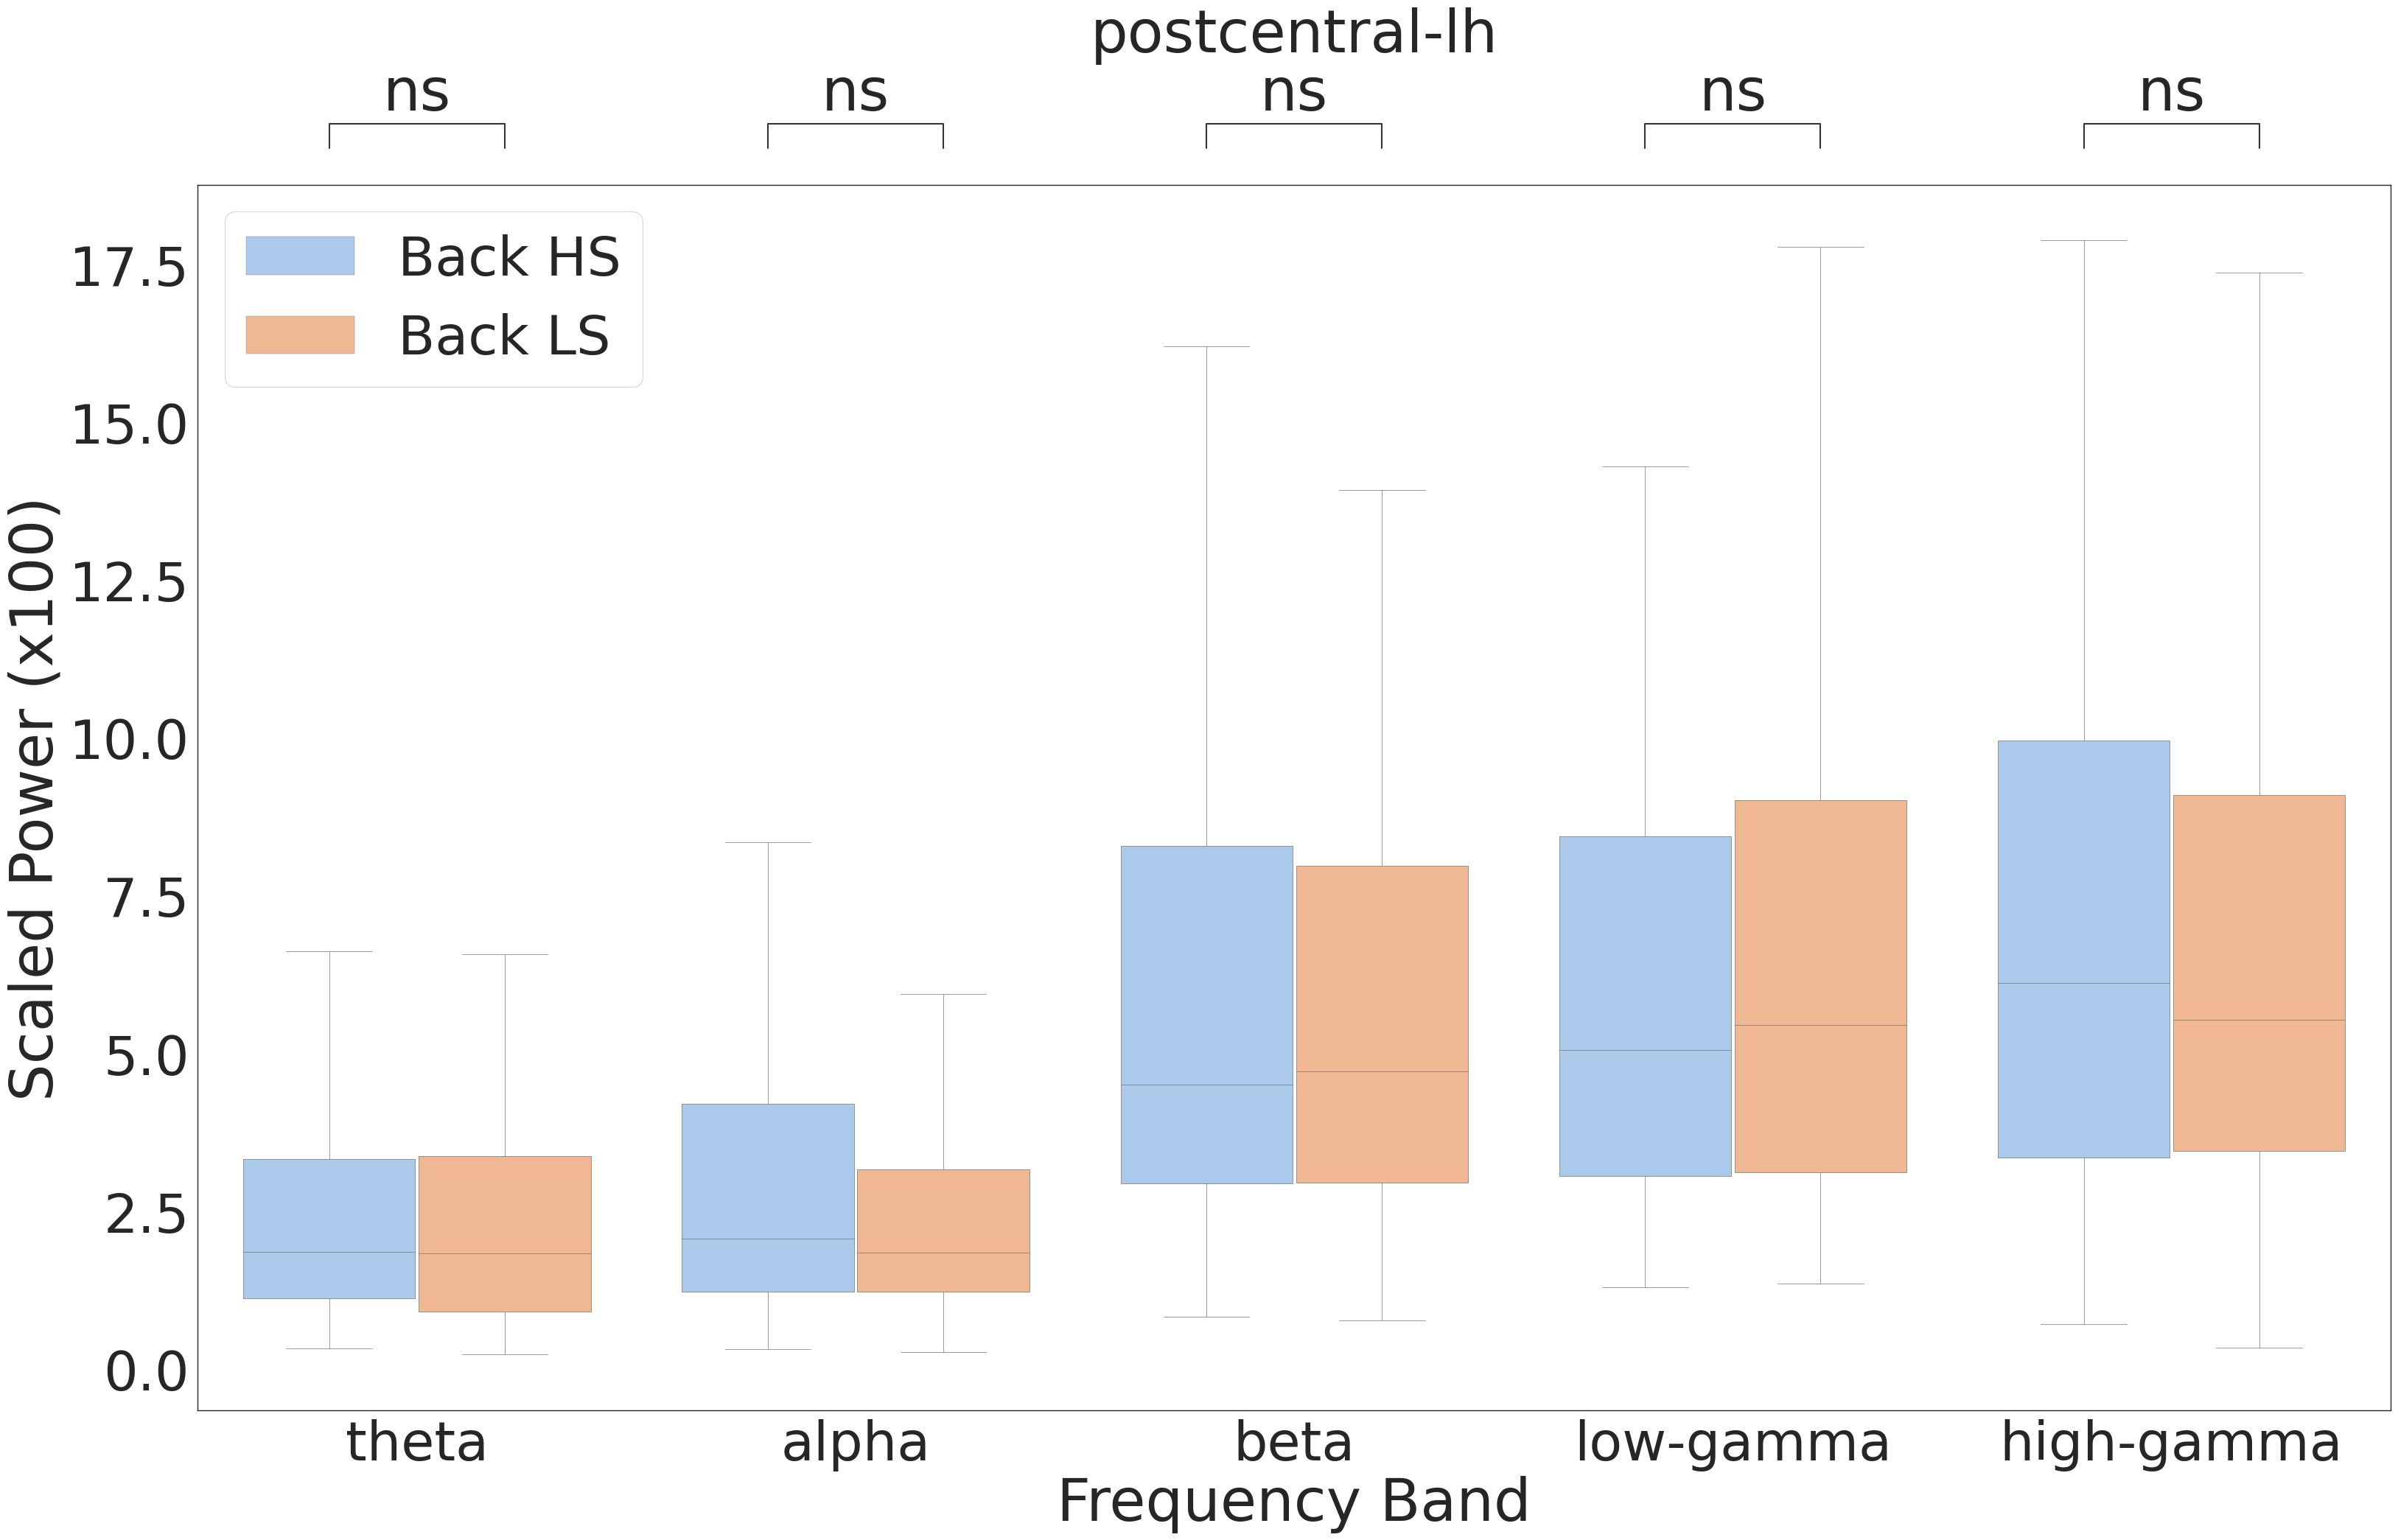

<Figure size 640x480 with 0 Axes>

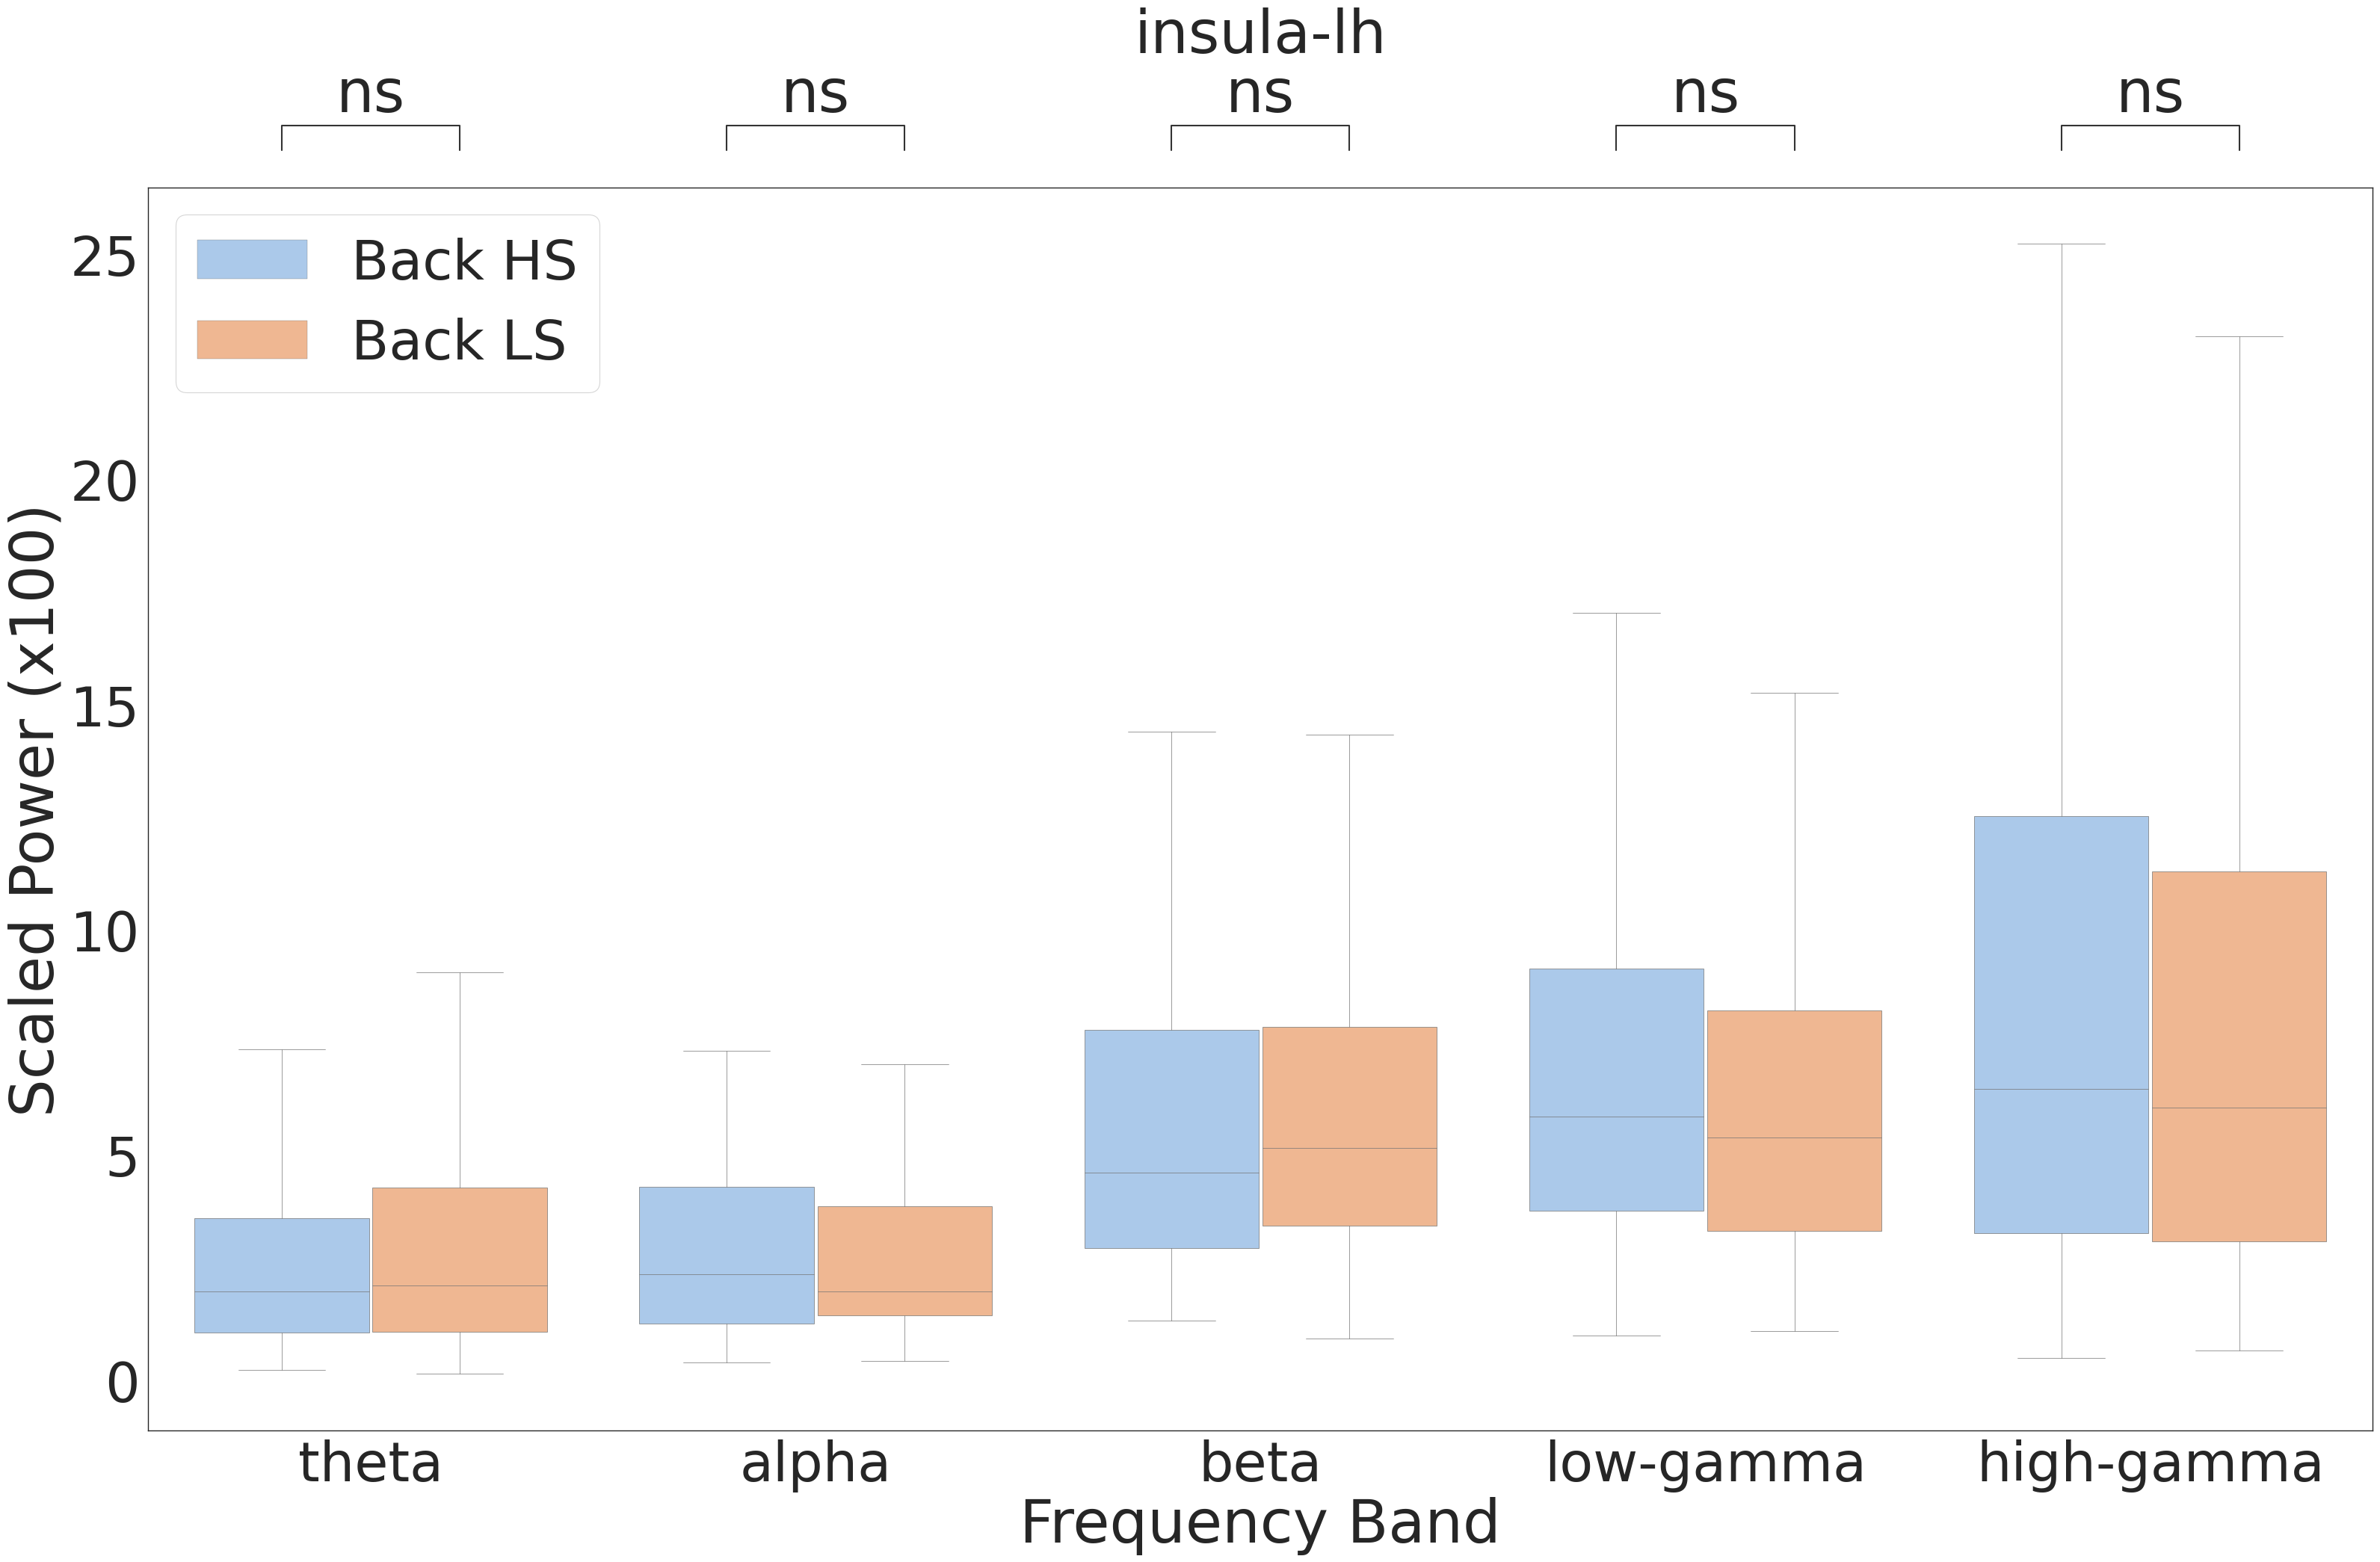

<Figure size 640x480 with 0 Axes>

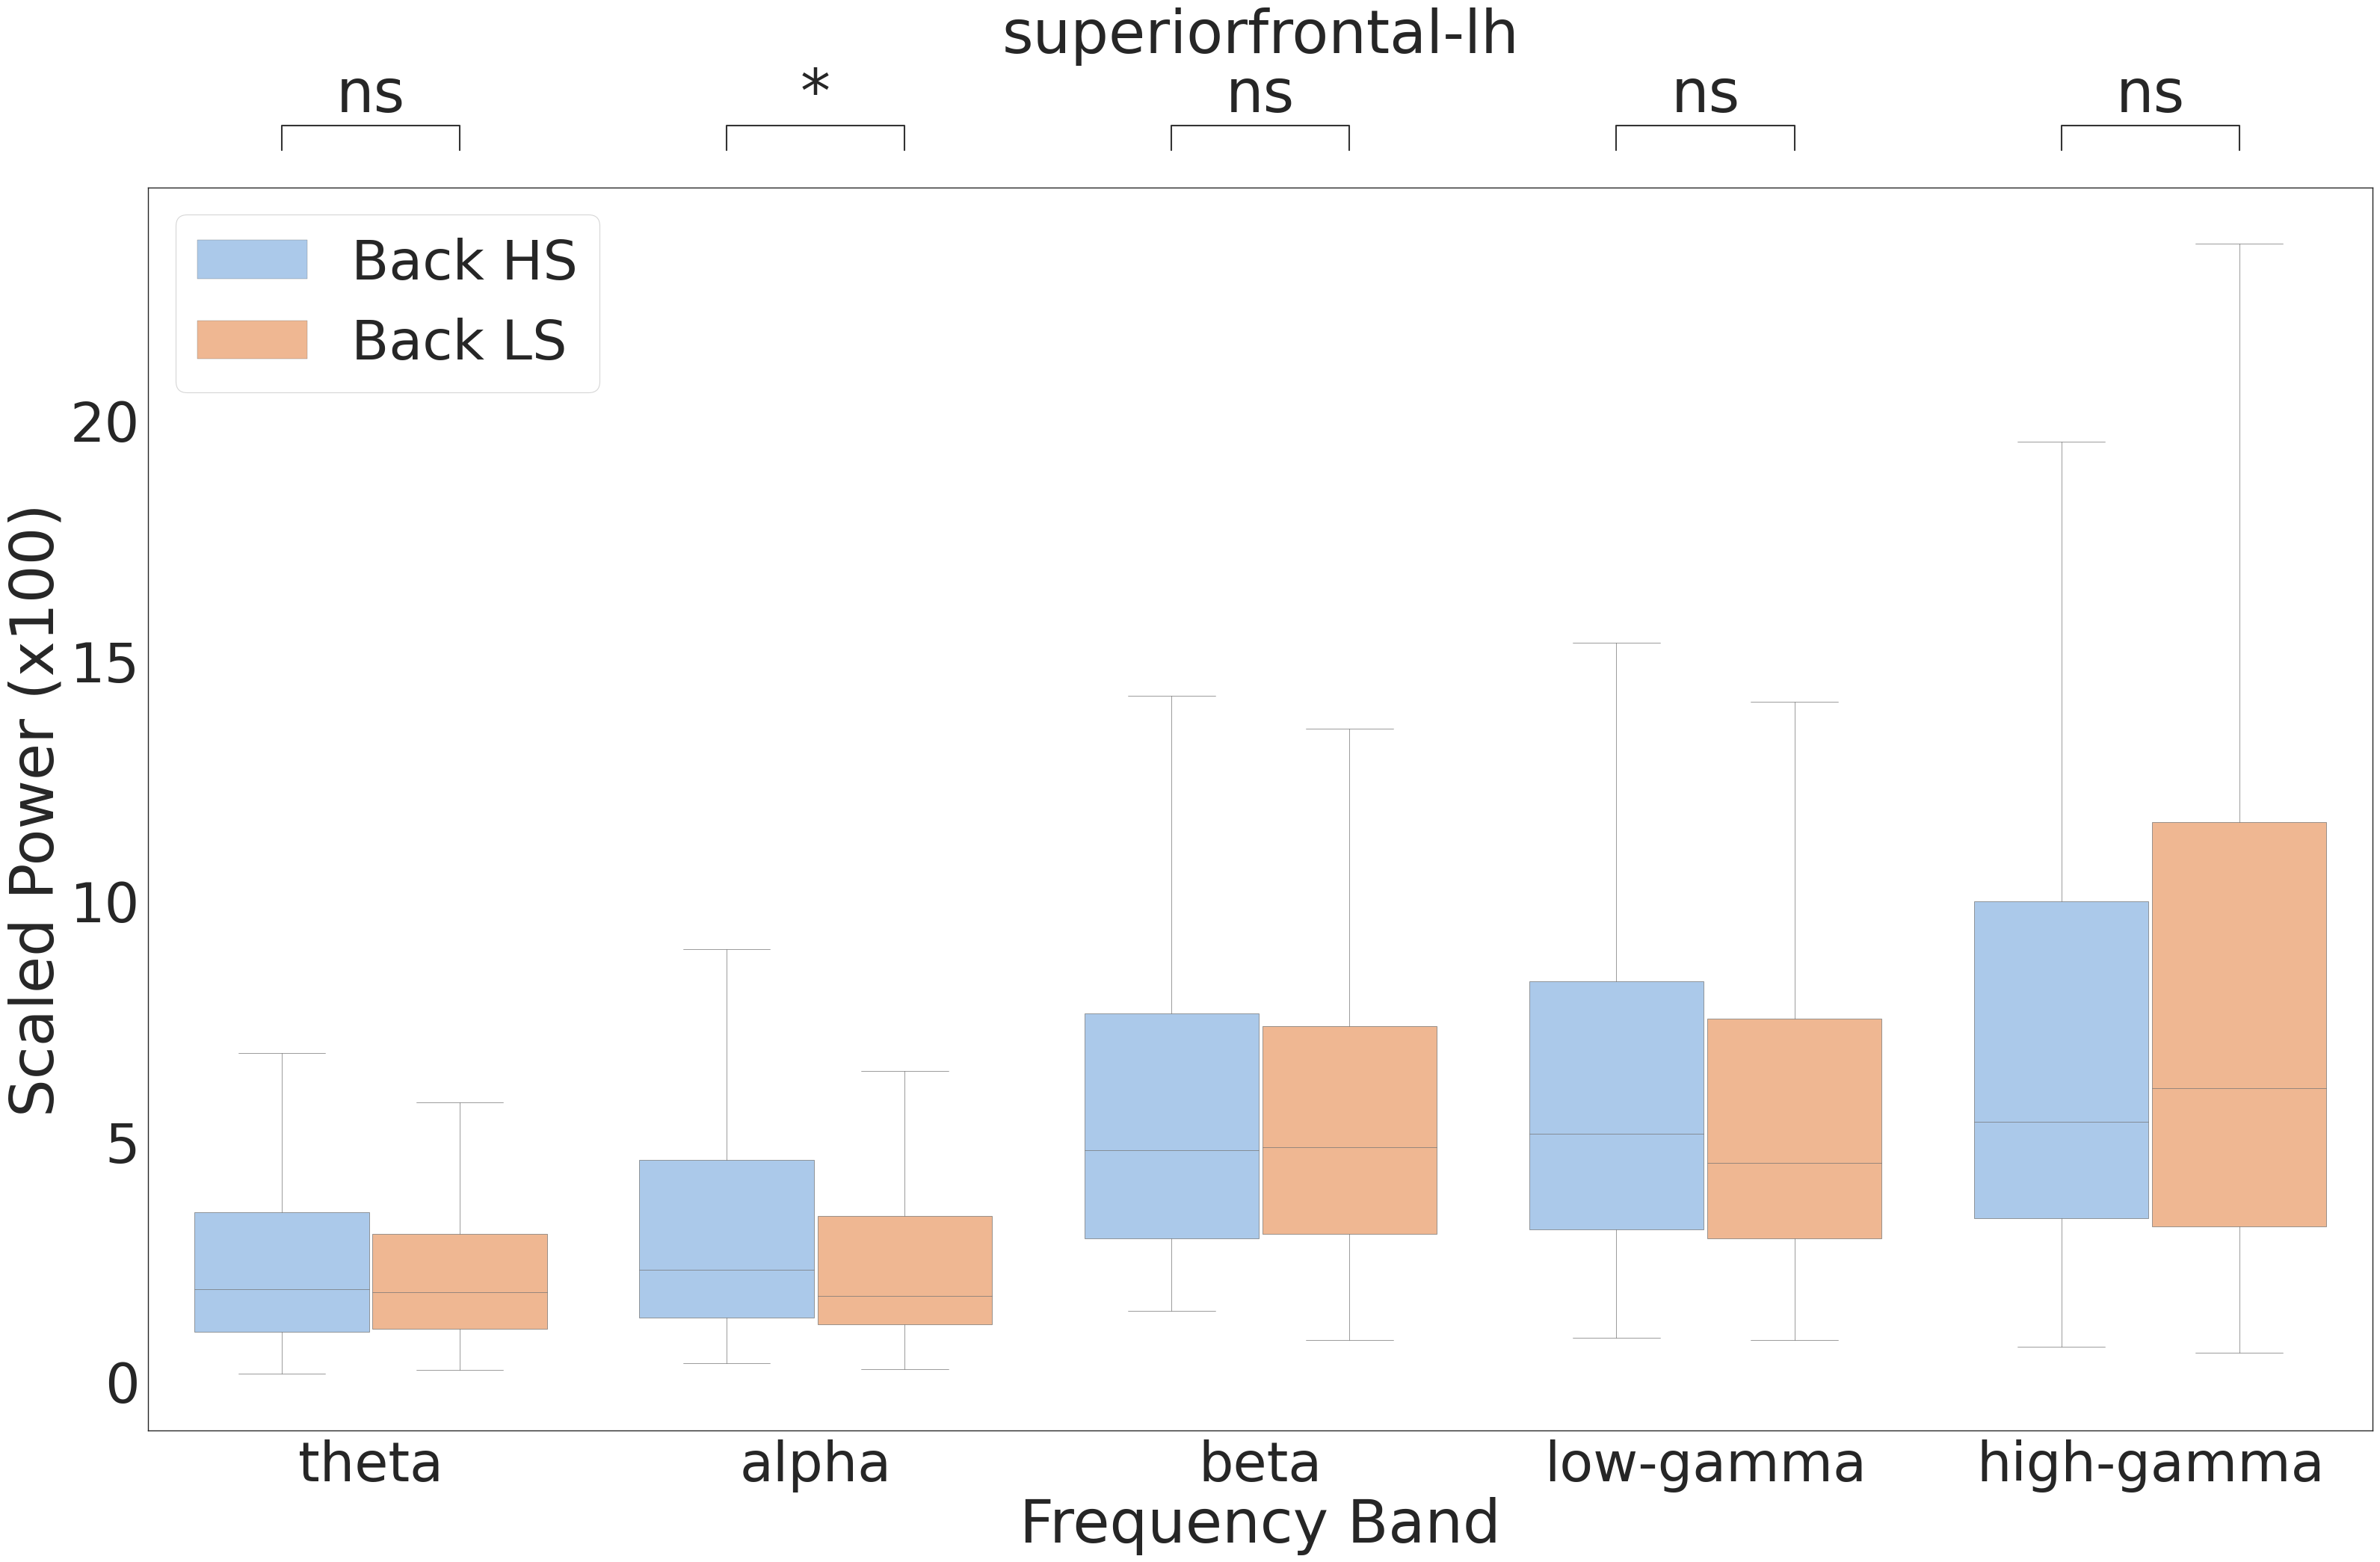

<Figure size 640x480 with 0 Axes>

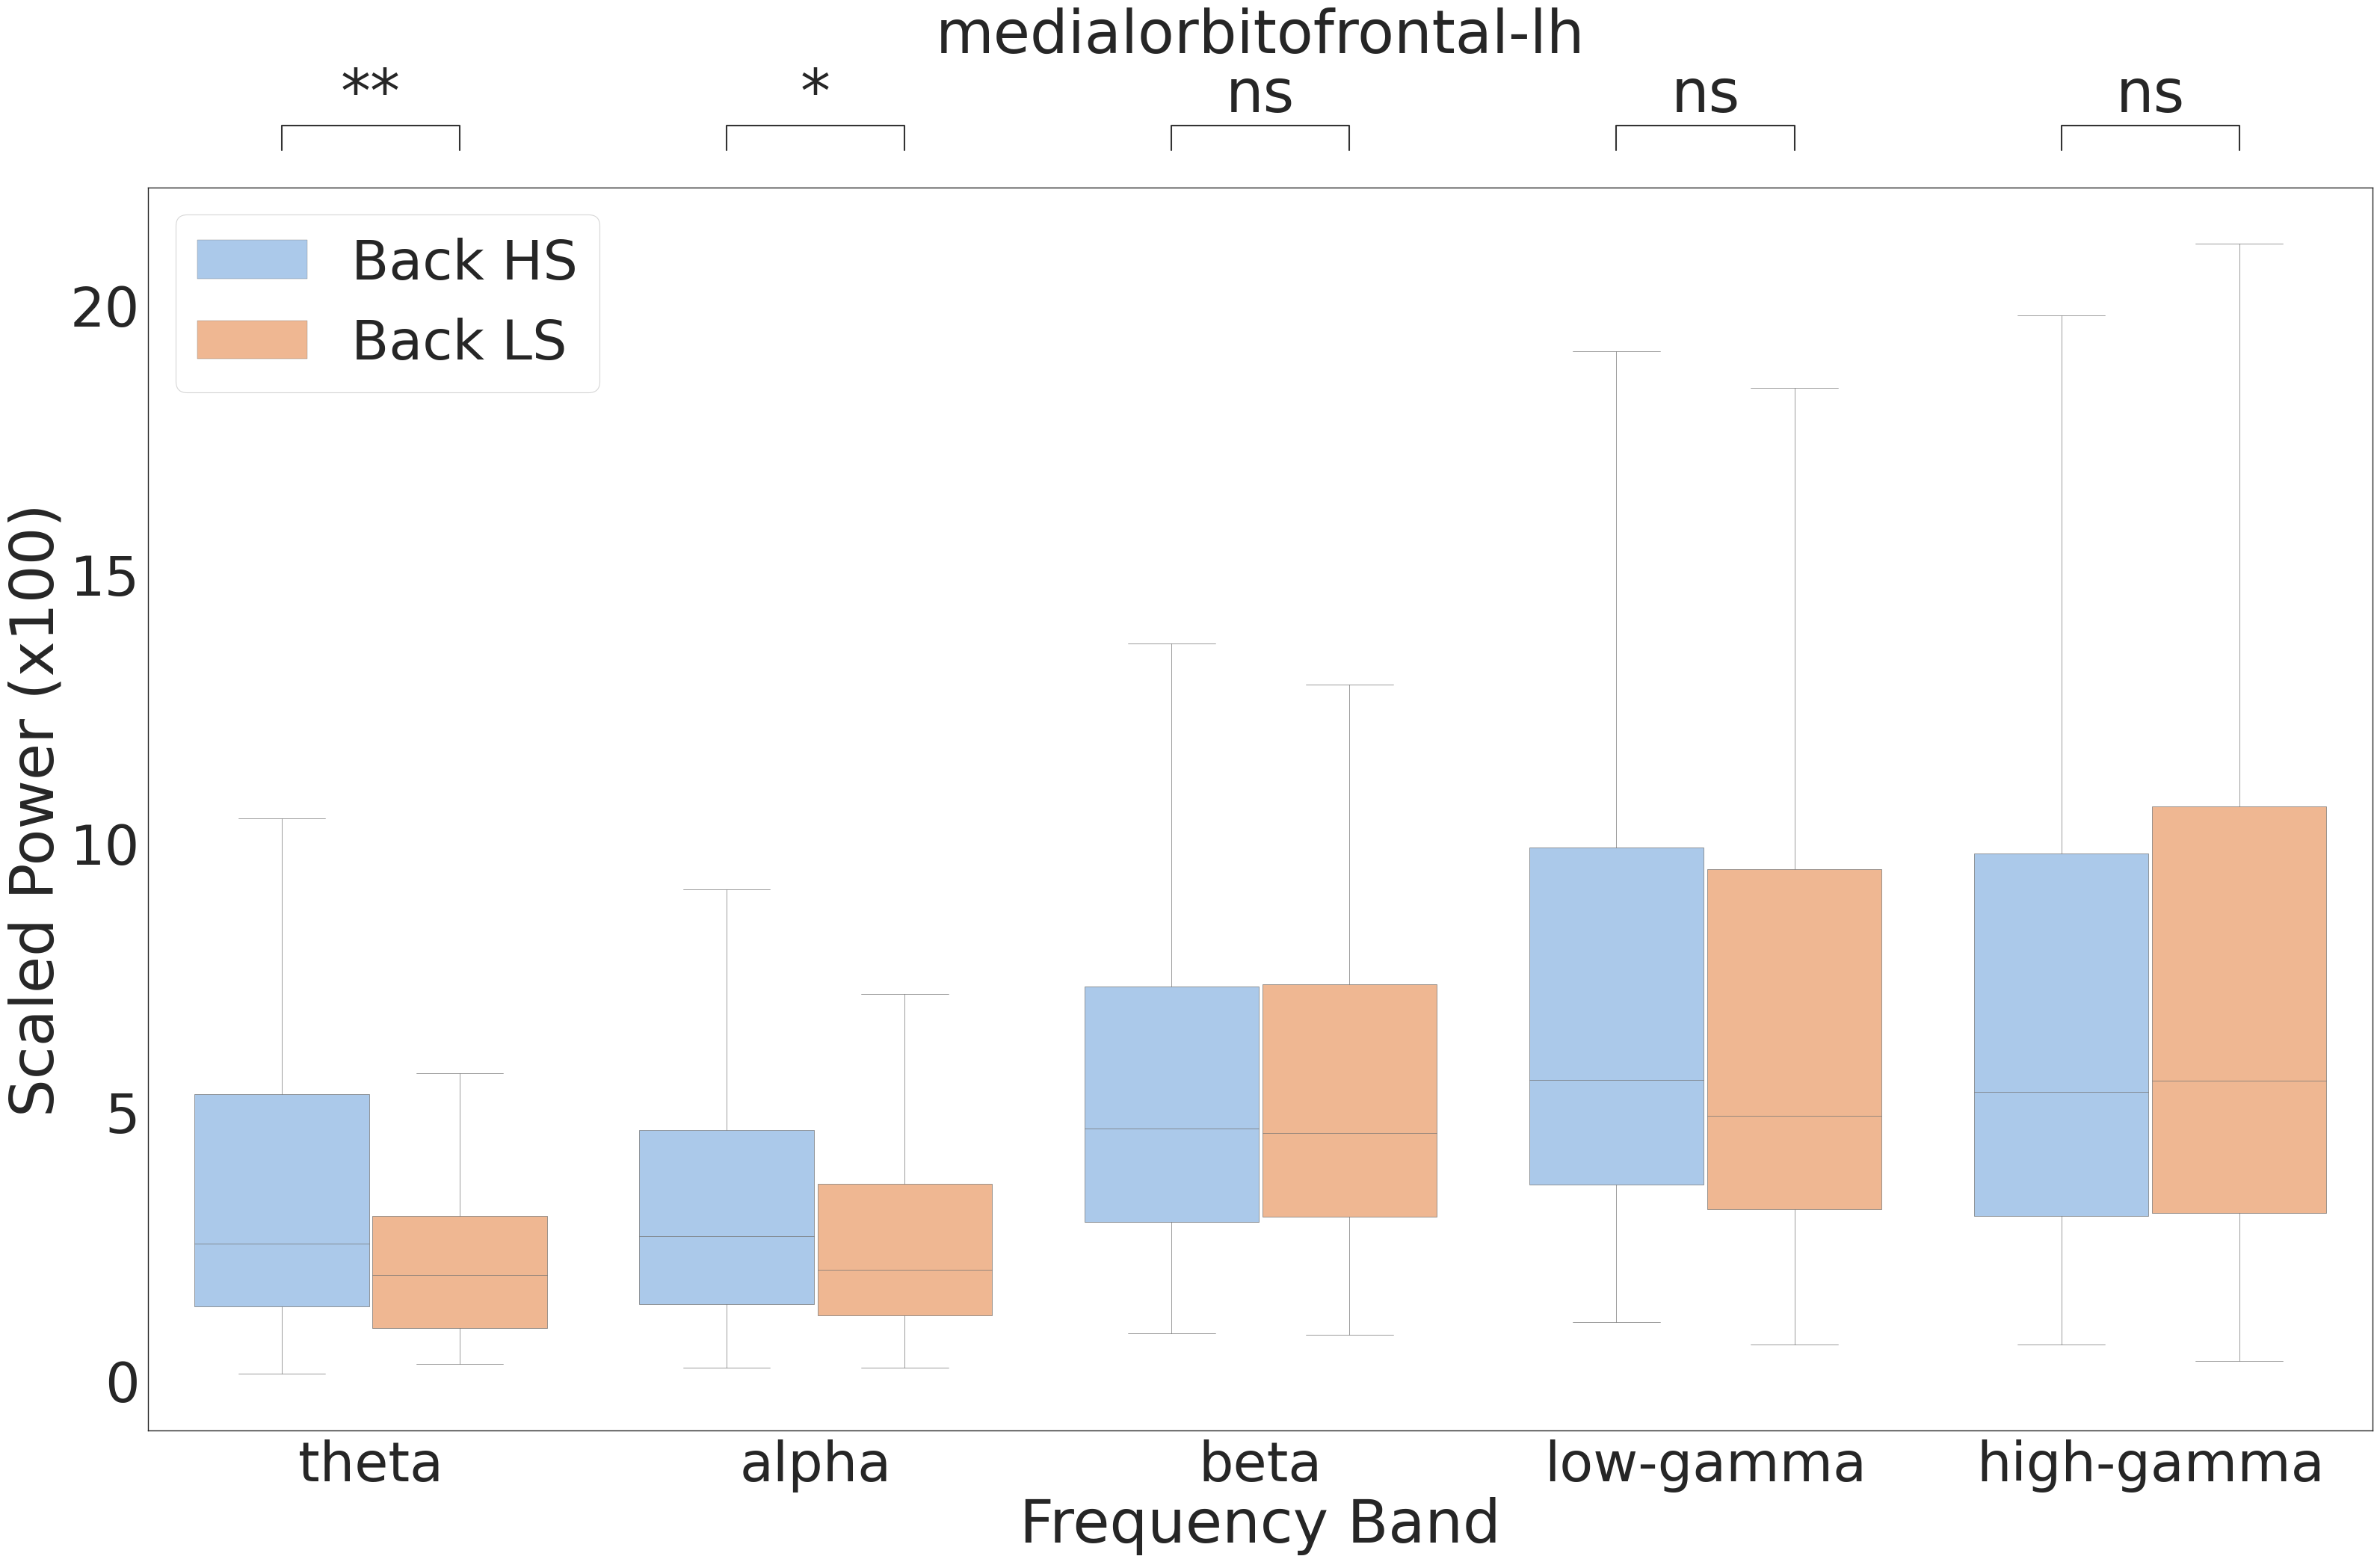

<Figure size 640x480 with 0 Axes>

In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ EVALUATE AND SAVE STATS OUTPUTS @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ #
df_mean_combined_hand=pd.concat(df_mean_all_hand) 
df_peak_combined_hand=pd.concat(df_peak_all_hand)

df_mean_combined_back=pd.concat(df_mean_all_back) 
df_peak_combined_back=pd.concat(df_peak_all_back)

hand_save_path = f"../../../../George Kenefati/EEG/Data/STC ERDS Results/{group}/Combined Stimbased Hand Set {subject_set}/"
if not os.path.exists(hand_save_path):
    os.makedirs(hand_save_path)
conditions=['Hand HS','Hand LS']
stats_plot(df_mean_combined_hand, hand_save_path, 'hand', 'mean')
stats_plot(df_peak_combined_hand, hand_save_path, 'hand', 'peak')

# change save_path
back_save_path = f"../../../../George Kenefati/EEG/Data/STC ERDS Results/{group}/Combined Stimbased Back Set {subject_set}/"
if not os.path.exists(back_save_path):
    os.makedirs(back_save_path)

conditions=['Back HS','Back LS']
stats_plot(df_mean_combined_back, back_save_path, 'back', 'mean')
stats_plot(df_peak_combined_back, back_save_path, 'back', 'peak')

#### Troubleshooting

In [ ]:
raw = mne.io.read_raw(os.path.join(processed_info_path,sub_num+'_preprocessed-raw.fif'))
epochs = mne.read_epochs(os.path.join(processed_info_path,sub_num+'_preprocessed-epo.fif'))
print(raw)
print(epochs)

Opening raw data file ../../../../George Kenefati/EEG/Data/Processed Data/037_preprocessed-raw.fif...
    Range : 0 ... 771039 =      0.000 ...  1927.598 secs
Ready.
Reading /home/wanglab/Documents/George Kenefati/EEG/eeg-erds-stats/cross subject/../../../../George Kenefati/EEG/Data/Processed Data/037_preprocessed-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
<Raw | 037_preprocessed-raw.fif, 64 x 771040 (1927.6 s), ~92 kB, data not loaded>
<EpochsFIF |  43 events (all good), -0.2 - 0.8 sec, baseline -0.2 – 0 sec, ~8.5 MB, data loaded,
 '1000001': 20
 '1100001': 23
 'Yes Pain Back': 0>


In [ ]:
print(stc_objects_lst)
print(extracted_data_tmp.shape)
print(extracted_data_tmp.shape[1] / Fs / 60)
print(epo_times[i])
print(extracted_data_tmp[:,int(epo_times[i]+tmin*Fs):int(epo_times[i]+tmax*Fs)])

[<SourceEstimate | 83 vertices, tmin : 0.0 (ms), tmax : 1927597.5 (ms), tstep : 2.5 (ms), data shape : (83, 771040), ~244.1 MB>, <SourceEstimate | 90 vertices, tmin : 0.0 (ms), tmax : 1927597.5 (ms), tstep : 2.5 (ms), data shape : (90, 771040), ~264.7 MB>, <SourceEstimate | 763 vertices, tmin : 0.0 (ms), tmax : 1927597.5 (ms), tstep : 2.5 (ms), data shape : (763, 771040), ~2.19 GB>, <SourceEstimate | 165 vertices, tmin : 0.0 (ms), tmax : 1927597.5 (ms), tstep : 2.5 (ms), data shape : (165, 771040), ~485.3 MB>, <SourceEstimate | 593 vertices, tmin : 0.0 (ms), tmax : 1927597.5 (ms), tstep : 2.5 (ms), data shape : (593, 771040), ~1.70 GB>, <SourceEstimate | 327 vertices, tmin : 0.0 (ms), tmax : 1927597.5 (ms), tstep : 2.5 (ms), data shape : (327, 771040), ~961.8 MB>]
(327, 771040)
51.40266666666666
754716
[[-0.5870243  -0.21637547 -0.24306943 ...  0.5622086   0.07323444
  -0.1698523 ]
 [ 0.524224    0.5123593   0.02569015 ...  0.44815588 -0.13421245
  -0.46104357]
 [-0.1819572  -0.3147980